<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Forex/EURJPY/EURJPY_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "EURJPY=X"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open     High      Low    Close  Adj Close  Volume
Date                                                             
2009-01-01  126.870  128.180  125.570  126.920    126.920       0
2009-01-02  126.977  128.000  126.033  127.860    127.860       0
2009-01-05  128.460  128.460  126.418  127.110    127.110       0
2009-01-06  127.100  127.120  125.191  126.059    126.059       0
2009-01-07  126.030  127.560  125.899  126.180    126.180       0
...             ...      ...      ...      ...        ...     ...
2018-12-26  126.022  126.214  125.800  126.002    126.002       0
2018-12-27  126.409  126.664  126.024  126.405    126.405       0
2018-12-28  126.774  126.974  126.288  126.768    126.768       0
2018-12-31  126.220  126.422  125.414  126.249    126.249       0
2019-01-01  125.690  126.550  125.660  125.980    125.980       0

[2606 rows x 6 columns]

Open         High          Low        Close    Adj Close  Volume
count  2606.000000  2606.000000  2606.000000  2606.000000  2606.000000  2606.0
mean    124.223467   124.773843   123.610884   124.217614   124.217614     0.0
std      12.053407    12.027080    12.088422    12.053273    12.053273     0.0
min      94.224000    95.000000    94.134000    94.210000    94.210000     0.0
25%     114.346250   114.885250   113.741500   114.355000   114.355000     0.0
50%     127.847500   128.419500   127.158000   127.860000   127.860000     0.0
75%     133.216000   133.732250   132.598500   133.212000   133.212000     0.0
max     149.480000   149.518000   148.290000   149.441000   149.441000     0.0

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear        mama        fama      SAREXT      DEMA_8       EMA_8      KAMA_8  MIDPOINT_8  MIDPRICE_8    SAR_0.08       SMA_8      TEMA_8    TRIMA_8       WMA_8      MA_8_0    MAVP_8_0      T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5      MA_8_1    MAVP_8_1      T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
2009-03-12  124.520  126.380  122.170  125.480    125.480   12          3         71             31             0               1               0                 1      3        1    11        3             0          11  124.175520  120.076711 -126.380000  125.523378  124.455546  121.932978    124.3630    124.1690  126.380000  124.534500  125.346648  124.51755  124.804361  124.534500  125.200667  122.143152              126.232675               124.534500              122.836325              127.081762               124.534500              121.987238              127.930850               124.534500              121.138150              128.779937               124.534500              120.289063  124.455546  125.115628  122.533880              126.153721               124.455546              122.757371              127.002808               124.455546              121.908283              127.851896               124.455546              121.059196              128.700983   
2009-03-13  125.480  127.550  125.467  126.620    126.620   13          4         72             31             0               1               0                 1      3        1    11        4             1          11  125.397760  121.406973  122.170000  126.141175  124.936536  122.271567    124.8670    124.8600  122.170000  124.928625  126.110124  124.83795  125.267806  124.928625  126.050000  122.496206              126.895180               124.928625              122.962070              127.878457               124.928625              121.978793              128.861734               124.928625              120.995516              129.845011               124.928625              120.012239  124.936536  126.160021  122.882180              126.903090               124.936536              122.969981              127.886368               124.936536              121.986704              128.869645               124.936536              121.003426              129.852922   
2009-03-16  126.397  128.650  126.330  127.411    127.411   16         

Open         High          Low        Close    Adj Close          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000    2556.000000   2556.000000     2556.000000     2556.000000       2556.000000  2556.000000  2556.000000  2556.000000  2556.000000   2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000             2556.000000              2556.000000             2556.000000             2556.000000              2556.000000             2556.000000             2556.000000              2556.000000             2556.000000             2556.000000              2556.000000             2556.000000  2556.000000  2556.000000  2556.000000             2556.000000              2556.000000             2556.000000             2556.000000              2556.000000             2556.000000             2556.000000   
mean    124.302603   124.839874   123.704829   124.296273   124.296273    15.758607     1.999218   185.926448      30.467919      0.033255        0.966745        0.010955          0.989045     6.615806     2.537167    27.008998     1.999218      2.000000    27.008998   124.299268   124.283497    -2.500926   124.298499   124.293019   124.382991   124.263486   124.211699   124.140665   124.294046   124.296006   124.294117   124.294883   124.294046   124.294472   124.279568              126.054461               124.294046              122.533631              126.934669               124.294046              121.653423              127.814877               124.294046              120.773216              128.695084               124.294046              119.893008   124.293019   124.294793   124.282604              126.053435               124.293019              122.532604              126.933642               124.293019              121.652397              127.813850   
std      12.144052    12.122791    12.173783    12.144998    12.144998     8.806999     1.414767   104.411507       0.781481      0.179337        0.179337        0.104110          0.104110     3.414756     1.108139    14.931190     1.414767      1.414214    14.931190    12.119989    12.013536   124.836683    12.160903    12.083363    12.101785    12.096438    12.091921    12.157869    12.103193    12.153476    12.111992    12.109650    12.103193    12.133016    12.029661               12.094894                12.103193               12.188597               12.119767                12.103193               12.259767               12.163859                12.103193               12.349508               12.226964                12.103193               12.457417    12.083363    12.127306    12.040509               12.076634                12.083363               12.167335               12.102334                12.083363               12.237847               12.147277   
min      94.224000    95.000000    94.134000    94.210000    94.210000     1.000000     0.0000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2009-03-12  0.548284  0.575590  0.517690  0.566168   0.566168   12          3         71             31             0               1               0                 1      3        1    11        3             0          11  0.547559  0.471022  0.078111  0.570075  0.549670  0.505484    0.545754    0.542373  0.582226  0.552382  0.568730  0.552046  0.556619  0.552382  0.562713  0.506920                0.556161                 0.552382                0.548222                0.553694                 0.552382                0.546763                0.548926                 0.552382                0.543421                0.545664                 0.552382                0.540169  0.549670  0.564459  0.514217                0.552594                 0.549670                0.549106                0.548741                 0.549670                0.547728                0.544677                 0.549670                0.544379                0.541053                 0.549670   
2009-03-13  0.565658  0.597051  0.578569  0.586808   0.586808   13          4         72             31             0               1               0                 1      3        1    11        4             1          11  0.570777  0.497332  0.917189  0.581453  0.558839  0.512129    0.555247    0.555539  0.506211  0.559867  0.582769  0.558092  0.565367  0.559867  0.578319  0.513848                0.568738                 0.559867                0.550585                0.568698                 0.559867                0.546605                0.566075                 0.559867                0.540804                0.564810                 0.559867                0.535158  0.558839  0.583736  0.521017                0.566907                 0.558839                0.553094                0.565397                 0.558839                0.549184                0.563418                 0.558839                0.543358                0.561773                 0.558839   
2009-03-16  0.582254  0.617227  0.594505  0.601130   0.601130   16          0         75

138253

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpddq_2jdf
  JVM stdout: /tmp/tmpddq_2jdf/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpddq_2jdf/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 3 days
H2O cluster name:           H2O_from_python_unknownUser_3qbygj
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_151725_mod...  0.662687  0.657264              0.459688  0.483173  0.233456
1  DeepLearning_grid_1_AutoML_20190822_151725_mod...  0.643893  0.727373              0.417539  0.515562  0.265804
2  DeepLearning_grid_1_AutoML_20190822_151725_mod...  0.623385  1.787004              0.410132  0.604976  0.365995
3              DeepLearning_1_AutoML_20190822_151725  0.613897  0.695758              0.455984  0.495132  0.245155
4  DeepLearning_grid_1_AutoML_20190822_151725_mod...  0.608020  0.776949              0.431772  0.523528  0.274081
5  DeepLearning_grid_1_AutoML_20190822_151725_mod...  0.591154  0.692900              0.496296  0.499876  0.249876
6  DeepLearning_grid_1_AutoML_20190822_151725_mod...  0.500000  0.692086              0.500000  0.499469  0.249470
7  DeepLearning_grid_1_AutoML_20190822_151725_mod...  0.486685  0.721965              0.500000  0.513119  0.263291
8  DeepLearning_grid_1_AutoML_20190822_151725_mod...  0.459902  0.697494              0.500000  0.502166  0.252171
9  DeepLearning_grid_1_AutoML_20190822_151725_mod...  0.439700  0.740508              0.500000  0.519788  0.270180

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.003056
1           CDLSEPARATINGLINES             0.919690           0.919690    0.002810
2                         SINH             0.876013           0.876013    0.002677
3              CDLHOMINGPIGEON             0.857270           0.857270    0.002620
4                         COSH             0.849307           0.849307    0.002595
...                        ...                  ...                ...         ...
1021                 MAVP_14_1             0.254626           0.254626    0.000778
1022   BBANDS_upperband_30_5_5             0.253716           0.253716    0.000775
1023  BBANDS_middleband_14_2_4             0.248384           0.248384    0.000759
1024       CDLXSIDEGAP3METHODS             0.246947           0.246947    0.000755
1025               CDLMARUBOZU             0.230750           0.230750    0.000705

[1026 rows x 4 columns]

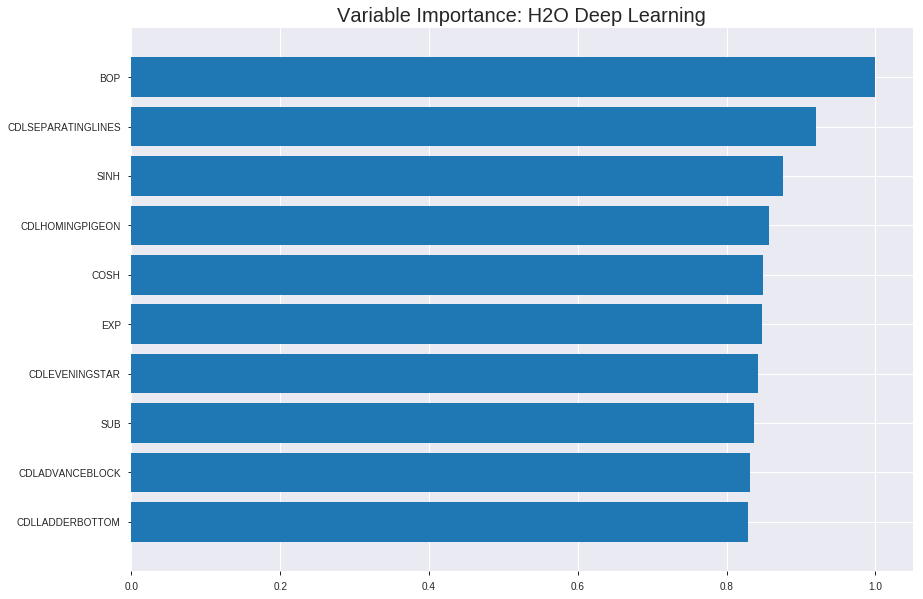

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_151725_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.26011892766213585
RMSE: 0.510018556193925
LogLoss: 0.7339036618060819
Mean Per-Class Error: 0.4052392604369872
AUC: 0.6262242419003017
pr_auc: 0.5916173570262986
Gini: 0.25244848380060336
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2514623840774239: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      127  800   0.863    (800.0/927.0)
1      27   834   0.0314   (27.0/861.0)
Total  154  1634  0.4625   (827.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.251462     0.668537  333
max f2                       0.131529     0.828505  371
max f0point5                 0.557965     0.583284  203
max accuracy                 0.609184     0.5934    175
max precision                0.988806     1         0
max recall                   0.0268681    1         394
max specificity              0.988806     1         0
max absolute_mcc             0.449956     0.198942  257
max min_per_class_accuracy   0.614924     0.588997  172
max mean_per_class_accuracy  0.557965     0.594761  203

Gains/Lift Table: Avg response rate: 48.15 %, avg score: 59.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.946001           1.73055   1.73055            0.833333         0.960288  0.833333                    0.960288            0.0174216       0.0174216                  73.0546   73.0546
    2        0.0201342                   0.935445           1.73055   1.73055            0.833333         0.940889  0.833333                    0.950589            0.0174216       0.0348432                  73.0546   73.0546
    3        0.0302013                   0.928578           1.84592   1.769              0.888889         0.93278   0.851852                    0.944652            0.018583        0.0534262                  84.5916   76.9002
    4        0.0402685                   0.920937           1.1537    1.61518            0.555556         0.925441  0.777778                    0.939849            0.0116144       0.0650407                  15.3697   61.5176
    5        0.0503356                   0.913499           1.03833   1.49981            0.5              0.917307  0.722222                    0.935341            0.010453        0.0754936                  3.83275   49.9806
    6        0.100112                    0.883762           1.14333   1.32256            0.550562         0.89774   0.636872                    0.916645            0.0569106       0.132404                   14.3327   32.2562
    7        0.150447                    0.839415           1.22292   1.28922            0.588889         0.861199  0.620818                    0.898094            0.0615563       0.193961                   22.2919   28.9225
    8        0.200224                    0.803102           1.07333   1.23555            0.516854         0.820207  0.594972                    0.878731            0.0534262       0.247387                   7.33273   23.5552
    9        0.300336                    0.726785           1.18335   1.21815            0.569832         0.763716  0.586592                    0.840393            0.118467        0.365854                   18.3345   21.815
    10       0.399888                    0.673046           1.18999   1.21114            0.573034         0.698982  0.583217                    0.805189            0.118467        0.484321                   18.9993   21.114
    11       0.5                         0.613234           1.10214   1.18931            0.530726         0.642166  0.572707                    0.772548            0.110337        0.594657                   10.2135   18.9315
    12       0.600112                    0.553236           1.00932   1.15929            0.486034         0.584497  0.558248                    0.741177            0.101045        0.695703                   0.932396  15.9288
    13       0.699664                    0.491106           0.933328  1.12714            0.449438         0.523545  0.542766                    0.710211            0.0929152       0.788618                   -6.66719  12.7137
    14       0.799776                    0.403071           0.881708  1.09642            0.424581         0.455326  0.527972                    0.678305            0.0882695       0.876887                   -11.8292  9.64158
    15       0.899888                    0.268829           0.765694  1.05962            0.368715         0.340744  0.510255                    0.640752            0.0766551       0.953542                   -23.4306  5.96232
    16       1                           6.05183e-05        0.464057  1                  0.223464         0.167467  0.481544                    0.59337            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2597095619620143
RMSE: 0.5096170738525293
LogLoss: 0.7218801742482809
Mean Per-Class Error: 0.41115537848605577
AUC: 0.5827229543365001
pr_auc: 0.5257419539421552
Gini: 0.16544590867300024
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37514557814967: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      32   228  0.8769   (228.0/260.0)
1      10   241  0.0398   (10.0/251.0)
Total  42   469  0.4658   (238.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375146     0.669444  359
max f2                       0.167122     0.831677  393
max f0point5                 0.509725     0.581531  269
max accuracy                 0.598731     0.589041  184
max precision                0.598731     0.582996  184
max recall                   0.167122     1         393
max specificity              0.921803     0.996154  0
max absolute_mcc             0.597221     0.177719  186
max min_per_class_accuracy   0.597221     0.577689  186
max mean_per_class_accuracy  0.597221     0.588845  186

Gains/Lift Table: Avg response rate: 49.12 %, avg score: 58.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117417                   0.870681           0.678619  0.678619           0.333333         0.886678  0.333333                    0.886678            0.00796813      0.00796813                 -32.1381   -32.1381
    2        0.0215264                   0.855125           0.407171  0.555234           0.2              0.864429  0.272727                    0.876565            0.00398406      0.0119522                  -59.2829   -44.4766
    3        0.0313112                   0.833598           1.22151   0.763446           0.6              0.838654  0.375                       0.864718            0.0119522       0.0239044                  22.1514    -23.6554
    4        0.0410959                   0.82439            1.22151   0.87251            0.6              0.827183  0.428571                    0.855781            0.0119522       0.0358566                  22.1514    -12.749
    5        0.0508806                   0.815173           1.22151   0.939626           0.6              0.819728  0.461538                    0.848848            0.0119522       0.0478088                  22.1514    -6.03739
    6        0.101761                    0.780624           0.939626  0.939626           0.461538         0.79676   0.461538                    0.822804            0.0478088       0.0956175                  -6.03739   -6.03739
    7        0.150685                    0.736618           1.14008   1.00471            0.56             0.756325  0.493506                    0.80122             0.0557769       0.151394                   14.008     0.470844
    8        0.201566                    0.703652           1.09623   1.02781            0.538462         0.720826  0.504854                    0.780926            0.0557769       0.207171                   9.62305    2.78111
    9        0.30137                     0.66256            1.35724   1.13691            0.666667         0.683671  0.558442                    0.748718            0.135458        0.342629                   35.7238    13.6907
    10       0.401174                    0.624826           1.23748   1.16193            0.607843         0.643347  0.570732                    0.722504            0.123506        0.466135                   23.7481    16.1928
    11       0.500978                    0.593017           1.11773   1.15312            0.54902          0.608538  0.566406                    0.6998              0.111554        0.577689                   11.7725    15.3122
    12       0.600783                    0.559264           0.95805   1.12072            0.470588         0.577843  0.550489                    0.67954             0.0956175       0.673307                   -4.19498   12.0716
    13       0.700587                    0.514484           0.997969  1.10323            0.490196         0.535445  0.541899                    0.659012            0.0996016       0.772908                   -0.203109  10.323
    14       0.800391                    0.467153           0.758456  1.06024            0.372549         0.494529  0.520782                    0.638502            0.0756972       0.848606                   -24.1544   6.02383
    15       0.900196                    0.392282           0.95805   1.04891            0.470588         0.432443  0.515217                    0.615656            0.0956175       0.944223                   -4.19498   4.89087
    16       1                           0.000579917        0.558863  1                  0.27451          0.280498  0.491194               


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 15:21:32  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 15:21:34  4 min  3.030 sec  463 obs/sec       0.415548  1             743        0.596081         1.49898             -0.423191      0.577629        0.54443            1.38444          0.518456                         0.638146           1.60967               -0.629426        0.500942          0.490409             1.01793            0.508806
    2019-08-22 15:21:45  4 min 13.755 sec  519 obs/sec       3.28747   8             5878       0.6416           4.17107             -0.648848      0.580552        0.514999           1.73055          0.518456                         0.665258           2.95374               -0.770823        0.526371          0.485073             1.01793            0.500978
    2019-08-22 15:21:55  4 min 24.479 sec  522 obs/sec       6.15716   15            11009      0.594817         1.72139             -0.417162      0.631057        0.505085           1.61518          0.444631                         0.59479            1.51646               -0.415538        0.58234           0.521477             1.01793            0.475538
    2019-08-22 15:22:06  4 min 34.606 sec  534 obs/sec       9.02908   22            16144      0.593384         2.80329             -0.410339      0.587203        0.368632           1.61518          0.455817                         0.599134           1.80221               -0.436292        0.55377           0.48608              0.339309           0.493151
    2019-08-22 15:22:16  4 min 44.702 sec  541 obs/sec       11.9189   29            21311      0.529198         0.893632            -0.121732      0.640312        0.586573           1.73055          0.418904                         0.535925           0.857005              -0.149221        0.581758          0.535215             1.01793            0.469667
    2019-08-22 15:22:26  4 min 54.597 sec  546 obs/sec       14.7595   36            26390      0.507989         0.731023            -0.0336185     0.673383        0.640908           1.73055          0.427852                         0.52318            0.754778              -0.0952096       0.557049          0.517885             0.339309           0.459883
    2019-08-22 15:22:35  5 min  4.518 sec  550 obs/sec       17.6119   43            31490      0.569439         0.993772            -0.298812      0.572113        0.538465           1.61518          0.486018                         0.538516           0.831561              -0.160356        0.535811          0.502431             0.339309           0.477495
    2019-08-22 15:22:45  5 min 14.382 sec  554 obs/sec       20.4966   50            36648      0.510019         0.733904            -0.0418953     0.626224        0.591617           1.73055          0.462528                         0.509617           0.72188               -0.0391606       0.582723          0.525742             0.678619           0.465753
    2019-08-22 15:22:55

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.0030557147424766
CDLSEPARATINGLINES        0.9196903109550476     0.9196903109550476   0.0028103112416982276
SINH                      0.8760131001472473     0.8760131001472473   0.002676846144722574
CDLHOMINGPIGEON           0.857269823551178      0.857269823551178    0.002619572038105648
COSH                      0.8493070602416992     0.8493070602416992   0.002595240104870022
---                       ---                    ---                  ---
MAVP_14_1                 0.2546256482601166     0.2546256482601166   0.0007780633472010994
BBANDS_upperband_30_5_5   0.2537163496017456     0.2537163496017456   0.0007752847898854011
BBANDS_middleband_14_2_4  0.24838432669639587    0.24838432669639587  0.000758991648886301
CDLXSIDEGAP3METHODS       0.24694697558879852    0.24694697558879852  0.0007545995139167006
CDLMARUBOZU               0.23074956238269806    0.23074956238269806  0.0007051048395928343


See the whole table with table.as_data_frame()


('accuracy', 0.6640625)

('F1', 0.6593406593406593)

('auc', 0.6626874808692991)

('logloss', 0.6572641560057046)

('mean_per_class_error', 0.3468013468013468)

('rmse', 0.48317336383563203)

('mse', 0.23345649952024006)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


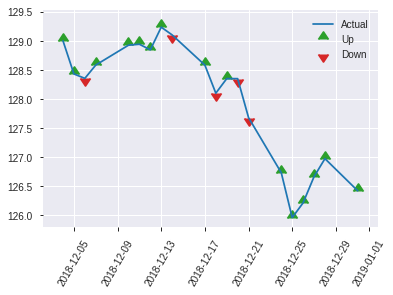


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.23345649952024006
RMSE: 0.48317336383563203
LogLoss: 0.6572641560057046
Mean Per-Class Error: 0.3468013468013468
AUC: 0.6626874808692991
pr_auc: 0.6536171788781425
Gini: 0.32537496173859815
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2574216025410845: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      12   123  0.9111   (123.0/135.0)
1      1    120  0.0083   (1.0/121.0)
Total  13   243  0.4844   (124.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.257422     0.659341  242
max f2                       0.257422     0.825309  242
max f0point5                 0.611703     0.653207  74
max accuracy                 0.611703     0.664062  74
max precision                0.767198     1         0
max recall                   0.178005     1         251
max specificity              0.767198     1         0
max absolute_mcc             0.611703     0.336105  74
max min_per_class_accuracy   0.545892     0.61157   123
max mean_per_class_accuracy  0.611703     0.653199  74

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 51.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.752463           2.1157    2.1157             1                0.765008  1                           0.765008            0.0247934       0.0247934                  111.57    111.57
    2        0.0234375                   0.739741           1.41047   1.76309            0.666667         0.742908  0.833333                    0.753958            0.0165289       0.0413223                  41.0468   76.3085
    3        0.03125                     0.726905           1.05785   1.58678            0.5              0.731518  0.75                        0.748348            0.00826446      0.0495868                  5.78512   58.6777
    4        0.0429688                   0.716937           2.1157    1.73103            1                0.724031  0.818182                    0.741716            0.0247934       0.0743802                  111.57    73.1029
    5        0.0507812                   0.707785           2.1157    1.79021            1                0.70928   0.846154                    0.736726            0.0165289       0.0909091                  111.57    79.021
    6        0.101562                    0.683047           1.62746   1.70884            0.769231         0.692432  0.807692                    0.714579            0.0826446       0.173554                   62.7463   70.8837
    7        0.152344                    0.657746           1.30197   1.57321            0.615385         0.670814  0.74359                     0.699991            0.0661157       0.239669                   30.1971   57.3215
    8        0.203125                    0.637268           1.79021   1.62746            0.846154         0.644948  0.769231                    0.68623             0.0909091       0.330579                   79.021    62.7463
    9        0.300781                    0.609738           1.26942   1.51122            0.6              0.621048  0.714286                    0.665067            0.123967        0.454545                   26.9421   51.1216
    10       0.402344                    0.57949            0.732359  1.31461            0.346154         0.594255  0.621359                    0.647192            0.0743802       0.528926                   -26.7641  31.4611
    11       0.5                         0.541001           0.930909  1.23967            0.44             0.56121   0.585938                    0.630399            0.0909091       0.619835                   -6.90909  23.9669
    12       0.601562                    0.509415           0.732359  1.15402            0.346154         0.525074  0.545455                    0.612617            0.0743802       0.694215                   -26.7641  15.402
    13       0.699219                    0.451989           0.846281  1.11104            0.4              0.484647  0.52514                     0.594744            0.0826446       0.77686                    -15.3719  11.1039
    14       0.800781                    0.390623           0.732359  1.06301            0.346154         0.421836  0.502439                    0.572814            0.0743802       0.85124                    -26.7641  6.30115
    15       0.898438                    0.322797           0.846281  1.03945            0.4              0.358853  0.491304                    0.549557            0.0826446       0.933884                   -15.3719  3.94538
    16       1                           0.0485951          0.650985  1                  0.307692         0.234354  0.472656                    0.517544            

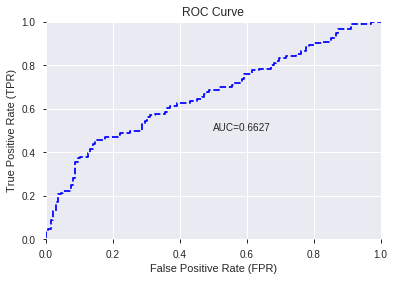

This function is available for GLM models only


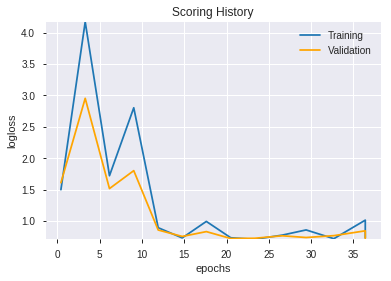

--2019-08-22 15:43:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  35.8MB/s    in 50s     

2019-08-22 15:44:17 (6.98 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unk

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_151725_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_151725_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_a7f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_154431_model_9  0.672299  0.668960              0.404010  0.488102  0.238243
1  DeepLearning_grid_1_AutoML_20190822_154431_model_8  0.634129  0.676930              0.435476  0.492790  0.242842
2  DeepLearning_grid_1_AutoML_20190822_154431_model_6  0.625467  0.699617              0.423232  0.498674  0.248676
3  DeepLearning_grid_1_AutoML_20190822_154431_model_7  0.612978  0.759887              0.481481  0.511994  0.262138
4  DeepLearning_grid_1_AutoML_20190822_154431_model_3  0.599694  0.795567              0.440465  0.504268  0.254286
5  DeepLearning_grid_1_AutoML_20190822_154431_model_4  0.598470  0.793176              0.406428  0.516935  0.267221
6  DeepLearning_grid_1_AutoML_20190822_154431_model_5  0.588613  0.705169              0.425222  0.503239  0.253249
7               DeepLearning_1_AutoML_20190822_154431  0.580227  0.747740              0.442179  0.513058  0.263228
8  DeepLearning_grid_1_AutoML_20190822_154431_model_2  0.578268  0.747799              0.437619  0.518533  0.268877
9  DeepLearning_grid_1_AutoML_20190822_154431_model_1  0.570370  1.026660              0.472084  0.530834  0.281784

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.048641
1                  SUB             0.789397           0.789397    0.038397
2                  DIV             0.750586           0.750586    0.036510
3         STOCHF_fastk             0.657753           0.657753    0.031994
4    CDLGRAVESTONEDOJI             0.594469           0.594469    0.028916
5                CCI_8             0.531935           0.531935    0.025874
6            CDLTAKURI             0.462904           0.462904    0.022516
7     CDLDRAGONFLYDOJI             0.462585           0.462585    0.022501
8       CDLRICKSHAWMAN             0.449676           0.449676    0.021873
9                  EXP             0.426667           0.426667    0.020754
10     CDLHOMINGPIGEON             0.414240           0.414240    0.020149
11                COSH             0.412417           0.412417    0.020061
12     CDLADVANCEBLOCK             0.411271           0.411271    0.020005
13      STOCHRSI_fastk             0.409270           0.409270    0.019907
14  CDLMORNINGDOJISTAR             0.408383           0.408383    0.019864
15      CDLMORNINGSTAR             0.404442           0.404442    0.019673
16   CDLDARKCLOUDCOVER             0.403043           0.403043    0.019605
17     CDLUNIQUE3RIVER             0.397602           0.397602    0.019340
18  CDLEVENINGDOJISTAR             0.397269           0.397269    0.019324
19   CDLLONGLEGGEDDOJI             0.393863           0.393863    0.019158
20                SINH             0.392190           0.392190    0.019077
21      CDL3LINESTRIKE             0.381848           0.381848    0.018574
22      CDLEVENINGSTAR             0.380423           0.380423    0.018504
23     CDLLADDERBOTTOM             0.375492           0.375492    0.018264
24           CDLONNECK             0.375181           0.375181    0.018249
25      is_quarter_end             0.373060           0.373060    0.018146
26           CORREL_30             0.372503           0.372503    0.018119
27             CDLDOJI             0.371954           0.371954    0.018092
28        CDLTHRUSTING             0.368178           0.368178    0.017909
29              SAREXT             0.366117           0.366117    0.017808
30   CDLSTALLEDPATTERN             0.365467           0.365467    0.017777
31  CDLSEPARATINGLINES             0.361796           0.361796    0.017598
32    is_quarter_start             0.360954           0.360954    0.017557
33      CDLMATCHINGLOW             0.355224           0.355224    0.017279
34        HT_TRENDMODE             0.349896           0.349896    0.017019
35   CDLINVERTEDHAMMER             0.349410           0.349410    0.016996
36     CDLSHOOTINGSTAR             0.348857           0.348857    0.016969
37           CORREL_20             0.346159           0.346159    0.016838
38      is_month_start             0.345931           0.345931    0.016827
39            CORREL_8             0.340572           0.340572    0.016566
40             quarter             0.340393           0.340393    0.016557
41        is_month_end             0.328904           0.328904    0.015998
42        CDLTASUKIGAP             0.326775           0.326775    0.015895
43           CDLHAMMER             0.324641           0.324641    0.015791
44       CDLHANGINGMAN             0.309025           0.309025    0.015031
45           dayofyear             0.308401           0.308401    0.015001
46         CDL3OUTSIDE             0.303172           0.303172    0.014747
47          weekofyear             0.298193           0.298193    0.014505
48                week             0.289346           0.289346    0.014074
49          CDL3INSIDE             0.270779           0.270779    0.013171

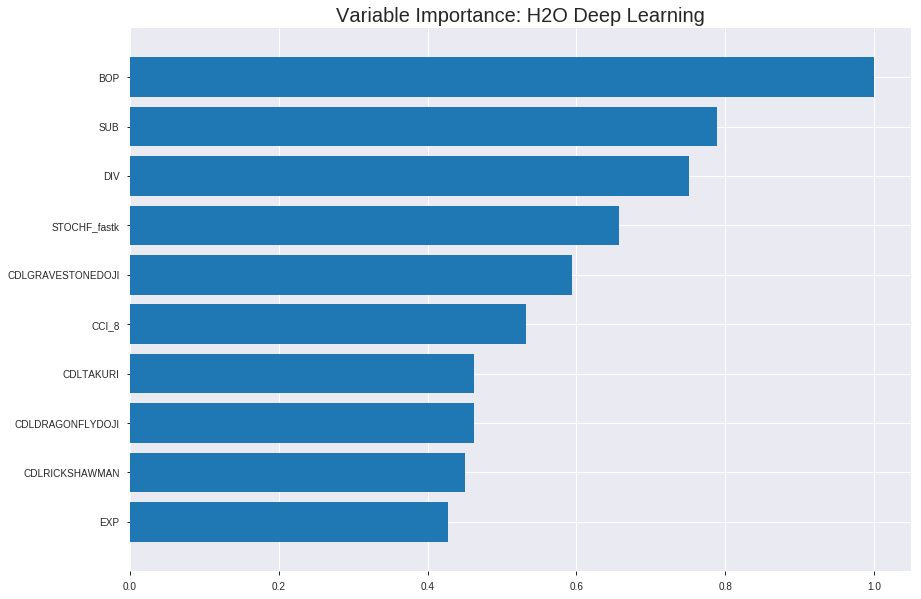

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_154431_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.22474621915498005
RMSE: 0.47407406505205496
LogLoss: 0.6396826425674672
Mean Per-Class Error: 0.3715875646967288
AUC: 0.6802857117799103
pr_auc: 0.6500814829519795
Gini: 0.3605714235598205
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3709057697097505: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      245  682   0.7357   (682.0/927.0)
1      49   812   0.0569   (49.0/861.0)
Total  294  1494  0.4088   (731.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.370906     0.689597  292
max f2                       0.305552     0.834653  332
max f0point5                 0.50472      0.613661  185
max accuracy                 0.50472      0.626957  185
max precision                0.871155     1         0
max recall                   0.223297     1         387
max specificity              0.871155     1         0
max absolute_mcc             0.414721     0.280735  265
max min_per_class_accuracy   0.505709     0.612729  182
max mean_per_class_accuracy  0.50472      0.628412  185

Gains/Lift Table: Avg response rate: 48.15 %, avg score: 48.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.799163           1.84592   1.84592            0.888889         0.817338  0.888889                    0.817338            0.018583        0.018583                   84.5916   84.5916
    2        0.0201342                   0.770869           1.84592   1.84592            0.888889         0.785424  0.888889                    0.801381            0.018583        0.0371661                  84.5916   84.5916
    3        0.0302013                   0.722412           1.73055   1.80746            0.833333         0.74875   0.87037                     0.783838            0.0174216       0.0545877                  73.0546   80.7459
    4        0.0402685                   0.696369           1.61518   1.75939            0.777778         0.709996  0.847222                    0.765377            0.0162602       0.0708479                  61.5176   75.9388
    5        0.0503356                   0.662257           1.49981   1.70747            0.722222         0.674545  0.822222                    0.747211            0.0150987       0.0859466                  49.9806   70.7472
    6        0.100112                    0.592735           1.44666   1.57779            0.696629         0.620716  0.759777                    0.684317            0.0720093       0.157956                   44.6659   57.7794
    7        0.150447                    0.565318           1.1537    1.4359             0.555556         0.575977  0.69145                     0.648069            0.058072        0.216028                   15.3697   43.5903
    8        0.200224                    0.550837           1.32999   1.40957            0.640449         0.558044  0.678771                    0.625689            0.0662021       0.28223                    32.9993   40.9573
    9        0.300336                    0.516635           1.11374   1.31096            0.536313         0.530576  0.631285                    0.593984            0.111498        0.393728                   11.3737   31.0961
    10       0.399888                    0.509516           1.23666   1.29246            0.595506         0.512321  0.622378                    0.573654            0.123113        0.516841                   23.666    29.2464
    11       0.5                         0.505535           1.04413   1.24274            0.502793         0.507408  0.598434                    0.56039             0.10453         0.62137                    4.41282   24.2741
    12       0.600112                    0.500913           0.986121  1.19993            0.47486          0.503598  0.577819                    0.550916            0.0987224       0.720093                   -1.38789  19.9931
    13       0.699664                    0.485488           1.00333   1.17196            0.483146         0.495459  0.564349                    0.543025            0.0998839       0.819977                   0.332772  17.1957
    14       0.799776                    0.402013           0.951317  1.14434            0.458101         0.447591  0.551049                    0.531079            0.0952381       0.915215                   -4.86832  14.4339
    15       0.899888                    0.304335           0.638078  1.08802            0.307263         0.351673  0.523928                    0.51112             0.0638792       0.979094                   -36.1922  8.80175
    16       1                           0.115705           0.208826  1                  0.100559         0.265503  0.481544                    0.486531         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24042846432122766
RMSE: 0.4903350531230943
LogLoss: 0.673049322113657
Mean Per-Class Error: 0.4086653386454183
AUC: 0.5943303708243948
pr_auc: 0.5556657375898619
Gini: 0.18866074164878954
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3107380669201452: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      22   238  0.9154   (238.0/260.0)
1      1    250  0.004    (1.0/251.0)
Total  23   488  0.4677   (239.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.310738     0.67659   376
max f2                       0.310738     0.837802  376
max f0point5                 0.499425     0.59274   278
max accuracy                 0.499619     0.587084  276
max precision                0.805722     1         0
max recall                   0.254062     1         395
max specificity              0.805722     1         0
max absolute_mcc             0.499425     0.208122  278
max min_per_class_accuracy   0.506404     0.553785  211
max mean_per_class_accuracy  0.499425     0.591335  278

Gains/Lift Table: Avg response rate: 49.12 %, avg score: 49.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.645472           1.69655   1.69655            0.833333         0.687707  0.833333                    0.687707            0.0199203       0.0199203                  69.6547   69.6547
    2        0.0215264                   0.629413           0.814343  1.29555            0.4              0.634738  0.636364                    0.66363             0.00796813      0.0278884                  -18.5657  29.5545
    3        0.0313112                   0.608863           0.814343  1.14517            0.4              0.615308  0.5625                      0.64853             0.00796813      0.0358566                  -18.5657  14.5169
    4        0.0410959                   0.60208            1.62869   1.26029            0.8              0.605366  0.619048                    0.638253            0.0159363       0.0517928                  62.8685   26.0292
    5        0.0508806                   0.594081           0.814343  1.17453            0.4              0.597518  0.576923                    0.630419            0.00796813      0.059761                   -18.5657  17.4533
    6        0.101761                    0.567751           1.01793   1.09623            0.5              0.57786   0.538462                    0.604139            0.0517928       0.111554                   1.79283   9.62305
    7        0.150685                    0.552352           1.14008   1.11047            0.56             0.561358  0.545455                    0.590249            0.0557769       0.167331                   14.008    11.0467
    8        0.201566                    0.534513           1.40944   1.18594            0.692308         0.544364  0.582524                    0.578667            0.0717131       0.239044                   40.9439   18.5936
    9        0.30137                     0.515498           1.15764   1.17657            0.568627         0.521201  0.577922                    0.559636            0.115538        0.354582                   15.7644   17.6566
    10       0.401174                    0.509506           0.918131  1.11227            0.45098          0.511722  0.546341                    0.547716            0.0916335       0.446215                   -8.18686  11.2273
    11       0.500978                    0.506359           1.07781   1.10541            0.529412         0.507973  0.542969                    0.539798            0.10757         0.553785                   7.78064   10.5406
    12       0.600783                    0.504241           1.03789   1.09419            0.509804         0.505202  0.537459                    0.534051            0.103586        0.657371                   3.78877   9.419
    13       0.700587                    0.501517           1.2774    1.12029            0.627451         0.503102  0.550279                    0.529642            0.12749         0.784861                   27.74     12.029
    14       0.800391                    0.493508           0.918131  1.09508            0.45098          0.498078  0.537897                    0.525706            0.0916335       0.876494                   -8.18686  9.50818
    15       0.900196                    0.364536           0.678619  1.04891            0.333333         0.437829  0.515217                    0.515964            0.0677291       0.944223                   -32.1381  4.89087
    16       1                           0.130551           0.558863  1                  0.27451          0.306949  0.491194                    0.495103            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 15:51:24  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 15:51:26  2 min 36.358 sec  491 obs/sec       0.558166  1             998        0.554476         0.860771            -0.231453      0.602283        0.553174           1.26907          0.456376                         0.551754           0.836711              -0.21811         0.581497          0.530005             1.01793            0.465753
    2019-08-22 15:51:37  2 min 46.620 sec  796 obs/sec       5.02685   9             8988       0.485622         0.663517            0.0553975      0.643547        0.593059           1.38444          0.426734                         0.492339           0.677289              0.0301065        0.606865          0.575202             1.35724            0.469667
    2019-08-22 15:51:47  2 min 56.752 sec  835 obs/sec       9.54195   17            17061      0.490441         0.673936            0.0365587      0.651896        0.599491           1.49981          0.41387                          0.49764            0.688357              0.00910949       0.577797          0.553014             1.35724            0.463796
    2019-08-22 15:51:57  3 min  6.832 sec  948 obs/sec       15.651    28            27984      0.479109         0.650371            0.0805649      0.658846        0.622649           1.61518          0.41387                          0.491627           0.675907              0.0329105        0.595288          0.557984             1.01793            0.463796
    2019-08-22 15:52:07  3 min 16.941 sec  1032 obs/sec      22.335    40            39935      0.480047         0.652723            0.0769635      0.670584        0.630387           1.84592          0.408277                         0.491475           0.675703              0.033511         0.607692          0.575915             1.35724            0.471624
    2019-08-22 15:52:17  3 min 27.239 sec  1104 obs/sec      29.6219   53            52964      0.478747         0.649723            0.081956       0.679872        0.648607           1.84592          0.410515                         0.493342           0.67937               0.0261519        0.604988          0.563723             1.69655            0.432485
    2019-08-22 15:52:28  3 min 37.530 sec  1168 obs/sec      37.4295   67            66924      0.474074         0.639683            0.0997885      0.680286        0.650081           1.84592          0.408837                         0.490335           0.673049              0.0379877        0.59433           0.555666             1.69655            0.46771

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
BOP                1.0                    1.0                  0.04864140946232579
SUB                0.7893974184989929     0.7893974184989929   0.038397403061712465
DIV                0.750586211681366      0.750586211681366    0.03650957125916927
STOCHF_fastk       0.6577528715133667     0.6577528715133667   0.031994026748302234
CDLGRAVESTONEDOJI  0.594469428062439      0.594469428062439    0.02891583086321972
---                ---                    ---                  ---
dayofyear          0.3084007501602173     0.3084007501602173   0.015001047167031566
CDL3OUTSIDE        0.3031717538833618     0.3031717538833618   0.014746701418052061
weekofyear         0.2981933057308197     0.2981933057308197   0.0145045426829773
week               0.28934645652770996    0.28934645652770996  0.01407421946843739
CDL3INSIDE         0.270779013633728      0.270779013633728    0.013171072875962864


See the whole table with table.as_data_frame()


('accuracy', 0.65625)

('F1', 0.65814696485623)

('auc', 0.6722987450260177)

('logloss', 0.6689597275198915)

('mean_per_class_error', 0.34606672788490966)

('rmse', 0.48810162820509473)

('mse', 0.23824319945646455)

deeplearning prediction progress: |███████████████████████████████████████| 100%


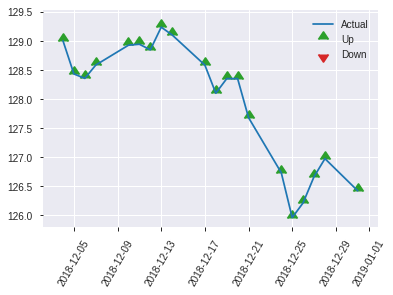


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.23824319945646455
RMSE: 0.48810162820509473
LogLoss: 0.6689597275198915
Mean Per-Class Error: 0.34606672788490966
AUC: 0.6722987450260177
pr_auc: 0.6327732439713464
Gini: 0.34459749005203544
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5000186208395447: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      46   89   0.6593   (89.0/135.0)
1      18   103  0.1488   (18.0/121.0)
Total  64   192  0.418    (107.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.500019     0.658147  191
max f2                       0.28266      0.820896  252
max f0point5                 0.510303     0.637523  106
max accuracy                 0.510303     0.65625   106
max precision                0.73186      1         0
max recall                   0.28266      1         252
max specificity              0.73186      1         0
max absolute_mcc             0.509101     0.309004  114
max min_per_class_accuracy   0.508351     0.637037  126
max mean_per_class_accuracy  0.509101     0.653933  114

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 50.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.686191           2.1157    2.1157             1                0.715512  1                           0.715512            0.0247934       0.0247934                  111.57    111.57
    2        0.0234375                   0.639978           1.41047   1.76309            0.666667         0.655327  0.833333                    0.685419            0.0165289       0.0413223                  41.0468   76.3085
    3        0.03125                     0.613712           0         1.32231            0                0.618947  0.625                       0.668801            0               0.0413223                  -100      32.2314
    4        0.0429688                   0.60952            1.41047   1.34636            0.666667         0.611607  0.636364                    0.653203            0.0165289       0.0578512                  41.0468   34.6356
    5        0.0507812                   0.602905           1.05785   1.30197            0.5              0.605611  0.615385                    0.645881            0.00826446      0.0661157                  5.78512   30.1971
    6        0.101562                    0.56722            1.79021   1.54609            0.846154         0.580017  0.730769                    0.612949            0.0909091       0.157025                   79.021    54.609
    7        0.152344                    0.55965            1.46472   1.51897            0.692308         0.563196  0.717949                    0.596365            0.0743802       0.231405                   46.4717   51.8966
    8        0.203125                    0.545487           1.62746   1.54609            0.769231         0.552071  0.730769                    0.585291            0.0826446       0.31405                    62.7463   54.609
    9        0.300781                    0.517568           1.10017   1.40131            0.52             0.532771  0.662338                    0.568239            0.107438        0.421488                   10.0165   40.1309
    10       0.402344                    0.510723           1.30197   1.37623            0.615385         0.513795  0.650485                    0.554496            0.132231        0.553719                   30.1971   37.6234
    11       0.5                         0.507939           0.930909  1.28926            0.44             0.509209  0.609375                    0.545651            0.0909091       0.644628                   -6.90909  28.9256
    12       0.601562                    0.505931           0.650985  1.1815             0.307692         0.506828  0.558442                    0.539096            0.0661157       0.710744                   -34.9015  18.1496
    13       0.699219                    0.502771           0.846281  1.13468            0.4              0.50465   0.536313                    0.534285            0.0826446       0.793388                   -15.3719  13.4678
    14       0.800781                    0.49452            0.895105  1.10429            0.423077         0.499215  0.521951                    0.529837            0.0909091       0.884298                   -10.4895  10.4293
    15       0.898438                    0.441298           0.677025  1.05785            0.32             0.480187  0.5                         0.524441            0.0661157       0.950413                   -32.2975  5.78512
    16       1                           0.244046           0.488239  1                  0.230769         0.358092  0.472656                    0.507546            

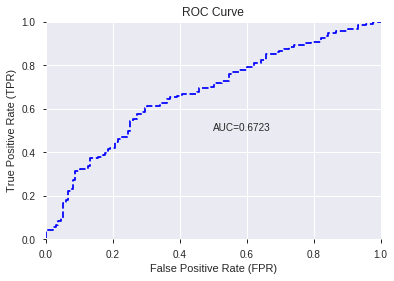

This function is available for GLM models only


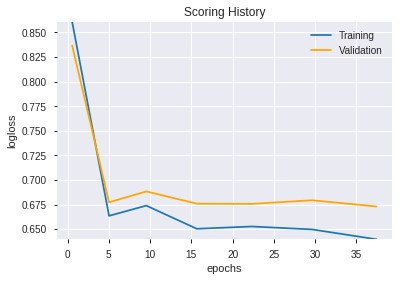

--2019-08-22 15:52:36--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.81.200
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.81.200|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_154431_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_154431_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_a7f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'SUB',
 'DIV',
 'STOCHF_fastk',
 'CDLGRAVESTONEDOJI',
 'CCI_8',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'CDLRICKSHAWMAN',
 'EXP',
 'CDLHOMINGPIGEON',
 'COSH',
 'CDLADVANCEBLOCK',
 'STOCHRSI_fastk',
 'CDLMORNINGDOJISTAR',
 'CDLMORNINGSTAR',
 'CDLDARKCLOUDCOVER',
 'CDLUNIQUE3RIVER',
 'CDLEVENINGDOJISTAR',
 'CDLLONGLEGGEDDOJI',
 'SINH',
 'CDL3LINESTRIKE',
 'CDLEVENINGSTAR',
 'CDLLADDERBOTTOM',
 'CDLONNECK',
 'is_quarter_end',
 'CORREL_30',
 'CDLDOJI',
 'CDLTHRUSTING',
 'SAREXT',
 'CDLSTALLEDPATTERN',
 'CDLSEPARATINGLINES',
 'is_quarter_start',
 'CDLMATCHINGLOW',
 'HT_TRENDMODE',
 'CDLINVERTEDHAMMER',
 'CDLSHOOTINGSTAR',
 'CORREL_20',
 'is_month_start',
 'CORREL_8',
 'quarter',
 'is_month_end',
 'CDLTASUKIGAP',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'dayofyear',
 'CDL3OUTSIDE',
 'weekofyear',
 'week',
 'CDL3INSIDE']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_155248_model_1  0.651056  0.663973              0.422804  0.484926  0.235153

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.334978           1.000000    0.099953
1         STOCHF_fastk             0.324023           0.967298    0.096684
2                CCI_8             0.203713           0.608140    0.060785
3    CDLGRAVESTONEDOJI             0.188388           0.562390    0.056212
4                  SUB             0.163562           0.488278    0.048805
5       STOCHRSI_fastk             0.153147           0.457185    0.045697
6           CDL3INSIDE             0.129013           0.385140    0.038496
7    CDLSTALLEDPATTERN             0.122612           0.366029    0.036586
8                  DIV             0.106407           0.317653    0.031750
9   CDLMORNINGDOJISTAR             0.103571           0.309189    0.030904
10        CDLTASUKIGAP             0.099481           0.296979    0.029684
11      CDLMORNINGSTAR             0.099452           0.296891    0.029675
12      CDLRICKSHAWMAN             0.085847           0.256275    0.025615
13   CDLLONGLEGGEDDOJI             0.077549           0.231504    0.023139
14           CDLONNECK             0.068695           0.205074    0.020498
15      is_month_start             0.067511           0.201540    0.020144
16        CDLTHRUSTING             0.067499           0.201504    0.020141
17   CDLINVERTEDHAMMER             0.066056           0.197194    0.019710
18           CORREL_20             0.063255           0.188834    0.018874
19  CDLSEPARATINGLINES             0.059507           0.177645    0.017756
20           CDLTAKURI             0.055364           0.165277    0.016520
21       CDLHANGINGMAN             0.052091           0.155504    0.015543
22  CDLEVENINGDOJISTAR             0.051951           0.155088    0.015501
23      CDL3LINESTRIKE             0.047340           0.141323    0.014126
24      CDLEVENINGSTAR             0.047271           0.141117    0.014105
25         CDL3OUTSIDE             0.046811           0.139743    0.013968
26            CORREL_8             0.045630           0.136217    0.013615
27     CDLSHOOTINGSTAR             0.041941           0.125206    0.012515
28             quarter             0.040861           0.121982    0.012192
29      is_quarter_end             0.039628           0.118301    0.011824
30     CDLUNIQUE3RIVER             0.031563           0.094224    0.009418
31             CDLDOJI             0.029272           0.087384    0.008734
32     CDLHOMINGPIGEON             0.026716           0.079755    0.007972
33           CORREL_30             0.026238           0.078328    0.007829
34     CDLLADDERBOTTOM             0.023913           0.071388    0.007135
35           CDLHAMMER             0.020680           0.061736    0.006171
36              SAREXT             0.017363           0.051835    0.005181
37                COSH             0.015928           0.047549    0.004753
38                 EXP             0.015820           0.047228    0.004721
39                SINH             0.015770           0.047077    0.004705
40        HT_TRENDMODE             0.014460           0.043167    0.004315
41           dayofyear             0.013773           0.041115    0.004110
42     CDLADVANCEBLOCK             0.011697           0.034919    0.003490
43    is_quarter_start             0.009533           0.028458    0.002844
44          weekofyear             0.005970           0.017822    0.001781
45    CDLDRAGONFLYDOJI             0.005721           0.017078    0.001707
46                week             0.005585           0.016673    0.001667
47   CDLDARKCLOUDCOVER             0.005043           0.015053    0.001505
48      CDLMATCHINGLOW             0.003096           0.009243    0.000924
49        is_month_end             0.000073           0.000217    0.000022

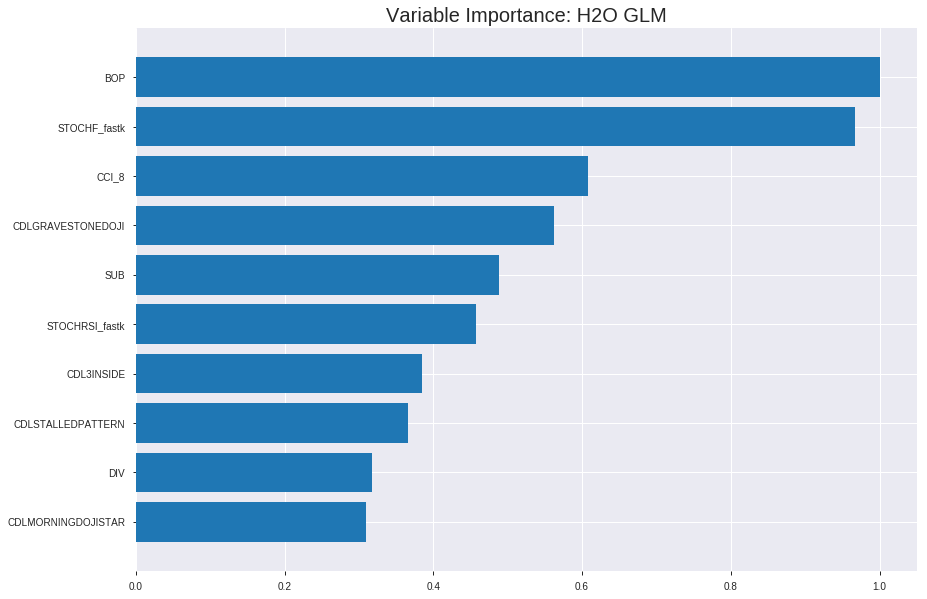

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_155248_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.22639411773004092
RMSE: 0.4758089088384547
LogLoss: 0.6420755551285267
Null degrees of freedom: 1787
Residual degrees of freedom: 1737
Null deviance: 2476.257522519208
Residual deviance: 2296.062185139611
AIC: 2398.062185139611
AUC: 0.6688886884245634
pr_auc: 0.624496946108301
Gini: 0.3377773768491268
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33670070850388645: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      208  719   0.7756   (719.0/927.0)
1      29   832   0.0337   (29.0/861.0)
Total  237  1551  0.4183   (748.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.336701     0.689884  310
max f2                       0.324598     0.836479  318
max f0point5                 0.450221     0.605634  225
max accuracy                 0.479284     0.61689   201
max precision                0.978292     1         0
max recall                   0.169489     1         381
max specificity              0.978292     1         0
max absolute_mcc             0.36414      0.281138  291
max min_per_class_accuracy   0.493654     0.609493  188
max mean_per_class_accuracy  0.450221     0.620519  225

Gains/Lift Table: Avg response rate: 48.15 %, avg score: 48.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.809238           1.96129   1.96129            0.944444         0.887048  0.944444                    0.887048            0.0197445       0.0197445                  96.1285   96.1285
    2        0.0201342                   0.754266           1.26907   1.61518            0.611111         0.77866   0.777778                    0.832854            0.0127758       0.0325203                  26.9067   61.5176
    3        0.0302013                   0.71812            1.49981   1.57672            0.722222         0.736871  0.759259                    0.80086             0.0150987       0.047619                   49.9806   57.672
    4        0.0402685                   0.695532           1.49981   1.55749            0.722222         0.706984  0.75                        0.777391            0.0150987       0.0627178                  49.9806   55.7491
    5        0.0503356                   0.681112           1.38444   1.52288            0.666667         0.687501  0.733333                    0.759413            0.0139373       0.0766551                  38.4437   52.288
    6        0.100112                    0.638373           1.30666   1.41537            0.629213         0.658783  0.681564                    0.709379            0.0650407       0.141696                   30.6659   41.5374
    7        0.150447                    0.599388           1.36136   1.3973             0.655556         0.618033  0.672862                    0.678817            0.068525        0.210221                   36.1363   39.7303
    8        0.200224                    0.578614           1.18999   1.34577            0.573034         0.588968  0.648045                    0.656481            0.0592334       0.269454                   18.9993   34.5765
    9        0.300336                    0.547137           1.18335   1.29163            0.569832         0.561961  0.621974                    0.624974            0.118467        0.387921                   18.3345   29.1625
    10       0.399888                    0.519134           1.16666   1.26052            0.561798         0.533839  0.606993                    0.602286            0.116144        0.504065                   16.666    26.0515
    11       0.5                         0.491601           1.11374   1.23113            0.536313         0.505622  0.592841                    0.582931            0.111498        0.615563                   11.3737   23.1127
    12       0.600112                    0.458986           1.04413   1.19993            0.502793         0.476004  0.577819                    0.565094            0.10453         0.720093                   4.41282   19.9931
    13       0.699664                    0.423933           1.00333   1.17196            0.483146         0.441577  0.564349                    0.547519            0.0998839       0.819977                   0.332772  17.1957
    14       0.799776                    0.375362           0.939715  1.14289            0.452514         0.401317  0.55035                     0.529218            0.0940767       0.914053                   -6.02846  14.2886
    15       0.899888                    0.315248           0.64968   1.08802            0.312849         0.347422  0.523928                    0.508993            0.0650407       0.979094                   -35.032   8.80175
    16       1                           0.0126875          0.208826  1                  0.100559         0.234802  0.481544                    0.481544           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.23696079508001625
RMSE: 0.4867861903135875
LogLoss: 0.6665760950436425
Null degrees of freedom: 510
Residual degrees of freedom: 460
Null deviance: 708.4284254426307
Residual deviance: 681.2407691346026
AIC: 783.2407691346026
AUC: 0.624402390438247
pr_auc: 0.5970774897592921
Gini: 0.24880478087649394
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39736351440700035: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      61   199  0.7654   (199.0/260.0)
1      22   229  0.0876   (22.0/251.0)
Total  83   428  0.4325   (221.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.397364     0.674521  326
max f2                       0.292012     0.832778  386
max f0point5                 0.454108     0.597148  271
max accuracy                 0.529342     0.594912  153
max precision                0.959408     1         0
max recall                   0.230097     1         395
max specificity              0.959408     1         0
max absolute_mcc             0.454108     0.214978  271
max min_per_class_accuracy   0.503258     0.589641  200
max mean_per_class_accuracy  0.454108     0.598475  271

Gains/Lift Table: Avg response rate: 49.12 %, avg score: 49.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.756832           1.69655   1.69655            0.833333         0.90689   0.833333                    0.90689             0.0199203       0.0199203                  69.6547   69.6547
    2        0.0215264                   0.710221           1.22151   1.48062            0.6              0.725744  0.727273                    0.824551            0.0119522       0.0318725                  22.1514   48.0623
    3        0.0313112                   0.689157           2.03586   1.65413            1                0.696149  0.8125                      0.784425            0.0199203       0.0517928                  103.586   65.4133
    4        0.0410959                   0.672888           1.62869   1.64807            0.8              0.68067   0.809524                    0.759722            0.0159363       0.0677291                  62.8685   64.8074
    5        0.0508806                   0.660877           1.22151   1.56604            0.6              0.666522  0.769231                    0.741799            0.0119522       0.0796813                  22.1514   56.6044
    6        0.101761                    0.623031           1.25283   1.40944            0.615385         0.637378  0.692308                    0.689588            0.063745        0.143426                   25.2835   40.9439
    7        0.150685                    0.599268           0.895777  1.24267            0.44             0.610153  0.61039                     0.663798            0.0438247       0.187251                   -10.4223  24.2666
    8        0.201566                    0.582741           1.17453   1.22547            0.576923         0.590536  0.601942                    0.645304            0.059761        0.247012                   17.4533   22.5467
    9        0.30137                     0.54764            1.11773   1.18979            0.54902          0.564281  0.584416                    0.618472            0.111554        0.358566                   11.7725   18.9786
    10       0.401174                    0.524125           1.31732   1.22151            0.647059         0.535448  0.6                         0.597817            0.131474        0.49004                    31.7319   22.1514
    11       0.500978                    0.499134           1.03789   1.18493            0.509804         0.513915  0.582031                    0.581102            0.103586        0.593625                   3.78877   18.4932
    12       0.600783                    0.479065           0.878213  1.13398            0.431373         0.489059  0.557003                    0.565812            0.0876494       0.681275                   -12.1787  13.3979
    13       0.700587                    0.454108           1.19756   1.14304            0.588235         0.467597  0.561453                    0.55182             0.119522        0.800797                   19.7563   14.3037
    14       0.800391                    0.416298           0.718538  1.0901             0.352941         0.436171  0.535452                    0.537399            0.0717131       0.87251                    -28.1462  9.01041
    15       0.900196                    0.358565           0.718538  1.04891            0.352941         0.388183  0.515217                    0.520856            0.0717131       0.944223                   -28.1462  4.89087
    16       1                           0.0175589          0.558863  1                  0.27451          0.304915  0.491194                    0.499304         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-22 15:52:48  0.000 sec   2            8.2       50            1.37738           1.38099
    2019-08-22 15:52:48  0.049 sec   4            5.1       50            1.37341           1.37824
    2019-08-22 15:52:48  0.086 sec   6            3.2       51            1.36781           1.37445
    2019-08-22 15:52:48  0.129 sec   8            2         51            1.3604            1.36959
    2019-08-22 15:52:49  0.169 sec   10           1.2       51            1.35127           1.36389
    2019-08-22 15:52:49  0.217 sec   12           0.76      51            1.34094           1.35786
    2019-08-22 15:52:49  0.260 sec   14           0.47      51            1.33017           1.35207
    2019-08-22 15:52:49  0.298 sec   16           0.29      51            1.3197            1.34692
    2019-08-22 15:52:49  0.340 sec   18           0.18      51            1.31006           1.34252
    2019-08-22 15:52:49  0.386 sec   20           0.11      51            1.30156           1.33886
    2019-08-22 15:52:49  0.421 sec   22           0.07      51            1.29436           1.33598
    2019-08-22 15:52:49  0.466 sec   24           0.043     51            1.28856           1.33402
    2019-08-22 15:52:49  0.502 sec   26           0.027     51            1.28415           1.33315
    2019-08-22 15:52:49  0.533 sec   28           0.017     51            1.28104           1.33335
    2019-08-22 15:52:49  0.558 sec   30           0.01      51            1.27899           1.3344
    2019-08-22 15:52:49  0.586 sec   32           0.0065    51            1.27769           1.33601
    2019-08-22 15:52:49  0.612 sec   34           0.004     51            1.27686           1.33788
    2019-08-22 15:52:49  0.629 sec   35           0.0025    51            1.27632           1.33965

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.625)

('F1', 0.6626865671641791)

('auc', 0.6510560146923783)

('logloss', 0.6639733420349365)

('mean_per_class_error', 0.3746862565044383)

('rmse', 0.4849259490662816)

('mse', 0.23515317607783393)

glm prediction progress: |████████████████████████████████████████████████| 100%


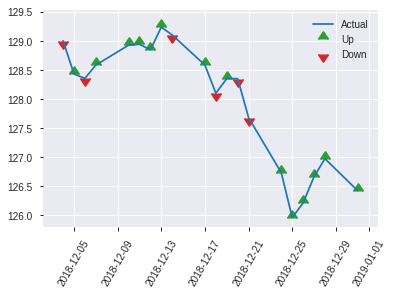


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.23515317607783393
RMSE: 0.4849259490662816
LogLoss: 0.6639733420349365
Null degrees of freedom: 255
Residual degrees of freedom: 205
Null deviance: 354.20638056124005
Residual deviance: 339.9543511218875
AIC: 441.9543511218875
AUC: 0.6510560146923783
pr_auc: 0.5933480144957912
Gini: 0.30211202938475656
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41333591617685195: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      32   103  0.763    (103.0/135.0)
1      10   111  0.0826   (10.0/121.0)
Total  42   214  0.4414   (113.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.413336     0.662687  213
max f2                       0.287299     0.820896  252
max f0point5                 0.519308     0.603015  118
max accuracy                 0.524601     0.625     112
max precision                0.930052     1         0
max recall                   0.287299     1         252
max specificity              0.930052     1         0
max absolute_mcc             0.487455     0.252764  145
max min_per_class_accuracy   0.510286     0.614815  126
max mean_per_class_accuracy  0.487455     0.625314  145

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 50.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.76762            0.705234  0.705234           0.333333         0.880756  0.333333                    0.880756            0.00826446      0.00826446                 -29.4766  -29.4766
    2        0.0234375                   0.689603           1.41047   1.05785            0.666667         0.701287  0.5                         0.791021            0.0165289       0.0247934                  41.0468   5.78512
    3        0.03125                     0.687089           1.05785   1.05785            0.5              0.687819  0.5                         0.765221            0.00826446      0.0330579                  5.78512   5.78512
    4        0.0429688                   0.670937           2.1157    1.34636            1                0.677249  0.636364                    0.741229            0.0247934       0.0578512                  111.57    34.6356
    5        0.0507812                   0.664563           2.1157    1.46472            1                0.667549  0.692308                    0.729893            0.0165289       0.0743802                  111.57    46.4717
    6        0.101562                    0.623087           1.62746   1.54609            0.769231         0.647469  0.730769                    0.688681            0.0826446       0.157025                   62.7463   54.609
    7        0.152344                    0.598546           1.46472   1.51897            0.692308         0.611102  0.717949                    0.662821            0.0743802       0.231405                   46.4717   51.8966
    8        0.203125                    0.574363           0.976478  1.38334            0.461538         0.587503  0.653846                    0.643992            0.0495868       0.280992                   -2.35219  38.3344
    9        0.300781                    0.554463           1.01554   1.26393            0.48             0.56419   0.597403                    0.618082            0.0991736       0.380165                   1.55372   26.3926
    10       0.402344                    0.533977           1.30197   1.27353            0.615385         0.543679  0.601942                    0.599301            0.132231        0.512397                   30.1971   27.353
    11       0.5                         0.510254           1.18479   1.2562             0.56             0.52218   0.59375                     0.584238            0.115702        0.628099                   18.4793   25.6198
    12       0.601562                    0.479316           0.895105  1.19523            0.423077         0.493874  0.564935                    0.568982            0.0909091       0.719008                   -10.4895  19.5235
    13       0.699219                    0.453521           0.761653  1.13468            0.36             0.468529  0.536313                    0.554952            0.0743802       0.793388                   -23.8347  13.4678
    14       0.800781                    0.425435           0.976478  1.11461            0.461538         0.439067  0.526829                    0.540254            0.0991736       0.892562                   -2.35219  11.4614
    15       0.898438                    0.380607           0.592397  1.05785            0.28             0.402698  0.5                         0.525303            0.0578512       0.950413                   -40.7603  5.78512
    16       1                           0.101116           0.488239  1                  0.230769         0.323128  0.472656                    0.504769          

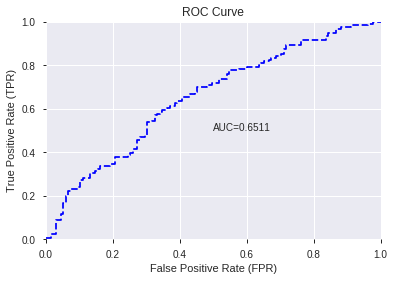

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


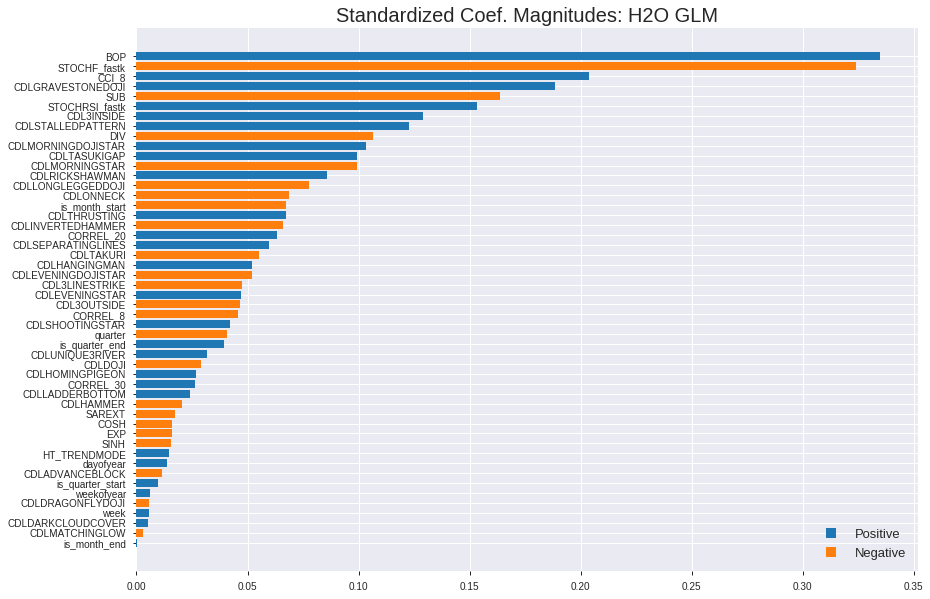

'log_likelihood'
--2019-08-22 15:52:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.138.4
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.138.4|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_155248_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_155248_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_a7f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'STOCHF_fastk',
 'CCI_8',
 'CDLGRAVESTONEDOJI',
 'SUB',
 'STOCHRSI_fastk',
 'CDL3INSIDE',
 'CDLSTALLEDPATTERN',
 'DIV',
 'CDLMORNINGDOJISTAR',
 'CDLTASUKIGAP',
 'CDLMORNINGSTAR',
 'CDLRICKSHAWMAN',
 'CDLLONGLEGGEDDOJI',
 'CDLONNECK',
 'is_month_start',
 'CDLTHRUSTING',
 'CDLINVERTEDHAMMER',
 'CORREL_20',
 'CDLSEPARATINGLINES',
 'CDLTAKURI',
 'CDLHANGINGMAN',
 'CDLEVENINGDOJISTAR',
 'CDL3LINESTRIKE',
 'CDLEVENINGSTAR',
 'CDL3OUTSIDE',
 'CORREL_8',
 'CDLSHOOTINGSTAR',
 'quarter',
 'is_quarter_end',
 'CDLUNIQUE3RIVER',
 'CDLDOJI',
 'CDLHOMINGPIGEON',
 'CORREL_30',
 'CDLLADDERBOTTOM',
 'CDLHAMMER',
 'SAREXT',
 'COSH',
 'EXP',
 'SINH',
 'HT_TRENDMODE',
 'dayofyear',
 'CDLADVANCEBLOCK',
 'is_quarter_start',
 'weekofyear',
 'CDLDRAGONFLYDOJI',
 'week',
 'CDLDARKCLOUDCOVER',
 'CDLMATCHINGLOW',
 'is_month_end']

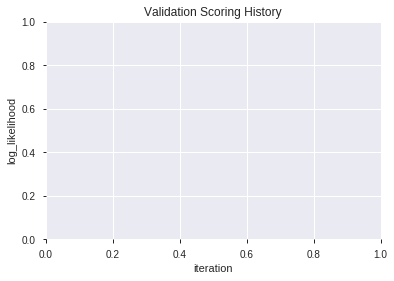

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190822_155304  0.705663  0.643579              0.340618  0.475337  0.225945
1               XGBoost_3_AutoML_20190822_155304  0.696602  0.647946              0.346740  0.477590  0.228093
2  XGBoost_grid_1_AutoML_20190822_155304_model_2  0.695439  0.649661              0.361126  0.478285  0.228757
3  XGBoost_grid_1_AutoML_20190822_155304_model_7  0.694949  0.647211              0.381359  0.477296  0.227812
4  XGBoost_grid_1_AutoML_20190822_155304_model_6  0.679400  0.654358              0.392317  0.480833  0.231200
5  XGBoost_grid_1_AutoML_20190822_155304_model_5  0.675421  0.663124              0.382492  0.484635  0.234871
6  XGBoost_grid_1_AutoML_20190822_155304_model_1  0.670830  0.655435              0.442455  0.481425  0.231770
7  XGBoost_grid_1_AutoML_20190822_155304_model_4  0.667585  0.657075              0.396021  0.482073  0.232394
8  XGBoost_grid_1_AutoML_20190822_155304_model_3  0.662381  0.660279              0.421518  0.483892  0.234151
9               XGBoost_2_AutoML_20190822_155304  0.646954  0.668206              0.377227  0.487474  0.237631

variable  relative_importance  scaled_importance  percentage
0                 BOP           673.511841           1.000000    0.103646
1                 SUB           638.894043           0.948601    0.098319
2        STOCHF_fastk           604.212158           0.897107    0.092982
3               CCI_8           598.643494           0.888839    0.092125
4           CORREL_30           529.530029           0.786222    0.081489
5            CORREL_8           488.789032           0.725732    0.075219
6                 DIV           453.092529           0.672731    0.069726
7           CORREL_20           428.238831           0.635830    0.065901
8           dayofyear           392.740936           0.583124    0.060439
9                COSH           387.154785           0.574830    0.059579
10     STOCHRSI_fastk           296.727692           0.440568    0.045663
11             SAREXT           291.114624           0.432234    0.044799
12                EXP           114.793243           0.170440    0.017665
13  CDLGRAVESTONEDOJI           103.357071           0.153460    0.015906
14               week            94.614334           0.140479    0.014560
15   CDLDRAGONFLYDOJI            78.830414           0.117044    0.012131
16         weekofyear            75.794632           0.112536    0.011664
17            CDLDOJI            50.854103           0.075506    0.007826
18     CDLRICKSHAWMAN            48.701824           0.072310    0.007495
19          CDLTAKURI            39.524189           0.058684    0.006082
20       HT_TRENDMODE            34.101120           0.050632    0.005248
21               SINH            30.602978           0.045438    0.004709
22            quarter            22.758089           0.033790    0.003502
23  CDLLONGLEGGEDDOJI            18.324564           0.027207    0.002820
24       is_month_end             3.269386           0.004854    0.000503

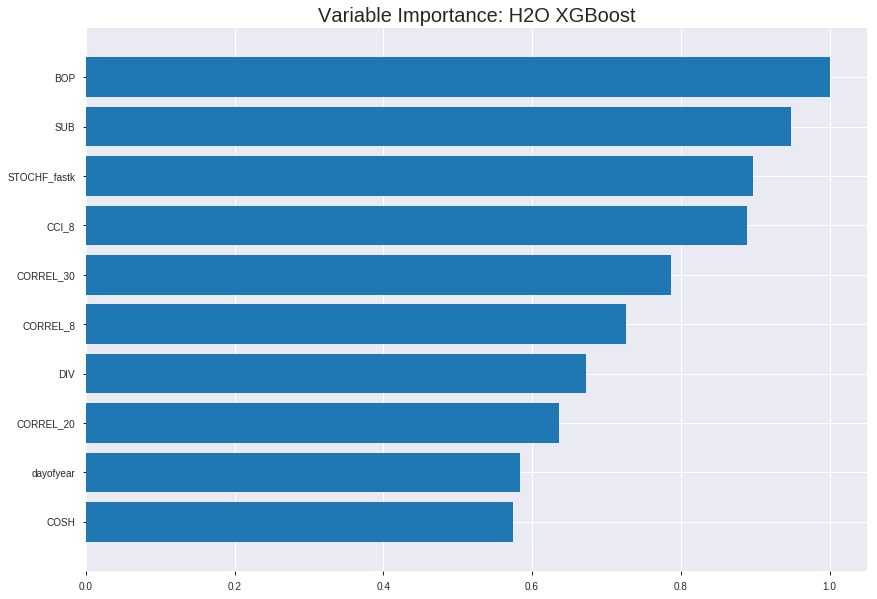

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190822_155304


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16309684393675303
RMSE: 0.40385250269962797
LogLoss: 0.5084688473642837
Mean Per-Class Error: 0.16577773267330453
AUC: 0.9126432850089018
pr_auc: 0.909163228918918
Gini: 0.8252865700178036
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.487662007411321: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      751  176  0.1899   (176.0/927.0)
1      122  739  0.1417   (122.0/861.0)
Total  873  915  0.1667   (298.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.487662     0.832207  196
max f2                       0.37743      0.886876  271
max f0point5                 0.555674     0.84501   148
max accuracy                 0.514152     0.833333  177
max precision                0.863999     1         0
max recall                   0.191639     1         373
max specificity              0.863999     1         0
max absolute_mcc             0.487662     0.668173  196
max min_per_class_accuracy   0.50323      0.829268  185
max mean_per_class_accuracy  0.487662     0.834222  196

Gains/Lift Table: Avg response rate: 48.15 %, avg score: 48.26 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.782169           2.07666    2.07666            1                0.801342  1                           0.801342            0.0209059       0.0209059                  107.666   107.666
    2        0.0201342                   0.756284           2.07666    2.07666            1                0.772241  1                           0.786792            0.0209059       0.0418118                  107.666   107.666
    3        0.0302013                   0.742188           2.07666    2.07666            1                0.750084  1                           0.774556            0.0209059       0.0627178                  107.666   107.666
    4        0.0402685                   0.734003           2.07666    2.07666            1                0.738303  1                           0.765493            0.0209059       0.0836237                  107.666   107.666
    5        0.0503356                   0.723055           2.07666    2.07666            1                0.726866  1                           0.757767            0.0209059       0.10453                    107.666   107.666
    6        0.100112                    0.685242           1.98332    2.03025            0.955056         0.703899  0.977654                    0.730984            0.0987224       0.203252                   98.3322   103.025
    7        0.150447                    0.658946           2.03051    2.03034            0.977778         0.671781  0.977695                    0.711176            0.102207        0.305459                   103.051   103.034
    8        0.200224                    0.637866           2.00666    2.02445            0.966292         0.64947   0.97486                     0.695836            0.0998839       0.405343                   100.666   102.445
    9        0.300336                    0.587498           1.71701    1.92197            0.826816         0.61127   0.925512                    0.667647            0.171893        0.577236                   71.7011   92.1969
    10       0.399888                    0.542367           1.50499    1.81816            0.724719         0.564612  0.875524                    0.641996            0.149826        0.727062                   50.4992   81.8162
    11       0.5                         0.49305            1.17174    1.68873            0.564246         0.51955   0.813199                    0.61748             0.117305        0.844367                   17.1744   68.8734
    12       0.600112                    0.445119           0.696085   1.52314            0.335196         0.469251  0.733458                    0.592752            0.0696864       0.914053                   -30.3915  52.3138
    13       0.699664                    0.392736           0.501664   1.3778             0.241573         0.420685  0.663469                    0.568269            0.0499419       0.963995                   -49.8336  37.7797
    14       0.799776                    0.326094           0.220427   1.23292            0.106145         0.362894  0.593706                    0.542561            0.0220674       0.986063                   -77.9573  23.2923
    15       0.899888                    0.251766           0.127616   1.10996            0.0614525        0.287927  0.534493                    0.514233            0.0127758       0.998839                   -87.2384  10.9959
    16       1                           0.107044           0.0116014  1                  0.00558659       0.197928  0.481544                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2405537741627747
RMSE: 0.4904628162896497
LogLoss: 0.6741876614786715
Mean Per-Class Error: 0.387036469506589
AUC: 0.6202344468280724
pr_auc: 0.5656166169740128
Gini: 0.24046889365614477
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40430161356925964: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      49   211  0.8115   (211.0/260.0)
1      13   238  0.0518   (13.0/251.0)
Total  62   449  0.4384   (224.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.404302     0.68      338
max f2                       0.27733      0.835561  380
max f0point5                 0.521966     0.607628  244
max accuracy                 0.523166     0.610568  242
max precision                0.823408     1         0
max recall                   0.219654     1         390
max specificity              0.823408     1         0
max absolute_mcc             0.521966     0.234476  244
max min_per_class_accuracy   0.556937     0.580769  199
max mean_per_class_accuracy  0.521966     0.612964  244

Gains/Lift Table: Avg response rate: 49.12 %, avg score: 54.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117417                   0.780669           1.01793   1.01793            0.5              0.797381  0.5                         0.797381            0.0119522       0.0119522                  1.79283    1.79283
    2        0.0215264                   0.768253           0.407171  0.740311           0.2              0.776576  0.363636                    0.787924            0.00398406      0.0159363                  -59.2829   -25.9689
    3        0.0313112                   0.755065           2.03586   1.14517            1                0.760207  0.5625                      0.779263            0.0199203       0.0358566                  103.586    14.5169
    4        0.0410959                   0.744273           2.03586   1.35724            1                0.748876  0.666667                    0.772028            0.0199203       0.0557769                  103.586    35.7238
    5        0.0508806                   0.739845           1.62869   1.40944            0.8              0.742522  0.692308                    0.766354            0.0159363       0.0717131                  62.8685    40.9439
    6        0.101761                    0.692441           0.861324  1.13538            0.423077         0.715908  0.557692                    0.741131            0.0438247       0.115538                   -13.8676   13.5382
    7        0.150685                    0.66882            1.05865   1.11047            0.52             0.678541  0.545455                    0.72081             0.0517928       0.167331                   5.86454    11.0467
    8        0.201566                    0.651438           1.17453   1.12664            0.576923         0.66003   0.553398                    0.705467            0.059761        0.227092                   17.4533    12.6639
    9        0.30137                     0.618858           1.2774    1.17657            0.627451         0.635755  0.577922                    0.682381            0.12749         0.354582                   27.74      17.6566
    10       0.401174                    0.587886           1.2774    1.20165            0.627451         0.604326  0.590244                    0.662962            0.12749         0.482072                   27.74      20.1652
    11       0.500978                    0.55656            1.03789   1.16903            0.509804         0.571301  0.574219                    0.644701            0.103586        0.585657                   3.78877    16.9027
    12       0.600783                    0.528809           1.11773   1.1605             0.54902          0.541913  0.570033                    0.627626            0.111554        0.697211                   11.7725    16.0505
    13       0.700587                    0.499724           0.997969  1.13735            0.490196         0.515726  0.558659                    0.611685            0.0996016       0.796813                   -0.203109  13.735
    14       0.800391                    0.458245           0.95805   1.11499            0.470588         0.477358  0.547677                    0.594935            0.0956175       0.89243                    -4.19498   11.4992
    15       0.900196                    0.387654           0.6387    1.06219            0.313725         0.422527  0.521739                    0.57582             0.063745        0.956175                   -36.13     6.2186
    16       1                           0.124641           0.439106  1                  0.215686         0.288368  0.491194                    0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 15:53:04  0.247 sec   0                  0.5              0.693147            0.5             0                  1                0.518456                         0.5                0.693147              0.5               0                    1                  0.508806
    2019-08-22 15:53:05  0.527 sec   5                  0.483877         0.661311            0.799521        0.766785           1.96129          0.299217                         0.49731            0.68777               0.571253          0.523775             0.678619           0.495108
    2019-08-22 15:53:05  0.661 sec   10                 0.470065         0.63449             0.832152        0.813201           2.07666          0.260067                         0.493943           0.680997              0.598261          0.555433             1.01793            0.412916
    2019-08-22 15:53:05  0.794 sec   15                 0.458439         0.612092            0.848135        0.833841           2.07666          0.23434                          0.491562           0.676111              0.600682          0.561326             1.01793            0.450098
    2019-08-22 15:53:05  0.940 sec   20                 0.447948         0.591997            0.863731        0.855138           2.07666          0.229866                         0.489151           0.671259              0.622885          0.567577             1.35724            0.405088
    2019-08-22 15:53:05  1.089 sec   25                 0.438702         0.574392            0.878687        0.871032           2.07666          0.208613                         0.48865            0.670141              0.619729          0.56332              1.01793            0.440313
    2019-08-22 15:53:05  1.237 sec   30                 0.43039          0.5586              0.886481        0.880648           2.07666          0.195749                         0.488935           0.670701              0.617913          0.558052             1.01793            0.440313
    2019-08-22 15:53:06  1.393 sec   35                 0.422028         0.542825            0.896257        0.891573           2.07666          0.191834                         0.487496           0.667643              0.627712          0.570529             1.01793            0.424658
    2019-08-22 15:53:06  1.560 sec   40                 0.415433         0.530259            0.900876        0.895723           2.07666          0.176734                         0.488739           0.67028               0.621782          0.56663              1.35724            0.412916
    2019-08-22 15:53:06  1.718 sec   45                 0.409419         0.518862            0.906376        0.901915           2.07666          0.176174                         0.488834           0.67058               0.625153          0.569258             1.35724            0.414873
    2019-08-22 15:53:06  1.872 sec   50                 0.403853         0.508469            0.912643        0.909163           2.07666          0.166667                         0.490463           0.674188              0.620234          0.565617             1.01793            0.438356

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
BOP                673.5118408203125      1.0                   0.10364629196507355
SUB                638.89404296875        0.9486010553141883    0.09831898193747124
STOCHF_fastk       604.212158203125       0.8971069572692545    0.0929818096170279
CCI_8              598.6434936523438      0.8888388553395262    0.09212485151042231
CORREL_30          529.530029296875       0.7862223010837152    0.08148902616757471
---                ---                    ---                   ---
HT_TRENDMODE       34.10111999511719      0.05063180471123312   0.0052477988138190535
SINH               30.602977752685547     0.045437920906352965  0.004709472016545779
quarter            22.758089065551758     0.03379018405650188   0.0035022272822737674
CDLLONGLEGGEDDOJI  18.32456398010254      0.027207486000222207  0.0028199550376146816
is_month_end       3.269385814666748      0.004854236579842096  0.000503123621821854


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.66015625)

('F1', 0.697986577181208)

('auc', 0.7056626874808694)

('logloss', 0.6435786326788436)

('mean_per_class_error', 0.33250688705234155)

('rmse', 0.47533661917584236)

('mse', 0.2259449015295198)

xgboost prediction progress: |████████████████████████████████████████████| 100%


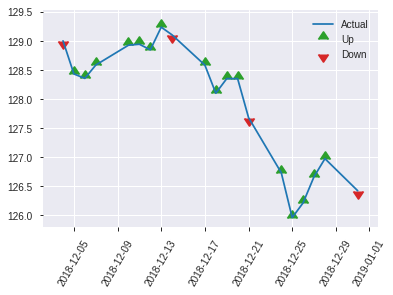


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2259449015295198
RMSE: 0.47533661917584236
LogLoss: 0.6435786326788436
Mean Per-Class Error: 0.33250688705234155
AUC: 0.7056626874808694
pr_auc: 0.6390845880386674
Gini: 0.4113253749617387
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48491814732551575: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   73   0.5407   (73.0/135.0)
1      17   104  0.1405   (17.0/121.0)
Total  79   177  0.3516   (90.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.484918     0.697987  176
max f2                       0.30614      0.820793  246
max f0point5                 0.621816     0.642674  66
max accuracy                 0.513513     0.660156  149
max precision                0.752973     1         0
max recall                   0.218247     1         253
max specificity              0.752973     1         0
max absolute_mcc             0.505613     0.345455  159
max min_per_class_accuracy   0.541487     0.644628  124
max mean_per_class_accuracy  0.505613     0.667493  159

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 53.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.731315           0.705234  0.705234           0.333333         0.741902  0.333333                    0.741902            0.00826446      0.00826446                 -29.4766  -29.4766
    2        0.0234375                   0.713604           2.1157    1.41047            1                0.72356   0.666667                    0.732731            0.0247934       0.0330579                  111.57    41.0468
    3        0.03125                     0.707788           2.1157    1.58678            1                0.709695  0.75                        0.726972            0.0165289       0.0495868                  111.57    58.6777
    4        0.0429688                   0.704855           1.41047   1.53869            0.666667         0.706943  0.727273                    0.721509            0.0165289       0.0661157                  41.0468   53.8693
    5        0.0507812                   0.698376           1.05785   1.46472            0.5              0.700559  0.692308                    0.718286            0.00826446      0.0743802                  5.78512   46.4717
    6        0.101562                    0.674401           1.46472   1.46472            0.692308         0.686999  0.692308                    0.702642            0.0743802       0.14876                    46.4717   46.4717
    7        0.152344                    0.65735            1.79021   1.57321            0.846154         0.666808  0.74359                     0.690698            0.0909091       0.239669                   79.021    57.3215
    8        0.203125                    0.639165           1.46472   1.54609            0.692308         0.645884  0.730769                    0.679494            0.0743802       0.31405                    46.4717   54.609
    9        0.300781                    0.606861           1.26942   1.45626            0.6              0.622576  0.688312                    0.661014            0.123967        0.438017                   26.9421   45.6263
    10       0.402344                    0.572269           1.13922   1.37623            0.538462         0.588191  0.650485                    0.642632            0.115702        0.553719                   13.9224   37.6234
    11       0.5                         0.535896           0.930909  1.28926            0.44             0.551645  0.609375                    0.624861            0.0909091       0.644628                   -6.90909  28.9256
    12       0.601562                    0.510503           1.13922   1.26393            0.538462         0.522391  0.597403                    0.607561            0.115702        0.760331                   13.9224   26.3926
    13       0.699219                    0.480836           1.01554   1.22923            0.48             0.497423  0.581006                    0.592178            0.0991736       0.859504                   1.55372   22.9235
    14       0.800781                    0.427642           0.488239  1.13525            0.230769         0.450582  0.536585                    0.57422             0.0495868       0.909091                   -51.1761  13.5255
    15       0.898438                    0.376639           0.507769  1.06705            0.24             0.403584  0.504348                    0.555672            0.0495868       0.958678                   -49.2231  6.70499
    16       1                           0.109064           0.406866  1                  0.192308         0.310899  0.472656                    0.530813         

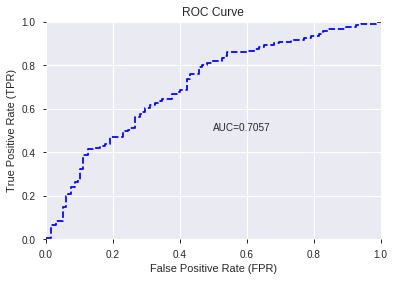

This function is available for GLM models only


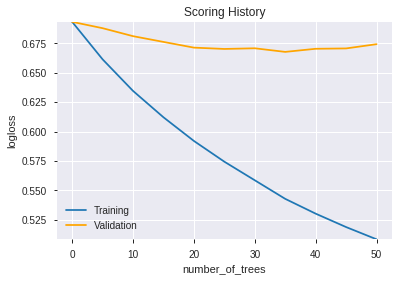

--2019-08-22 15:53:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.226.128
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.226.128|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190822_155304',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190822_155304',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_a7f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_26_sid_a7f4',
   'type

['BOP',
 'SUB',
 'STOCHF_fastk',
 'CCI_8',
 'CORREL_30',
 'CORREL_8',
 'DIV',
 'CORREL_20',
 'dayofyear',
 'COSH',
 'STOCHRSI_fastk',
 'SAREXT',
 'EXP',
 'CDLGRAVESTONEDOJI',
 'week',
 'CDLDRAGONFLYDOJI',
 'weekofyear',
 'CDLDOJI',
 'CDLRICKSHAWMAN',
 'CDLTAKURI',
 'HT_TRENDMODE',
 'SINH',
 'quarter',
 'CDLLONGLEGGEDDOJI',
 'is_month_end']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_155339_model_1  0.672727  0.655107              0.419957  0.481108  0.231465

variable  relative_importance  scaled_importance    percentage
0                          BOP         1.682497e-01           1.000000  3.277415e-02
1                          SUB         1.094189e-01           0.650336  2.131423e-02
2                          DIV         1.093850e-01           0.650135  2.130763e-02
3                 CDLENGULFING         8.151495e-02           0.484488  1.587868e-02
4            CDLGRAVESTONEDOJI         7.668881e-02           0.455804  1.493857e-02
...                        ...                  ...                ...           ...
1021  BBANDS_middleband_12_2_5         6.563128e-06           0.000039  1.278462e-06
1022  BBANDS_middleband_12_2_4         5.010524e-06           0.000030  9.760235e-07
1023   BBANDS_middleband_8_2_5         4.325872e-06           0.000026  8.426569e-07
1024  BBANDS_middleband_14_2_3         2.751818e-06           0.000016  5.360396e-07
1025  BBANDS_middleband_14_2_4         3.044573e-07           0.000002  5.930667e-08

[1026 rows x 4 columns]

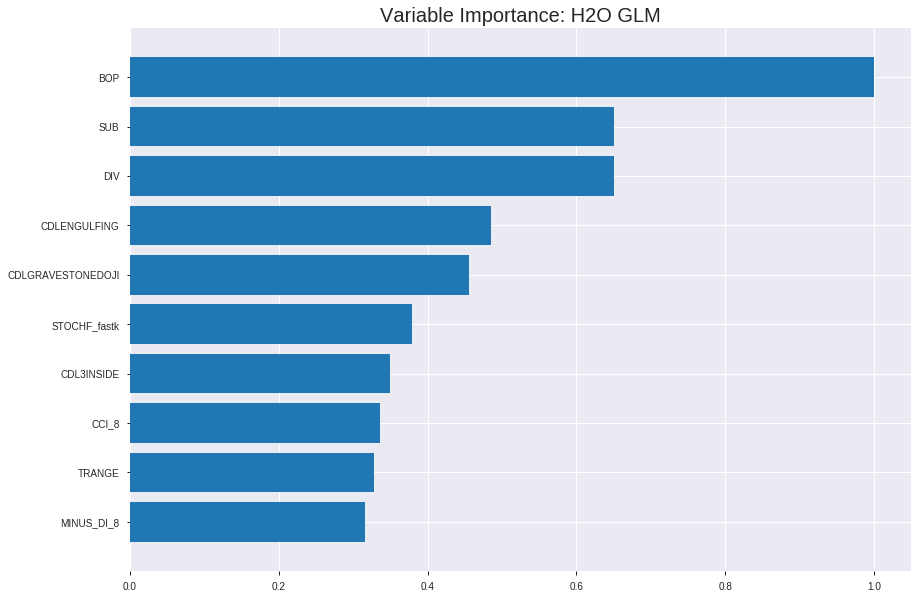

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_155339_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2238830478673153
RMSE: 0.4731628132760597
LogLoss: 0.6377695191362147
Null degrees of freedom: 1787
Residual degrees of freedom: 761
Null deviance: 2476.257522519208
Residual deviance: 2280.663800431104
AIC: 4334.663800431104
AUC: 0.689389297961403
pr_auc: 0.6473771697560835
Gini: 0.37877859592280605
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36640769857985817: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      221  706   0.7616   (706.0/927.0)
1      33   828   0.0383   (33.0/861.0)
Total  254  1534  0.4133   (739.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.366408     0.691441  300
max f2                       0.341627     0.837297  317
max f0point5                 0.470206     0.62538   203
max accuracy                 0.470206     0.639262  203
max precision                0.88347      1         0
max recall                   0.22432      1         376
max specificity              0.88347      1         0
max absolute_mcc             0.435719     0.28771   239
max min_per_class_accuracy   0.491518     0.627178  183
max mean_per_class_accuracy  0.470206     0.642015  203

Gains/Lift Table: Avg response rate: 48.15 %, avg score: 48.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.719805           1.84592   1.84592            0.888889         0.779995  0.888889                    0.779995            0.018583        0.018583                   84.5916   84.5916
    2        0.0201342                   0.695635           1.38444   1.61518            0.666667         0.710656  0.777778                    0.745326            0.0139373       0.0325203                  38.4437   61.5176
    3        0.0302013                   0.668525           1.49981   1.57672            0.722222         0.683169  0.759259                    0.724607            0.0150987       0.047619                   49.9806   57.672
    4        0.0402685                   0.655589           1.49981   1.55749            0.722222         0.661536  0.75                        0.708839            0.0150987       0.0627178                  49.9806   55.7491
    5        0.0503356                   0.64168            1.61518   1.56903            0.777778         0.648584  0.755556                    0.696788            0.0162602       0.0789779                  61.5176   56.9028
    6        0.100112                    0.609307           1.56332   1.56619            0.752809         0.622788  0.75419                     0.659995            0.0778165       0.156794                   56.3325   56.6192
    7        0.150447                    0.587079           1.29214   1.4745             0.622222         0.598199  0.710037                    0.639319            0.0650407       0.221835                   29.2141   47.4502
    8        0.200224                    0.572032           1.21333   1.40957            0.58427          0.579046  0.678771                    0.624335            0.0603949       0.28223                    21.3327   40.9573
    9        0.300336                    0.541681           1.20655   1.3419             0.581006         0.556814  0.646182                    0.601828            0.12079         0.40302                    20.6548   34.1898
    10       0.399888                    0.515299           1.22499   1.31279            0.589888         0.528461  0.632168                    0.583563            0.121951        0.524971                   22.4993   31.2795
    11       0.5                         0.489139           1.06733   1.26365            0.513966         0.502511  0.608501                    0.567335            0.106852        0.631823                   6.73311   26.3647
    12       0.600112                    0.464116           1.10214   1.2367             0.530726         0.475323  0.595527                    0.551985            0.110337        0.74216                    10.2135   23.6703
    13       0.699664                    0.436498           0.921662  1.19188            0.44382          0.451531  0.573941                    0.537692            0.0917538       0.833914                   -7.83385  19.1877
    14       0.799776                    0.397889           0.800498  1.14289            0.385475         0.417811  0.55035                     0.522686            0.0801394       0.914053                   -19.9502  14.2886
    15       0.899888                    0.337273           0.684484  1.09189            0.329609         0.369996  0.525792                    0.505699            0.068525        0.982578                   -31.5516  9.18895
    16       1                           0.0178682          0.174021  1                  0.0837989        0.264413  0.481544                    0.481544          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24125870373067587
RMSE: 0.49118092769434346
LogLoss: 0.6747413553326519
Null degrees of freedom: 510
Residual degrees of freedom: -516
Null deviance: 708.4284254426307
Residual deviance: 689.5856651499703
AIC: 2743.5856651499703
AUC: 0.6032945142506895
pr_auc: 0.5633652825998854
Gini: 0.20658902850137895
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34996817314347045: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      38   222  0.8538   (222.0/260.0)
1      10   241  0.0398   (10.0/251.0)
Total  48   463  0.454    (232.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.349968     0.67507   358
max f2                       0.278159     0.833333  391
max f0point5                 0.469386     0.598521  234
max accuracy                 0.470354     0.600783  232
max precision                0.788598     1         0
max recall                   0.278159     1         391
max specificity              0.788598     1         0
max absolute_mcc             0.469386     0.209939  234
max min_per_class_accuracy   0.493819     0.576923  196
max mean_per_class_accuracy  0.469386     0.602659  234

Gains/Lift Table: Avg response rate: 49.12 %, avg score: 48.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.744287           1.01793   1.01793            0.5              0.764217  0.5                         0.764217            0.0119522       0.0119522                  1.79283   1.79283
    2        0.0215264                   0.664004           0.814343  0.925389           0.4              0.704044  0.454545                    0.736866            0.00796813      0.0199203                  -18.5657  -7.46106
    3        0.0313112                   0.65839            1.62869   1.14517            0.8              0.661503  0.5625                      0.713315            0.0159363       0.0358566                  62.8685   14.5169
    4        0.0410959                   0.646084           2.03586   1.35724            1                0.651681  0.666667                    0.69864             0.0199203       0.0557769                  103.586   35.7238
    5        0.0508806                   0.634872           1.22151   1.33114            0.6              0.640213  0.653846                    0.687404            0.0119522       0.0677291                  22.1514   33.1137
    6        0.101761                    0.598138           1.01793   1.17453            0.5              0.612377  0.576923                    0.649891            0.0517928       0.119522                   1.79283   17.4533
    7        0.150685                    0.575103           1.05865   1.13691            0.52             0.586771  0.558442                    0.629397            0.0517928       0.171315                   5.86454   13.6907
    8        0.201566                    0.560314           1.17453   1.1464             0.576923         0.568418  0.563107                    0.614005            0.059761        0.231076                   17.4533   14.6405
    9        0.30137                     0.538219           1.19756   1.16335            0.588235         0.549657  0.571429                    0.592695            0.119522        0.350598                   19.7563   16.3347
    10       0.401174                    0.516196           1.19756   1.17186            0.588235         0.524911  0.57561                     0.575831            0.119522        0.47012                    19.7563   17.1859
    11       0.500978                    0.493191           1.11773   1.16107            0.54902          0.502921  0.570312                    0.561306            0.111554        0.581673                   11.7725   16.1074
    12       0.600783                    0.470354           1.23748   1.17377            0.607843         0.480593  0.576547                    0.547898            0.123506        0.705179                   23.7481   17.3767
    13       0.700587                    0.442771           0.678619  1.10323            0.333333         0.454775  0.541899                    0.534632            0.0677291       0.772908                   -32.1381  10.323
    14       0.800391                    0.412522           0.838294  1.07019            0.411765         0.428856  0.525672                    0.521442            0.0836653       0.856574                   -16.1706  7.01936
    15       0.900196                    0.353734           0.918131  1.05333            0.45098          0.383918  0.517391                    0.506195            0.0916335       0.948207                   -8.18686  5.33345
    16       1                           0.0187793          0.518944  1                  0.254902         0.305197  0.491194                    0.486134         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-22 15:53:43  0.000 sec   2            8.2       1001          1.3715            1.37793
    2019-08-22 15:53:45  2.290 sec   4            6         1015          1.36753           1.37564
    2019-08-22 15:53:48  4.686 sec   6            4.3       1026          1.36267           1.373
    2019-08-22 15:53:50  7.119 sec   8            3.2       1027          1.3568            1.36997
    2019-08-22 15:53:52  9.350 sec   10           2.3       1027          1.34991           1.36666
    2019-08-22 15:53:55  11.655 sec  12           1.7       1027          1.34209           1.3632
    2019-08-22 15:53:57  14.037 sec  14           1.2       1027          1.33345           1.35979
    2019-08-22 15:53:59  16.332 sec  16           0.89      1027          1.32419           1.35666
    2019-08-22 15:54:02  18.634 sec  18           0.65      1027          1.31456           1.35399
    2019-08-22 15:54:04  20.908 sec  20           0.47      1027          1.30473           1.35192
    2019-08-22 15:54:06  23.198 sec  22           0.34      1027          1.29487           1.35051
    2019-08-22 15:54:08  25.536 sec  24           0.25      1027          1.28512           1.3497
    2019-08-22 15:54:11  27.825 sec  26           0.18      1027          1.27554           1.34948
    2019-08-22 15:54:13  30.199 sec  28           0.13      1027          1.26622           1.34979
    2019-08-22 15:54:15  32.476 sec  30           0.096     1027          1.25725           1.35059
    2019-08-22 15:54:18  34.741 sec  32           0.07      1027          1.24868           1.35199
    2019-08-22 15:54:20  37.048 sec  34           0.051     1027          1.2406            1.35378
    2019-08-22 15:54:22  39.373 sec  36           0.037     1027          1.23305           1.35606

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.65234375)

('F1', 0.6606060606060605)

('auc', 0.6727272727272727)

('logloss', 0.6551065272137377)

('mean_per_class_error', 0.35234159779614327)

('rmse', 0.48110788620183514)

('mse', 0.23146479816559795)

glm prediction progress: |████████████████████████████████████████████████| 100%


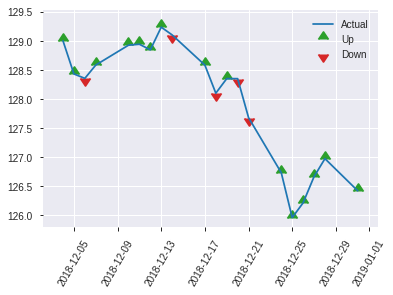


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.23146479816559795
RMSE: 0.48110788620183514
LogLoss: 0.6551065272137377
Null degrees of freedom: 255
Residual degrees of freedom: -771
Null deviance: 354.20638056124005
Residual deviance: 335.41454193343367
AIC: 2389.4145419334336
AUC: 0.6727272727272727
pr_auc: 0.6172245259577714
Gini: 0.34545454545454546
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.390401451658845: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      35   100  0.7407   (100.0/135.0)
1      12   109  0.0992   (12.0/121.0)
Total  47   209  0.4375   (112.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.390401     0.660606  208
max f2                       0.277943     0.823129  250
max f0point5                 0.501872     0.634096  89
max accuracy                 0.501872     0.652344  89
max precision                0.809081     1         0
max recall                   0.277943     1         250
max specificity              0.809081     1         0
max absolute_mcc             0.501872     0.302523  89
max min_per_class_accuracy   0.47456      0.628099  124
max mean_per_class_accuracy  0.492072     0.647658  103

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 47.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.663751           1.41047   1.41047            0.666667         0.715027  0.666667                    0.715027            0.0165289       0.0165289                  41.0468   41.0468
    2        0.0234375                   0.656311           0.705234  1.05785            0.333333         0.659172  0.5                         0.687099            0.00826446      0.0247934                  -29.4766  5.78512
    3        0.03125                     0.64567            1.05785   1.05785            0.5              0.65096   0.5                         0.678064            0.00826446      0.0330579                  5.78512   5.78512
    4        0.0429688                   0.623545           2.1157    1.34636            1                0.636165  0.636364                    0.666637            0.0247934       0.0578512                  111.57    34.6356
    5        0.0507812                   0.616305           2.1157    1.46472            1                0.618697  0.692308                    0.659262            0.0165289       0.0743802                  111.57    46.4717
    6        0.101562                    0.587952           1.46472   1.46472            0.692308         0.602737  0.692308                    0.630999            0.0743802       0.14876                    46.4717   46.4717
    7        0.152344                    0.555094           1.62746   1.51897            0.769231         0.57151   0.717949                    0.611169            0.0826446       0.231405                   62.7463   51.8966
    8        0.203125                    0.538038           1.46472   1.5054             0.692308         0.545485  0.711538                    0.594748            0.0743802       0.305785                   46.4717   50.5404
    9        0.300781                    0.509912           1.26942   1.42879            0.6              0.525076  0.675325                    0.572127            0.123967        0.429752                   26.9421   42.8786
    10       0.402344                    0.492459           1.2206    1.37623            0.576923         0.501697  0.650485                    0.554349            0.123967        0.553719                   22.0598   37.6234
    11       0.5                         0.471746           0.761653  1.2562             0.36             0.479817  0.59375                     0.539792            0.0743802       0.628099                   -23.8347  25.6198
    12       0.601562                    0.453957           0.895105  1.19523            0.423077         0.463044  0.564935                    0.526834            0.0909091       0.719008                   -10.4895  19.5235
    13       0.699219                    0.43097            0.846281  1.1465             0.4              0.442026  0.541899                    0.51499             0.0826446       0.801653                   -15.3719  14.6498
    14       0.800781                    0.397744           0.813732  1.10429            0.384615         0.415766  0.521951                    0.502405            0.0826446       0.884298                   -18.6268  10.4293
    15       0.898438                    0.352385           0.677025  1.05785            0.32             0.379735  0.5                         0.489071            0.0661157       0.950413                   -32.2975  5.78512
    16       1                           0.223832           0.488239  1                  0.230769         0.302185  0.472656                    0.470091         

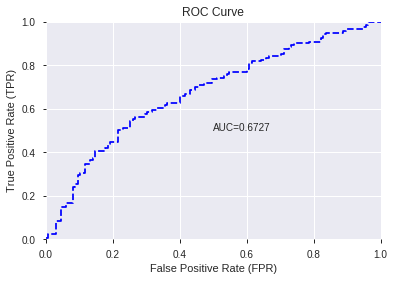

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


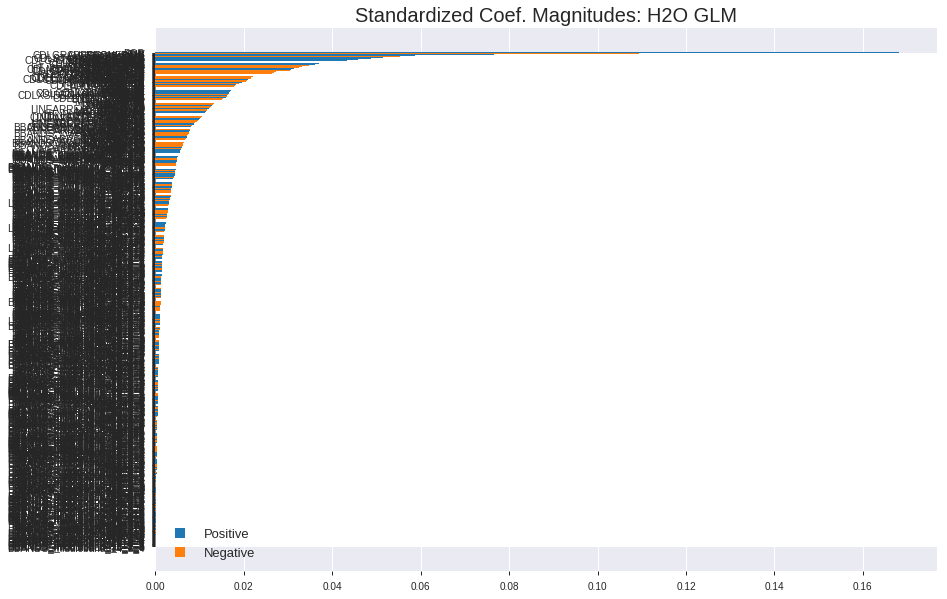

'log_likelihood'
--2019-08-22 15:54:52--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.164.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.164.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_155339_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_155339_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_a7f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

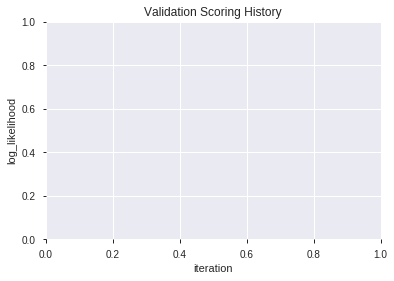

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_155503_model_3  0.713805  0.639438              0.396878  0.473248  0.223964
1  XGBoost_grid_1_AutoML_20190822_155503_model_2  0.697582  0.647601              0.366116  0.477171  0.227692
2               XGBoost_3_AutoML_20190822_155503  0.682767  0.649790              0.330517  0.478410  0.228876
3               XGBoost_2_AutoML_20190822_155503  0.668381  0.649477              0.383777  0.478442  0.228907
4  XGBoost_grid_1_AutoML_20190822_155503_model_4  0.665565  0.655917              0.370248  0.481647  0.231984
5  XGBoost_grid_1_AutoML_20190822_155503_model_1  0.658188  0.656901              0.434190  0.482047  0.232369
6  XGBoost_grid_1_AutoML_20190822_155503_model_6  0.652831  0.654727              0.394735  0.481162  0.231516
7               XGBoost_1_AutoML_20190822_155503  0.652709  0.651437              0.433762  0.479874  0.230279
8  XGBoost_grid_1_AutoML_20190822_155503_model_5  0.651852  0.649944              0.359412  0.479370  0.229796
9  XGBoost_grid_1_AutoML_20190822_155503_model_7  0.651668  0.653571              0.399725  0.480742  0.231113

variable  relative_importance  scaled_importance  percentage
0                        BOP           439.271057           1.000000    0.068509
1                        SUB           336.158417           0.765264    0.052428
2                        DIV           155.922760           0.354958    0.024318
3               STOCHF_fastk           149.114243           0.339458    0.023256
4             STOCHRSI_fastd           109.198891           0.248591    0.017031
..                       ...                  ...                ...         ...
291                   ATR_14             1.801233           0.004101    0.000281
292                   ADX_20             1.527699           0.003478    0.000238
293  BBANDS_upperband_14_3_2             0.947388           0.002157    0.000148
294                     week             0.733596           0.001670    0.000114
295                  NATR_20             0.663752           0.001511    0.000104

[296 rows x 4 columns]

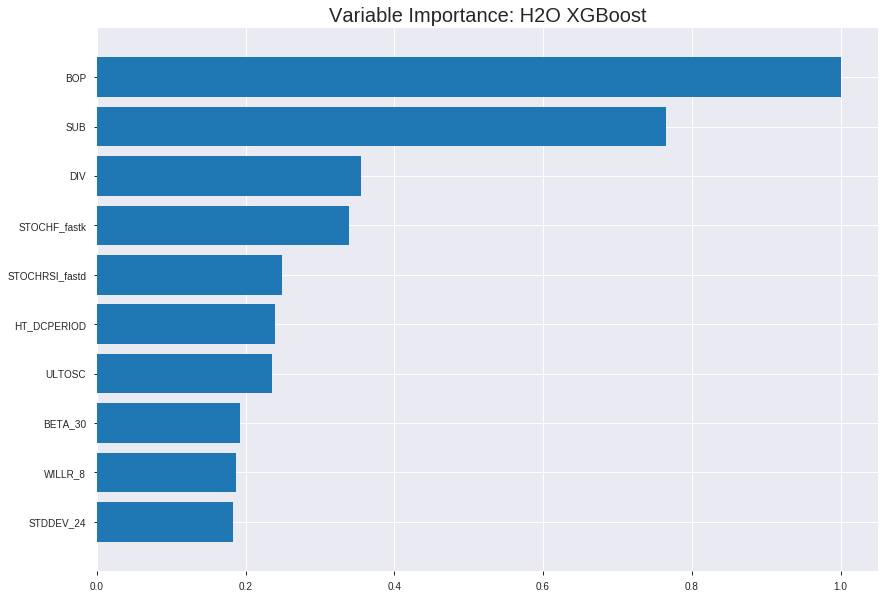

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_155503_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1659878470545542
RMSE: 0.4074160613605632
LogLoss: 0.516692614370987
Mean Per-Class Error: 0.14208660810602558
AUC: 0.9333869575404029
pr_auc: 0.9355483936644268
Gini: 0.8667739150808058
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48407356228147236: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      775  152  0.164    (152.0/927.0)
1      107  754  0.1243   (107.0/861.0)
Total  882  906  0.1449   (259.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.484074     0.853424  200
max f2                       0.410576     0.889912  258
max f0point5                 0.551097     0.878438  148
max accuracy                 0.504415     0.857942  184
max precision                0.831887     1         0
max recall                   0.291202     1         336
max specificity              0.831887     1         0
max absolute_mcc             0.504415     0.715851  184
max min_per_class_accuracy   0.491723     0.857143  194
max mean_per_class_accuracy  0.491723     0.857913  194

Gains/Lift Table: Avg response rate: 48.15 %, avg score: 48.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.773953           2.07666   2.07666            1                0.794775  1                           0.794775            0.0209059       0.0209059                  107.666   107.666
    2        0.0201342                   0.751011           2.07666   2.07666            1                0.76088   1                           0.777827            0.0209059       0.0418118                  107.666   107.666
    3        0.0302013                   0.728271           2.07666   2.07666            1                0.741954  1                           0.76587             0.0209059       0.0627178                  107.666   107.666
    4        0.0402685                   0.712361           2.07666   2.07666            1                0.72086   1                           0.754617            0.0209059       0.0836237                  107.666   107.666
    5        0.0503356                   0.702625           2.07666   2.07666            1                0.707051  1                           0.745104            0.0209059       0.10453                    107.666   107.666
    6        0.100112                    0.667021           2.07666   2.07666            1                0.684954  1                           0.715197            0.103368        0.207898                   107.666   107.666
    7        0.150447                    0.637757           2.07666   2.07666            1                0.652106  1                           0.694089            0.10453         0.312427                   107.666   107.666
    8        0.200224                    0.613931           2.02999   2.06505            0.977528         0.625789  0.994413                    0.677109            0.101045        0.413473                   102.999   106.505
    9        0.300336                    0.574265           1.87943   2.00318            0.905028         0.594233  0.964618                    0.649484            0.188153        0.601626                   87.9431   100.318
    10       0.399888                    0.528244           1.52832   1.88496            0.735955         0.551168  0.907692                    0.625008            0.152149        0.753775                   52.8325   88.4964
    11       0.5                         0.485819           1.14854   1.73751            0.553073         0.507183  0.836689                    0.601417            0.114983        0.868757                   14.8541   73.7515
    12       0.600112                    0.445687           0.626477  1.55217            0.301676         0.465134  0.747437                    0.578682            0.0627178       0.931475                   -37.3523  55.2169
    13       0.699664                    0.403593           0.384998  1.3861             0.185393         0.424738  0.667466                    0.556778            0.0383275       0.969803                   -61.5002  38.6097
    14       0.799776                    0.355034           0.174021  1.23438            0.0837989        0.380712  0.594406                    0.534739            0.0174216       0.987224                   -82.5979  23.4375
    15       0.899888                    0.280984           0.127616  1.11125            0.0614525        0.321502  0.535115                    0.511016            0.0127758       1                          -87.2384  11.1249
    16       1                           0.129054           0         1                  0                0.226486  0.481544                    0.482531         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.23739795668512254
RMSE: 0.4872350117603645
LogLoss: 0.6676811514353485
Mean Per-Class Error: 0.3777658596383696
AUC: 0.6345004596996628
pr_auc: 0.5761631014525982
Gini: 0.2690009193993257
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.433794230222702: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      83   177  0.6808   (177.0/260.0)
1      26   225  0.1036   (26.0/251.0)
Total  109  402  0.3973   (203.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.433794     0.689127  307
max f2                       0.211361     0.829478  397
max f0point5                 0.480064     0.615333  240
max accuracy                 0.480064     0.620352  240
max precision                0.659822     0.638889  30
max recall                   0.211361     1         397
max specificity              0.745229     0.996154  0
max absolute_mcc             0.433794     0.26317   307
max min_per_class_accuracy   0.509657     0.6       202
max mean_per_class_accuracy  0.480064     0.622234  240

Gains/Lift Table: Avg response rate: 49.12 %, avg score: 50.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.728794           1.01793   1.01793            0.5              0.736994  0.5                         0.736994            0.0119522       0.0119522                  1.79283   1.79283
    2        0.0215264                   0.712675           0.814343  0.925389           0.4              0.715776  0.454545                    0.72735             0.00796813      0.0199203                  -18.5657  -7.46106
    3        0.0313112                   0.699016           1.62869   1.14517            0.8              0.706747  0.5625                      0.720911            0.0159363       0.0358566                  62.8685   14.5169
    4        0.0410959                   0.690809           1.22151   1.16335            0.6              0.695485  0.571429                    0.714857            0.0119522       0.0478088                  22.1514   16.3347
    5        0.0508806                   0.672146           1.22151   1.17453            0.6              0.682124  0.576923                    0.708562            0.0119522       0.059761                   22.1514   17.4533
    6        0.101761                    0.63821            1.25283   1.21368            0.615385         0.653075  0.596154                    0.680819            0.063745        0.123506                   25.2835   21.3684
    7        0.150685                    0.617539           1.30295   1.24267            0.64             0.627697  0.61039                     0.663572            0.063745        0.187251                   30.2948   24.2666
    8        0.201566                    0.595962           0.783022  1.12664            0.384615         0.605732  0.553398                    0.648971            0.0398406       0.227092                   -21.6978  12.6639
    9        0.30137                     0.567297           1.35724   1.20301            0.666667         0.581327  0.590909                    0.62657             0.135458        0.36255                    35.7238   20.3006
    10       0.401174                    0.540739           1.31732   1.23144            0.647059         0.556107  0.604878                    0.60904             0.131474        0.494024                   31.7319   23.1445
    11       0.500978                    0.50874            1.07781   1.20084            0.529412         0.522712  0.589844                    0.591842            0.10757         0.601594                   7.78064   20.0837
    12       0.600783                    0.48123            1.19756   1.20029            0.588235         0.495354  0.589577                    0.575813            0.119522        0.721116                   19.7563   20.0293
    13       0.700587                    0.456647           0.798375  1.14304            0.392157         0.468642  0.561453                    0.560545            0.0796813       0.800797                   -20.1625  14.3037
    14       0.800391                    0.426605           1.03789   1.12993            0.509804         0.443387  0.555012                    0.545937            0.103586        0.904382                   3.78877   12.9925
    15       0.900196                    0.388841           0.439106  1.05333            0.215686         0.410648  0.517391                    0.530937            0.0438247       0.948207                   -56.0894  5.33345
    16       1                           0.15021            0.518944  1                  0.254902         0.319178  0.491194                    0.509803        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 15:55:32  8.392 sec   0                  0.5              0.693147            0.5             0                  1                0.518456                         0.5                0.693147              0.5               0                    1                  0.508806
    2019-08-22 15:55:33  9.732 sec   5                  0.492343         0.67789             0.67586         0.683006           1.96736          0.423378                         0.497662           0.688467              0.566044          0.5423               1.35724            0.485323
    2019-08-22 15:55:33  10.152 sec  10                 0.487998         0.669267            0.707797        0.730787           1.96129          0.380872                         0.497893           0.688933              0.554789          0.527963             0.339309           0.481409
    2019-08-22 15:55:34  10.579 sec  15                 0.482773         0.65885             0.723996        0.750393           1.96129          0.373602                         0.49664            0.686364              0.570028          0.542046             0.678619           0.455969
    2019-08-22 15:55:34  11.037 sec  20                 0.474666         0.64253             0.747201        0.770364           2.07666          0.354027                         0.496402           0.685973              0.571621          0.539512             0.678619           0.465753
    2019-08-22 15:55:35  11.444 sec  25                 0.47377          0.640884            0.750058        0.776389           1.96129          0.355145                         0.495378           0.683801              0.580126          0.543607             0.678619           0.46771
    2019-08-22 15:55:35  11.879 sec  30                 0.470151         0.633577            0.754184        0.783782           2.07666          0.352349                         0.494485           0.682214              0.598131          0.557784             1.01793            0.459883
    2019-08-22 15:55:35  12.307 sec  35                 0.463982         0.620551            0.755549        0.783257           2.07666          0.349553                         0.494289           0.681844              0.59548           0.557245             1.01793            0.44227
    2019-08-22 15:55:36  12.751 sec  40                 0.464007         0.621172            0.771992        0.80455            2.07666          0.348434                         0.493446           0.679802              0.578333          0.553286             1.01793            0.446184
    2019-08-22 15:55:36  13.183 sec  45                 0.460187         0.61352             0.782973        0.818228           2.07666          0.339485                         0.493569           0.680469              0.604689          0.563068             0.678619           0.448141
    2019-08-22 15:55:37  13.616 sec  50                 0.407416         0.516693            0.933387        0.935548           2.07666          0.144855                         0.487235           0.667681              0.6345            0.576163             1.01793            0.39726

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      439.27105712890625     1.0                    0.06850915868649049
SUB                      336.1584167480469      0.7652642059897872     0.05242760692524547
DIV                      155.92276000976562     0.354957963834183      0.024317871471349593
STOCHF_fastk             149.11424255371094     0.33945838254932564    0.023256008197531142
STOCHRSI_fastd           109.19889068603516     0.24859113504942396    0.01703076951915577
---                      ---                    ---                    ---
ATR_14                   1.8012332916259766     0.004100505285731575   0.00028092216731497743
ADX_20                   1.5276994705200195     0.003477805891663171   0.00023826155571276373
BBANDS_upperband_14_3_2  0.9473876953125        0.0021567268772603983  0.00014775554387765172
week                     0.7335958480834961     0.0016700300103501214  0.00011441235099027782
NATR_20                  0.6637516021728516     0.001511029673821807   0.00010351937170385413


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.68359375)

('F1', 0.6768292682926831)

('auc', 0.7138047138047138)

('logloss', 0.6394378020872307)

('mean_per_class_error', 0.32614018977655346)

('rmse', 0.4732483428562106)

('mse', 0.22396399401614947)

xgboost prediction progress: |████████████████████████████████████████████| 100%


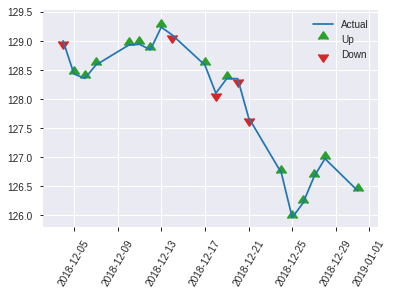


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.22396399401614947
RMSE: 0.4732483428562106
LogLoss: 0.6394378020872307
Mean Per-Class Error: 0.32614018977655346
AUC: 0.7138047138047138
pr_auc: 0.6946705030452417
Gini: 0.42760942760942755
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4325188398361206: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      39   96   0.7111   (96.0/135.0)
1      10   111  0.0826   (10.0/121.0)
Total  49   207  0.4141   (106.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.432519     0.676829  206
max f2                       0.363148     0.827538  234
max f0point5                 0.563464     0.681293  77
max accuracy                 0.563464     0.683594  77
max precision                0.659382     0.933333  14
max recall                   0.203421     1         253
max specificity              0.736449     0.992593  0
max absolute_mcc             0.563464     0.376235  77
max min_per_class_accuracy   0.516222     0.651852  125
max mean_per_class_accuracy  0.563061     0.67386   79

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 50.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.69767            1.41047   1.41047            0.666667         0.720075  0.666667                    0.720075            0.0165289       0.0165289                  41.0468   41.0468
    2        0.0234375                   0.687336           2.1157    1.76309            1                0.691803  0.833333                    0.705939            0.0247934       0.0413223                  111.57    76.3085
    3        0.03125                     0.677703           2.1157    1.85124            1                0.684516  0.875                       0.700583            0.0165289       0.0578512                  111.57    85.124
    4        0.0429688                   0.671974           2.1157    1.92337            1                0.67347   0.909091                    0.693189            0.0247934       0.0826446                  111.57    92.3366
    5        0.0507812                   0.667261           2.1157    1.95296            1                0.670169  0.923077                    0.689647            0.0165289       0.0991736                  111.57    95.2956
    6        0.101562                    0.629291           1.62746   1.79021            0.769231         0.645367  0.846154                    0.667507            0.0826446       0.181818                   62.7463   79.021
    7        0.152344                    0.607464           1.46472   1.68171            0.692308         0.619693  0.794872                    0.651569            0.0743802       0.256198                   46.4717   68.1712
    8        0.203125                    0.594114           1.95296   1.74952            0.923077         0.601175  0.826923                    0.638971            0.0991736       0.355372                   95.2956   74.9523
    9        0.300781                    0.563911           1.26942   1.59365            0.6              0.578224  0.753247                    0.619248            0.123967        0.479339                   26.9421   59.3646
    10       0.402344                    0.541011           0.813732  1.39677            0.384615         0.553176  0.660194                    0.602569            0.0826446       0.561983                   -18.6268  39.6774
    11       0.5                         0.515575           0.930909  1.30579            0.44             0.528496  0.617188                    0.588102            0.0909091       0.652893                   -6.90909  30.5785
    12       0.601562                    0.490997           0.813732  1.22271            0.384615         0.503249  0.577922                    0.573776            0.0826446       0.735537                   -18.6268  22.2711
    13       0.699219                    0.459192           0.677025  1.1465             0.32             0.473467  0.541899                    0.559766            0.0661157       0.801653                   -32.2975  14.6498
    14       0.800781                    0.436193           1.05785   1.13525            0.5              0.446996  0.536585                    0.545464            0.107438        0.909091                   5.78512   13.5255
    15       0.898438                    0.375449           0.592397  1.07625            0.28             0.410288  0.508696                    0.530771            0.0578512       0.966942                   -40.7603  7.62487
    16       1                           0.187048           0.325493  1                  0.153846         0.309028  0.472656                    0.50825            

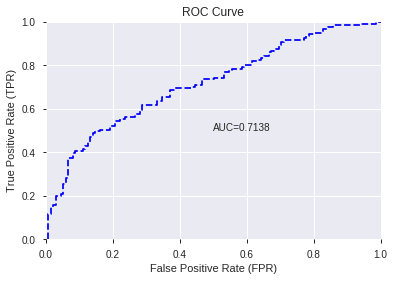

This function is available for GLM models only


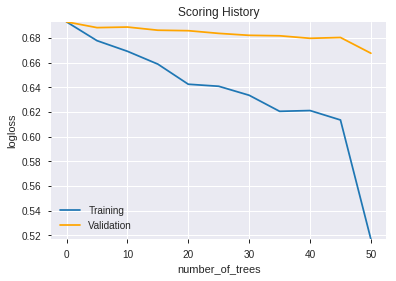

--2019-08-22 15:56:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.146.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.146.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_155503_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_155503_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_a7f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_155619_model_9  0.650811  0.675832              0.440894  0.491263  0.241339
1  DeepLearning_grid_1_AutoML_20190822_155619_model_6  0.627487  0.685181              0.456413  0.493870  0.243907
2  DeepLearning_grid_1_AutoML_20190822_155619_model_8  0.620692  0.671025              0.402571  0.489962  0.240063
3  DeepLearning_grid_1_AutoML_20190822_155619_model_3  0.599265  0.842258              0.485614  0.505727  0.255760
4  DeepLearning_grid_1_AutoML_20190822_155619_model_5  0.599082  0.678545              0.428926  0.493232  0.243277
5  DeepLearning_grid_1_AutoML_20190822_155619_model_1  0.591674  1.109313              0.435629  0.539833  0.291420
6  DeepLearning_grid_1_AutoML_20190822_155619_model_7  0.589838  0.801524              0.453994  0.540800  0.292464
7               DeepLearning_1_AutoML_20190822_155619  0.589593  0.737967              0.434772  0.509936  0.260034
8  DeepLearning_grid_1_AutoML_20190822_155619_model_2  0.583532  0.804207              0.489317  0.514385  0.264592
9  DeepLearning_grid_1_AutoML_20190822_155619_model_4  0.565473  0.747516              0.450291  0.519828  0.270222

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.046911
1                  SUB             0.841794           0.841794    0.039489
2                  DIV             0.800070           0.800070    0.037532
3         STOCHF_fastk             0.733913           0.733913    0.034428
4    CDLGRAVESTONEDOJI             0.579241           0.579241    0.027173
5                CCI_8             0.523917           0.523917    0.024577
6       CDLRICKSHAWMAN             0.457433           0.457433    0.021458
7            CDLTAKURI             0.456119           0.456119    0.021397
8                 COSH             0.455962           0.455962    0.021389
9                 SINH             0.444852           0.444852    0.020868
10                 EXP             0.443536           0.443536    0.020807
11     CDLHOMINGPIGEON             0.442176           0.442176    0.020743
12     CDLADVANCEBLOCK             0.436501           0.436501    0.020477
13              SAREXT             0.428507           0.428507    0.020101
14      STOCHRSI_fastk             0.419359           0.419359    0.019672
15  CDLEVENINGDOJISTAR             0.416924           0.416924    0.019558
16   CDLDARKCLOUDCOVER             0.416641           0.416641    0.019545
17    CDLDRAGONFLYDOJI             0.413238           0.413238    0.019385
18  CDLMORNINGDOJISTAR             0.412190           0.412190    0.019336
19    is_quarter_start             0.409762           0.409762    0.019222
20     CDLUNIQUE3RIVER             0.405488           0.405488    0.019022
21      CDLMORNINGSTAR             0.402877           0.402877    0.018899
22           CORREL_30             0.399963           0.399963    0.018762
23      CDLEVENINGSTAR             0.397199           0.397199    0.018633
24             CDLDOJI             0.395156           0.395156    0.018537
25           CDLONNECK             0.392208           0.392208    0.018399
26  CDLSEPARATINGLINES             0.389908           0.389908    0.018291
27   CDLLONGLEGGEDDOJI             0.383719           0.383719    0.018000
28            CORREL_8             0.381795           0.381795    0.017910
29   CDLSTALLEDPATTERN             0.377428           0.377428    0.017705
30      is_month_start             0.375101           0.375101    0.017596
31        HT_TRENDMODE             0.371392           0.371392    0.017422
32      is_quarter_end             0.370564           0.370564    0.017383
33        CDLTHRUSTING             0.370275           0.370275    0.017370
34     CDLLADDERBOTTOM             0.368774           0.368774    0.017299
35             quarter             0.364735           0.364735    0.017110
36      CDL3LINESTRIKE             0.363697           0.363697    0.017061
37      CDLMATCHINGLOW             0.361354           0.361354    0.016951
38           CORREL_20             0.355953           0.355953    0.016698
39     CDLSHOOTINGSTAR             0.346205           0.346205    0.016241
40           CDLHAMMER             0.345223           0.345223    0.016195
41       CDLHANGINGMAN             0.344934           0.344934    0.016181
42   CDLINVERTEDHAMMER             0.342634           0.342634    0.016073
43        is_month_end             0.338872           0.338872    0.015897
44        CDLTASUKIGAP             0.329846           0.329846    0.015473
45           dayofyear             0.314792           0.314792    0.014767
46          weekofyear             0.310180           0.310180    0.014551
47         CDL3OUTSIDE             0.309981           0.309981    0.014541
48                week             0.301192           0.301192    0.014129
49          CDL3INSIDE             0.273599           0.273599    0.012835

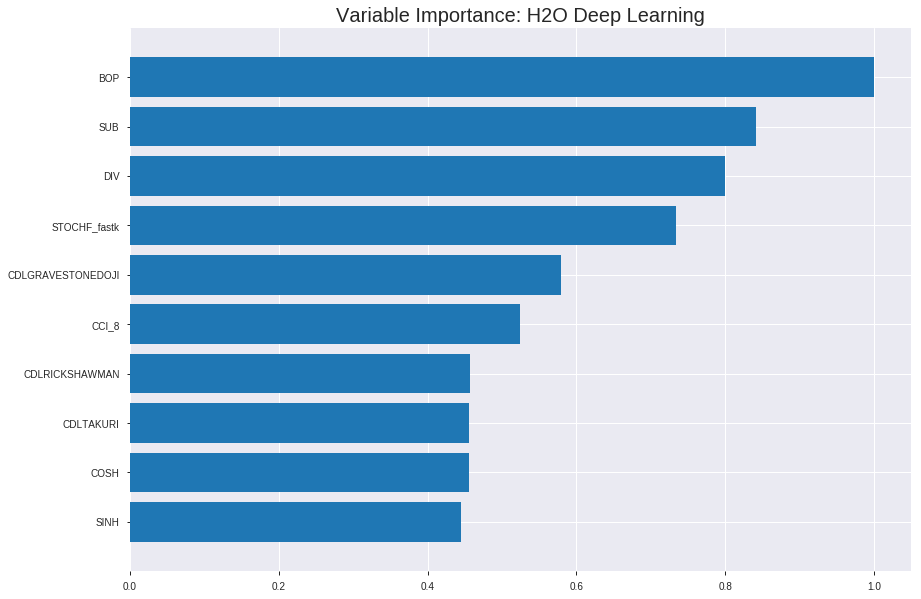

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_155619_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.22306100680047458
RMSE: 0.4722933482492365
LogLoss: 0.6340962794528684
Mean Per-Class Error: 0.3676409232885671
AUC: 0.6849746976434166
pr_auc: 0.6488155755105212
Gini: 0.3699493952868331
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3226579772474039: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      260  667   0.7195   (667.0/927.0)
1      60   801   0.0697   (60.0/861.0)
Total  320  1468  0.4066   (727.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.322658     0.687849  279
max f2                       0.154456     0.834317  349
max f0point5                 0.523112     0.618557  164
max accuracy                 0.523112     0.63255   164
max precision                0.828278     1         0
max recall                   0.087615     1         386
max specificity              0.828278     1         0
max absolute_mcc             0.371288     0.277044  260
max min_per_class_accuracy   0.522433     0.629501  165
max mean_per_class_accuracy  0.523112     0.632359  164

Gains/Lift Table: Avg response rate: 48.15 %, avg score: 46.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.765321           1.84592   1.84592            0.888889         0.795789  0.888889                    0.795789            0.018583        0.018583                   84.5916   84.5916
    2        0.0201342                   0.724849           1.73055   1.78823            0.833333         0.738662  0.861111                    0.767226            0.0174216       0.0360046                  73.0546   78.8231
    3        0.0302013                   0.675964           1.38444   1.65363            0.666667         0.695453  0.796296                    0.743302            0.0139373       0.0499419                  38.4437   65.3633
    4        0.0402685                   0.644369           1.61518   1.64402            0.777778         0.656112  0.791667                    0.721504            0.0162602       0.0662021                  61.5176   64.4019
    5        0.0503356                   0.625913           1.73055   1.66132            0.833333         0.634531  0.8                         0.70411             0.0174216       0.0836237                  73.0546   66.1324
    6        0.100112                    0.585059           1.42333   1.54299            0.685393         0.599696  0.743017                    0.652195            0.0708479       0.154472                   42.3325   54.299
    7        0.150447                    0.572692           1.31521   1.46678            0.633333         0.578604  0.70632                     0.627573            0.0662021       0.220674                   31.5215   46.6782
    8        0.200224                    0.561187           1.23666   1.40957            0.595506         0.56692   0.678771                    0.612495            0.0615563       0.28223                    23.666    40.9573
    9        0.300336                    0.542564           1.27616   1.3651             0.614525         0.5511    0.657356                    0.59203             0.127758        0.409988                   27.6157   36.5101
    10       0.399888                    0.532              1.00333   1.27504            0.483146         0.536741  0.613986                    0.578266            0.0998839       0.509872                   0.332772  27.5037
    11       0.5                         0.521798           1.24135   1.26829            0.597765         0.526685  0.610738                    0.567938            0.124274        0.634146                   24.1352   26.8293
    12       0.600112                    0.509497           0.97452   1.21928            0.469274         0.5155    0.587139                    0.55919             0.097561        0.731707                   -2.54803  21.9285
    13       0.699664                    0.494638           0.979995  1.18524            0.47191          0.503161  0.570743                    0.551218            0.097561        0.829268                   -2.00055  18.5237
    14       0.799776                    0.360525           0.823701  1.13998            0.396648         0.44685   0.548951                    0.538154            0.0824623       0.911731                   -17.6299  13.9982
    15       0.899888                    0.173957           0.661281  1.08673            0.318436         0.259531  0.523306                    0.507157            0.0662021       0.977933                   -33.8719  8.67269
    16       1                           0.0133014          0.220427  1                  0.106145         0.123515  0.481544                    0.46875           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24059648658688162
RMSE: 0.490506357335847
LogLoss: 0.6743512242289791
Mean Per-Class Error: 0.401524670548575
AUC: 0.6173000306466442
pr_auc: 0.5943323943011667
Gini: 0.23460006129328836
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.216206230209694: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      38   222  0.8538   (222.0/260.0)
1      10   241  0.0398   (10.0/251.0)
Total  48   463  0.454    (232.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.216206     0.67507   351
max f2                       0.146492     0.833889  383
max f0point5                 0.50912      0.597148  259
max accuracy                 0.510506     0.594912  254
max precision                0.677379     1         0
max recall                   0.0772113    1         397
max specificity              0.677379     1         0
max absolute_mcc             0.50912      0.214978  259
max min_per_class_accuracy   0.523036     0.569721  196
max mean_per_class_accuracy  0.50912      0.598475  259

Gains/Lift Table: Avg response rate: 49.12 %, avg score: 48.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117417                   0.600119           1.69655   1.69655            0.833333         0.625781  0.833333                    0.625781            0.0199203       0.0199203                  69.6547    69.6547
    2        0.0215264                   0.59193            1.62869   1.6657             0.8              0.595293  0.818182                    0.611922            0.0159363       0.0358566                  62.8685    66.5701
    3        0.0313112                   0.588602           1.22151   1.52689            0.6              0.589558  0.75                        0.604934            0.0119522       0.0478088                  22.1514    52.6892
    4        0.0410959                   0.586246           1.62869   1.55113            0.8              0.587214  0.761905                    0.600715            0.0159363       0.063745                   62.8685    55.1129
    5        0.0508806                   0.58329            1.22151   1.48774            0.6              0.584533  0.730769                    0.597603            0.0119522       0.0756972                  22.1514    48.7741
    6        0.101761                    0.575295           1.17453   1.33114            0.576923         0.578742  0.653846                    0.588173            0.059761        0.135458                   17.4533    33.1137
    7        0.150685                    0.562402           1.30295   1.32198            0.64             0.568775  0.649351                    0.581875            0.063745        0.199203                   30.2948    32.1985
    8        0.201566                    0.552497           0.939626  1.22547            0.461538         0.556833  0.601942                    0.575554            0.0478088       0.247012                   -6.03739   22.5467
    9        0.30137                     0.538932           1.19756   1.21623            0.588235         0.545428  0.597403                    0.565577            0.119522        0.366534                   19.7563    21.6226
    10       0.401174                    0.530788           1.03789   1.17186            0.509804         0.534793  0.57561                     0.557919            0.103586        0.47012                    3.78877    17.1859
    11       0.500978                    0.522108           0.997969  1.13722            0.490196         0.526627  0.558594                    0.551685            0.0996016       0.569721                   -0.203109  13.7217
    12       0.600783                    0.516463           1.19756   1.14724            0.588235         0.519209  0.563518                    0.54629             0.119522        0.689243                   19.7563    14.7242
    13       0.700587                    0.50912            1.11773   1.14304            0.54902          0.513098  0.561453                    0.541561            0.111554        0.800797                   11.7725    14.3037
    14       0.802348                    0.499816           0.70472   1.08745            0.346154         0.504511  0.534146                    0.536862            0.0717131       0.87251                    -29.528    8.74453
    15       0.900196                    0.241344           0.773625  1.05333            0.38             0.406877  0.517391                    0.522733            0.0756972       0.948207                   -22.6375   5.33345
    16       1                           0.0162805          0.518944  1                  0.254902         0.1568    0.491194                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:02:55  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 16:02:57  2 min  8.277 sec  514 obs/sec       0.542506  1             970        0.620393         1.20723             -0.54165       0.601115        0.56002            1.26907          0.474273                         0.618957           1.15673               -0.532905        0.576869          0.531947             0.339309           0.485323
    2019-08-22 16:03:06  2 min 17.683 sec  839 obs/sec       4.86969   9             8707       0.492347         0.677187            0.0290553      0.643108        0.587288           1.38444          0.417785                         0.499823           0.692332              0.000395961      0.608221          0.583406             1.35724            0.46771
    2019-08-22 16:03:16  2 min 27.559 sec  947 obs/sec       10.2377   19            18305      0.483975         0.659788            0.0617957      0.65281         0.608502           1.73055          0.402685                         0.494655           0.681741              0.0209617        0.600475          0.557632             1.01793            0.432485
    2019-08-22 16:03:26  2 min 37.408 sec  1060 obs/sec      16.7545   31            29957      0.481487         0.654929            0.0714171      0.657972        0.623675           1.96129          0.409396                         0.494094           0.680713              0.0231819        0.595694          0.551375             1.01793            0.471624
    2019-08-22 16:03:36  2 min 46.987 sec  1154 obs/sec      23.8479   44            42640      0.481599         0.655622            0.0709822      0.670254        0.635572           1.84592          0.403244                         0.495432           0.683797              0.0178841        0.592392          0.555461             1.35724            0.454012
    2019-08-22 16:03:45  2 min 56.094 sec  1221 obs/sec      30.8456   57            55152      0.475724         0.642766            0.0935134      0.672475        0.634962           1.73055          0.395973                         0.491084           0.674577              0.035046         0.617446          0.575296             1.35724            0.459883
    2019-08-22 16:03:54  3 min  5.471 sec  1281 obs/sec      38.4402   71            68731      0.472293         0.634096            0.106539       0.684975        0.648816           1.84592          0.4066                           0.490506           0.674351              0.0373154        0.6173            0.594332             1.69655            0.454012

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
BOP                1.0                    1.0                  0.046910513877679756
SUB                0.8417938351631165     0.8417938351631165   0.03948898138656464
DIV                0.8000697493553162     0.8000697493553162   0.03753168308024432
STOCHF_fastk       0.7339128255844116     0.7339128255844116   0.0344282277895847
CDLGRAVESTONEDOJI  0.579241156578064      0.579241156578064    0.027172500314178543
---                ---                    ---                  ---
dayofyear          0.31479161977767944    0.31479161977767944  0.01476703664815812
weekofyear         0.3101804852485657     0.3101804852485657   0.014550725957838281
CDL3OUTSIDE        0.3099810779094696     0.3099810779094696   0.014541371657090303
week               0.3011920750141144     0.3011920750141144   0.014129075014796775
CDL3INSIDE         0.27359941601753235    0.27359941601753235  0.012834689202015527


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.640625)

('F1', 0.6549707602339181)

('auc', 0.6508111417202327)

('logloss', 0.6758323685916754)

('mean_per_class_error', 0.3621671258034894)

('rmse', 0.4912630988577642)

('mse', 0.2413394322993334)

deeplearning prediction progress: |███████████████████████████████████████| 100%


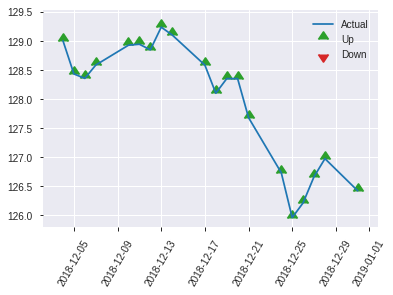


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2413394322993334
RMSE: 0.4912630988577642
LogLoss: 0.6758323685916754
Mean Per-Class Error: 0.3621671258034894
AUC: 0.6508111417202327
pr_auc: 0.6149100391226255
Gini: 0.3016222834404654
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4857005807548131: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      26   109  0.8074   (109.0/135.0)
1      9    112  0.0744   (9.0/121.0)
Total  35   221  0.4609   (118.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.485701     0.654971  218
max f2                       0.127667     0.819783  251
max f0point5                 0.530425     0.619546  112
max accuracy                 0.530425     0.640625  112
max precision                0.621953     1         0
max recall                   0.127667     1         251
max specificity              0.621953     1         0
max absolute_mcc             0.530425     0.277163  112
max min_per_class_accuracy   0.527054     0.636364  125
max mean_per_class_accuracy  0.530425     0.637833  112

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 50.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.605381           2.1157    2.1157             1                0.613887  1                           0.613887            0.0247934       0.0247934                  111.57    111.57
    2        0.0234375                   0.596041           1.41047   1.76309            0.666667         0.600366  0.833333                    0.607126            0.0165289       0.0413223                  41.0468   76.3085
    3        0.03125                     0.592509           1.05785   1.58678            0.5              0.595483  0.75                        0.604216            0.00826446      0.0495868                  5.78512   58.6777
    4        0.0429688                   0.588753           1.41047   1.53869            0.666667         0.589586  0.727273                    0.600226            0.0165289       0.0661157                  41.0468   53.8693
    5        0.0507812                   0.587542           2.1157    1.62746            1                0.588087  0.769231                    0.598358            0.0165289       0.0826446                  111.57    62.7463
    6        0.101562                    0.57579            1.13922   1.38334            0.538462         0.581837  0.653846                    0.590097            0.0578512       0.140496                   13.9224   38.3344
    7        0.152344                    0.564201           1.46472   1.41047            0.692308         0.569307  0.666667                    0.583167            0.0743802       0.214876                   46.4717   41.0468
    8        0.203125                    0.555011           1.62746   1.46472            0.769231         0.559067  0.692308                    0.577142            0.0826446       0.297521                   62.7463   46.4717
    9        0.300781                    0.540946           1.10017   1.34636            0.52             0.548186  0.636364                    0.567741            0.107438        0.404959                   10.0165   34.6356
    10       0.402344                    0.534655           1.13922   1.29407            0.538462         0.537632  0.61165                     0.56014             0.115702        0.520661                   13.9224   29.407
    11       0.5                         0.526739           1.26942   1.28926            0.6              0.529756  0.609375                    0.554206            0.123967        0.644628                   26.9421   28.9256
    12       0.601562                    0.520555           0.488239  1.15402            0.230769         0.523977  0.545455                    0.549102            0.0495868       0.694215                   -51.1761  15.402
    13       0.699219                    0.513968           0.846281  1.11104            0.4              0.517059  0.52514                     0.544627            0.0826446       0.77686                    -15.3719  11.1039
    14       0.800781                    0.501072           0.813732  1.07333            0.384615         0.507246  0.507317                    0.539886            0.0826446       0.859504                   -18.6268  7.3332
    15       0.898438                    0.430517           0.846281  1.04865            0.4              0.480331  0.495652                    0.533413            0.0826446       0.942149                   -15.3719  4.86525
    16       1                           0.0781048          0.569612  1                  0.269231         0.268145  0.472656                    0.506471            0

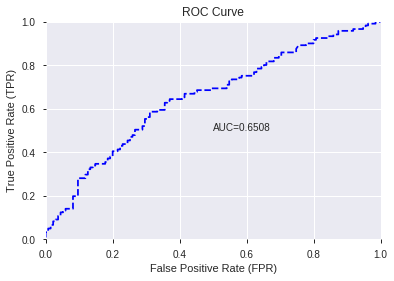

This function is available for GLM models only


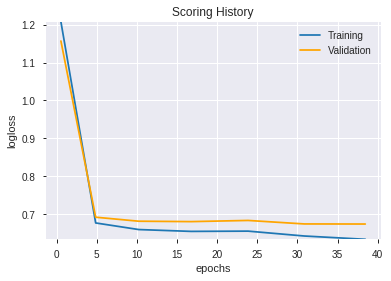

--2019-08-22 16:04:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.146.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.146.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_155619_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_155619_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_a7f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'SUB',
 'DIV',
 'STOCHF_fastk',
 'CDLGRAVESTONEDOJI',
 'CCI_8',
 'CDLRICKSHAWMAN',
 'CDLTAKURI',
 'COSH',
 'SINH',
 'EXP',
 'CDLHOMINGPIGEON',
 'CDLADVANCEBLOCK',
 'SAREXT',
 'STOCHRSI_fastk',
 'CDLEVENINGDOJISTAR',
 'CDLDARKCLOUDCOVER',
 'CDLDRAGONFLYDOJI',
 'CDLMORNINGDOJISTAR',
 'is_quarter_start',
 'CDLUNIQUE3RIVER',
 'CDLMORNINGSTAR',
 'CORREL_30',
 'CDLEVENINGSTAR',
 'CDLDOJI',
 'CDLONNECK',
 'CDLSEPARATINGLINES',
 'CDLLONGLEGGEDDOJI',
 'CORREL_8',
 'CDLSTALLEDPATTERN',
 'is_month_start',
 'HT_TRENDMODE',
 'is_quarter_end',
 'CDLTHRUSTING',
 'CDLLADDERBOTTOM',
 'quarter',
 'CDL3LINESTRIKE',
 'CDLMATCHINGLOW',
 'CORREL_20',
 'CDLSHOOTINGSTAR',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLINVERTEDHAMMER',
 'is_month_end',
 'CDLTASUKIGAP',
 'dayofyear',
 'weekofyear',
 'CDL3OUTSIDE',
 'week',
 'CDL3INSIDE']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_160411_model_1  0.651056  0.663973              0.422804  0.484926  0.235153

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.334978           1.000000    0.099953
1         STOCHF_fastk             0.324023           0.967298    0.096684
2                CCI_8             0.203713           0.608140    0.060785
3    CDLGRAVESTONEDOJI             0.188388           0.562390    0.056212
4                  SUB             0.163562           0.488278    0.048805
5       STOCHRSI_fastk             0.153147           0.457185    0.045697
6           CDL3INSIDE             0.129013           0.385140    0.038496
7    CDLSTALLEDPATTERN             0.122612           0.366029    0.036586
8                  DIV             0.106407           0.317653    0.031750
9   CDLMORNINGDOJISTAR             0.103571           0.309189    0.030904
10        CDLTASUKIGAP             0.099481           0.296979    0.029684
11      CDLMORNINGSTAR             0.099452           0.296891    0.029675
12      CDLRICKSHAWMAN             0.085847           0.256275    0.025615
13   CDLLONGLEGGEDDOJI             0.077549           0.231504    0.023139
14           CDLONNECK             0.068695           0.205074    0.020498
15      is_month_start             0.067511           0.201540    0.020144
16        CDLTHRUSTING             0.067499           0.201504    0.020141
17   CDLINVERTEDHAMMER             0.066056           0.197194    0.019710
18           CORREL_20             0.063255           0.188834    0.018874
19  CDLSEPARATINGLINES             0.059507           0.177645    0.017756
20           CDLTAKURI             0.055364           0.165277    0.016520
21       CDLHANGINGMAN             0.052091           0.155504    0.015543
22  CDLEVENINGDOJISTAR             0.051951           0.155088    0.015501
23      CDL3LINESTRIKE             0.047340           0.141323    0.014126
24      CDLEVENINGSTAR             0.047271           0.141117    0.014105
25         CDL3OUTSIDE             0.046811           0.139743    0.013968
26            CORREL_8             0.045630           0.136217    0.013615
27     CDLSHOOTINGSTAR             0.041941           0.125206    0.012515
28             quarter             0.040861           0.121982    0.012192
29      is_quarter_end             0.039628           0.118301    0.011824
30     CDLUNIQUE3RIVER             0.031563           0.094224    0.009418
31             CDLDOJI             0.029272           0.087384    0.008734
32     CDLHOMINGPIGEON             0.026716           0.079755    0.007972
33           CORREL_30             0.026238           0.078328    0.007829
34     CDLLADDERBOTTOM             0.023913           0.071388    0.007135
35           CDLHAMMER             0.020680           0.061736    0.006171
36              SAREXT             0.017363           0.051835    0.005181
37                COSH             0.015928           0.047549    0.004753
38                 EXP             0.015820           0.047228    0.004721
39                SINH             0.015770           0.047077    0.004705
40        HT_TRENDMODE             0.014460           0.043167    0.004315
41           dayofyear             0.013773           0.041115    0.004110
42     CDLADVANCEBLOCK             0.011697           0.034919    0.003490
43    is_quarter_start             0.009533           0.028458    0.002844
44          weekofyear             0.005970           0.017822    0.001781
45    CDLDRAGONFLYDOJI             0.005721           0.017078    0.001707
46                week             0.005585           0.016673    0.001667
47   CDLDARKCLOUDCOVER             0.005043           0.015053    0.001505
48      CDLMATCHINGLOW             0.003096           0.009243    0.000924
49        is_month_end             0.000073           0.000217    0.000022

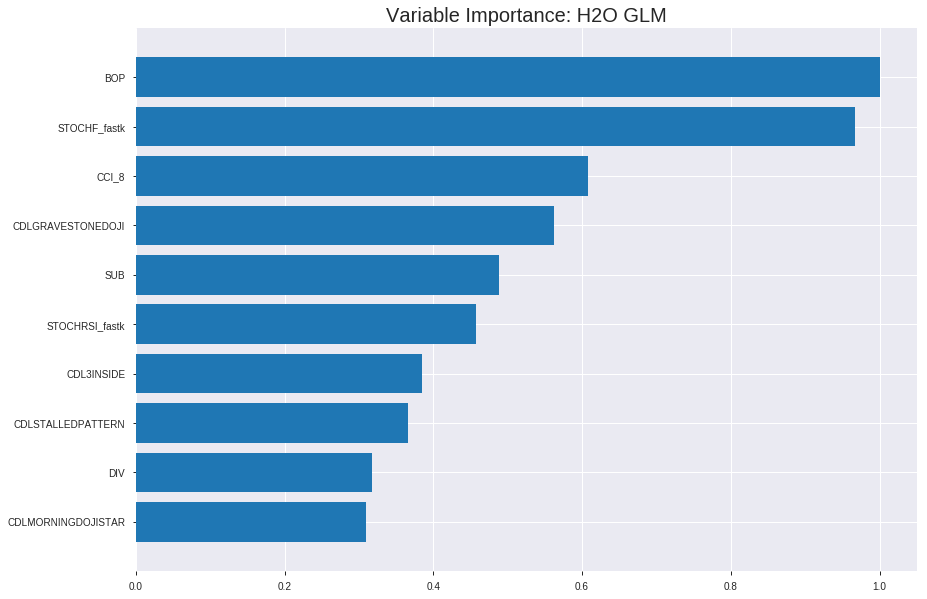

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_160411_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.22639411773004092
RMSE: 0.4758089088384547
LogLoss: 0.6420755551285267
Null degrees of freedom: 1787
Residual degrees of freedom: 1737
Null deviance: 2476.257522519208
Residual deviance: 2296.062185139611
AIC: 2398.062185139611
AUC: 0.6688886884245634
pr_auc: 0.624496946108301
Gini: 0.3377773768491268
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33670070850388645: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      208  719   0.7756   (719.0/927.0)
1      29   832   0.0337   (29.0/861.0)
Total  237  1551  0.4183   (748.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.336701     0.689884  310
max f2                       0.324598     0.836479  318
max f0point5                 0.450221     0.605634  225
max accuracy                 0.479284     0.61689   201
max precision                0.978292     1         0
max recall                   0.169489     1         381
max specificity              0.978292     1         0
max absolute_mcc             0.36414      0.281138  291
max min_per_class_accuracy   0.493654     0.609493  188
max mean_per_class_accuracy  0.450221     0.620519  225

Gains/Lift Table: Avg response rate: 48.15 %, avg score: 48.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.809238           1.96129   1.96129            0.944444         0.887048  0.944444                    0.887048            0.0197445       0.0197445                  96.1285   96.1285
    2        0.0201342                   0.754266           1.26907   1.61518            0.611111         0.77866   0.777778                    0.832854            0.0127758       0.0325203                  26.9067   61.5176
    3        0.0302013                   0.71812            1.49981   1.57672            0.722222         0.736871  0.759259                    0.80086             0.0150987       0.047619                   49.9806   57.672
    4        0.0402685                   0.695532           1.49981   1.55749            0.722222         0.706984  0.75                        0.777391            0.0150987       0.0627178                  49.9806   55.7491
    5        0.0503356                   0.681112           1.38444   1.52288            0.666667         0.687501  0.733333                    0.759413            0.0139373       0.0766551                  38.4437   52.288
    6        0.100112                    0.638373           1.30666   1.41537            0.629213         0.658783  0.681564                    0.709379            0.0650407       0.141696                   30.6659   41.5374
    7        0.150447                    0.599388           1.36136   1.3973             0.655556         0.618033  0.672862                    0.678817            0.068525        0.210221                   36.1363   39.7303
    8        0.200224                    0.578614           1.18999   1.34577            0.573034         0.588968  0.648045                    0.656481            0.0592334       0.269454                   18.9993   34.5765
    9        0.300336                    0.547137           1.18335   1.29163            0.569832         0.561961  0.621974                    0.624974            0.118467        0.387921                   18.3345   29.1625
    10       0.399888                    0.519134           1.16666   1.26052            0.561798         0.533839  0.606993                    0.602286            0.116144        0.504065                   16.666    26.0515
    11       0.5                         0.491601           1.11374   1.23113            0.536313         0.505622  0.592841                    0.582931            0.111498        0.615563                   11.3737   23.1127
    12       0.600112                    0.458986           1.04413   1.19993            0.502793         0.476004  0.577819                    0.565094            0.10453         0.720093                   4.41282   19.9931
    13       0.699664                    0.423933           1.00333   1.17196            0.483146         0.441577  0.564349                    0.547519            0.0998839       0.819977                   0.332772  17.1957
    14       0.799776                    0.375362           0.939715  1.14289            0.452514         0.401317  0.55035                     0.529218            0.0940767       0.914053                   -6.02846  14.2886
    15       0.899888                    0.315248           0.64968   1.08802            0.312849         0.347422  0.523928                    0.508993            0.0650407       0.979094                   -35.032   8.80175
    16       1                           0.0126875          0.208826  1                  0.100559         0.234802  0.481544                    0.481544           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.23696079508001625
RMSE: 0.4867861903135875
LogLoss: 0.6665760950436425
Null degrees of freedom: 510
Residual degrees of freedom: 460
Null deviance: 708.4284254426307
Residual deviance: 681.2407691346026
AIC: 783.2407691346026
AUC: 0.624402390438247
pr_auc: 0.5970774897592921
Gini: 0.24880478087649394
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39736351440700035: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      61   199  0.7654   (199.0/260.0)
1      22   229  0.0876   (22.0/251.0)
Total  83   428  0.4325   (221.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.397364     0.674521  326
max f2                       0.292012     0.832778  386
max f0point5                 0.454108     0.597148  271
max accuracy                 0.529342     0.594912  153
max precision                0.959408     1         0
max recall                   0.230097     1         395
max specificity              0.959408     1         0
max absolute_mcc             0.454108     0.214978  271
max min_per_class_accuracy   0.503258     0.589641  200
max mean_per_class_accuracy  0.454108     0.598475  271

Gains/Lift Table: Avg response rate: 49.12 %, avg score: 49.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.756832           1.69655   1.69655            0.833333         0.90689   0.833333                    0.90689             0.0199203       0.0199203                  69.6547   69.6547
    2        0.0215264                   0.710221           1.22151   1.48062            0.6              0.725744  0.727273                    0.824551            0.0119522       0.0318725                  22.1514   48.0623
    3        0.0313112                   0.689157           2.03586   1.65413            1                0.696149  0.8125                      0.784425            0.0199203       0.0517928                  103.586   65.4133
    4        0.0410959                   0.672888           1.62869   1.64807            0.8              0.68067   0.809524                    0.759722            0.0159363       0.0677291                  62.8685   64.8074
    5        0.0508806                   0.660877           1.22151   1.56604            0.6              0.666522  0.769231                    0.741799            0.0119522       0.0796813                  22.1514   56.6044
    6        0.101761                    0.623031           1.25283   1.40944            0.615385         0.637378  0.692308                    0.689588            0.063745        0.143426                   25.2835   40.9439
    7        0.150685                    0.599268           0.895777  1.24267            0.44             0.610153  0.61039                     0.663798            0.0438247       0.187251                   -10.4223  24.2666
    8        0.201566                    0.582741           1.17453   1.22547            0.576923         0.590536  0.601942                    0.645304            0.059761        0.247012                   17.4533   22.5467
    9        0.30137                     0.54764            1.11773   1.18979            0.54902          0.564281  0.584416                    0.618472            0.111554        0.358566                   11.7725   18.9786
    10       0.401174                    0.524125           1.31732   1.22151            0.647059         0.535448  0.6                         0.597817            0.131474        0.49004                    31.7319   22.1514
    11       0.500978                    0.499134           1.03789   1.18493            0.509804         0.513915  0.582031                    0.581102            0.103586        0.593625                   3.78877   18.4932
    12       0.600783                    0.479065           0.878213  1.13398            0.431373         0.489059  0.557003                    0.565812            0.0876494       0.681275                   -12.1787  13.3979
    13       0.700587                    0.454108           1.19756   1.14304            0.588235         0.467597  0.561453                    0.55182             0.119522        0.800797                   19.7563   14.3037
    14       0.800391                    0.416298           0.718538  1.0901             0.352941         0.436171  0.535452                    0.537399            0.0717131       0.87251                    -28.1462  9.01041
    15       0.900196                    0.358565           0.718538  1.04891            0.352941         0.388183  0.515217                    0.520856            0.0717131       0.944223                   -28.1462  4.89087
    16       1                           0.0175589          0.558863  1                  0.27451          0.304915  0.491194                    0.499304         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-22 16:04:12  0.000 sec   2            8.2       50            1.37738           1.38099
    2019-08-22 16:04:12  0.020 sec   4            5.1       50            1.37341           1.37824
    2019-08-22 16:04:12  0.033 sec   6            3.2       51            1.36781           1.37445
    2019-08-22 16:04:12  0.047 sec   8            2         51            1.3604            1.36959
    2019-08-22 16:04:12  0.062 sec   10           1.2       51            1.35127           1.36389
    2019-08-22 16:04:12  0.080 sec   12           0.76      51            1.34094           1.35786
    2019-08-22 16:04:12  0.093 sec   14           0.47      51            1.33017           1.35207
    2019-08-22 16:04:12  0.110 sec   16           0.29      51            1.3197            1.34692
    2019-08-22 16:04:12  0.125 sec   18           0.18      51            1.31006           1.34252
    2019-08-22 16:04:12  0.144 sec   20           0.11      51            1.30156           1.33886
    2019-08-22 16:04:12  0.156 sec   22           0.07      51            1.29436           1.33598
    2019-08-22 16:04:12  0.171 sec   24           0.043     51            1.28856           1.33402
    2019-08-22 16:04:12  0.187 sec   26           0.027     51            1.28415           1.33315
    2019-08-22 16:04:12  0.203 sec   28           0.017     51            1.28104           1.33335
    2019-08-22 16:04:12  0.221 sec   30           0.01      51            1.27899           1.3344
    2019-08-22 16:04:12  0.236 sec   32           0.0065    51            1.27769           1.33601
    2019-08-22 16:04:12  0.253 sec   34           0.004     51            1.27686           1.33788
    2019-08-22 16:04:12  0.263 sec   35           0.0025    51            1.27632           1.33965

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.625)

('F1', 0.6626865671641791)

('auc', 0.6510560146923783)

('logloss', 0.6639733420349365)

('mean_per_class_error', 0.3746862565044383)

('rmse', 0.4849259490662816)

('mse', 0.23515317607783393)

glm prediction progress: |████████████████████████████████████████████████| 100%


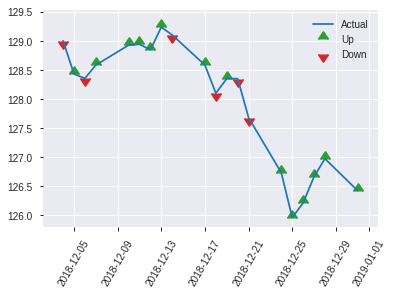


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.23515317607783393
RMSE: 0.4849259490662816
LogLoss: 0.6639733420349365
Null degrees of freedom: 255
Residual degrees of freedom: 205
Null deviance: 354.20638056124005
Residual deviance: 339.9543511218875
AIC: 441.9543511218875
AUC: 0.6510560146923783
pr_auc: 0.5933480144957912
Gini: 0.30211202938475656
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41333591617685195: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      32   103  0.763    (103.0/135.0)
1      10   111  0.0826   (10.0/121.0)
Total  42   214  0.4414   (113.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.413336     0.662687  213
max f2                       0.287299     0.820896  252
max f0point5                 0.519308     0.603015  118
max accuracy                 0.524601     0.625     112
max precision                0.930052     1         0
max recall                   0.287299     1         252
max specificity              0.930052     1         0
max absolute_mcc             0.487455     0.252764  145
max min_per_class_accuracy   0.510286     0.614815  126
max mean_per_class_accuracy  0.487455     0.625314  145

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 50.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.76762            0.705234  0.705234           0.333333         0.880756  0.333333                    0.880756            0.00826446      0.00826446                 -29.4766  -29.4766
    2        0.0234375                   0.689603           1.41047   1.05785            0.666667         0.701287  0.5                         0.791021            0.0165289       0.0247934                  41.0468   5.78512
    3        0.03125                     0.687089           1.05785   1.05785            0.5              0.687819  0.5                         0.765221            0.00826446      0.0330579                  5.78512   5.78512
    4        0.0429688                   0.670937           2.1157    1.34636            1                0.677249  0.636364                    0.741229            0.0247934       0.0578512                  111.57    34.6356
    5        0.0507812                   0.664563           2.1157    1.46472            1                0.667549  0.692308                    0.729893            0.0165289       0.0743802                  111.57    46.4717
    6        0.101562                    0.623087           1.62746   1.54609            0.769231         0.647469  0.730769                    0.688681            0.0826446       0.157025                   62.7463   54.609
    7        0.152344                    0.598546           1.46472   1.51897            0.692308         0.611102  0.717949                    0.662821            0.0743802       0.231405                   46.4717   51.8966
    8        0.203125                    0.574363           0.976478  1.38334            0.461538         0.587503  0.653846                    0.643992            0.0495868       0.280992                   -2.35219  38.3344
    9        0.300781                    0.554463           1.01554   1.26393            0.48             0.56419   0.597403                    0.618082            0.0991736       0.380165                   1.55372   26.3926
    10       0.402344                    0.533977           1.30197   1.27353            0.615385         0.543679  0.601942                    0.599301            0.132231        0.512397                   30.1971   27.353
    11       0.5                         0.510254           1.18479   1.2562             0.56             0.52218   0.59375                     0.584238            0.115702        0.628099                   18.4793   25.6198
    12       0.601562                    0.479316           0.895105  1.19523            0.423077         0.493874  0.564935                    0.568982            0.0909091       0.719008                   -10.4895  19.5235
    13       0.699219                    0.453521           0.761653  1.13468            0.36             0.468529  0.536313                    0.554952            0.0743802       0.793388                   -23.8347  13.4678
    14       0.800781                    0.425435           0.976478  1.11461            0.461538         0.439067  0.526829                    0.540254            0.0991736       0.892562                   -2.35219  11.4614
    15       0.898438                    0.380607           0.592397  1.05785            0.28             0.402698  0.5                         0.525303            0.0578512       0.950413                   -40.7603  5.78512
    16       1                           0.101116           0.488239  1                  0.230769         0.323128  0.472656                    0.504769          

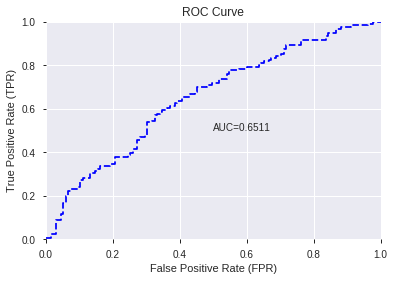

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


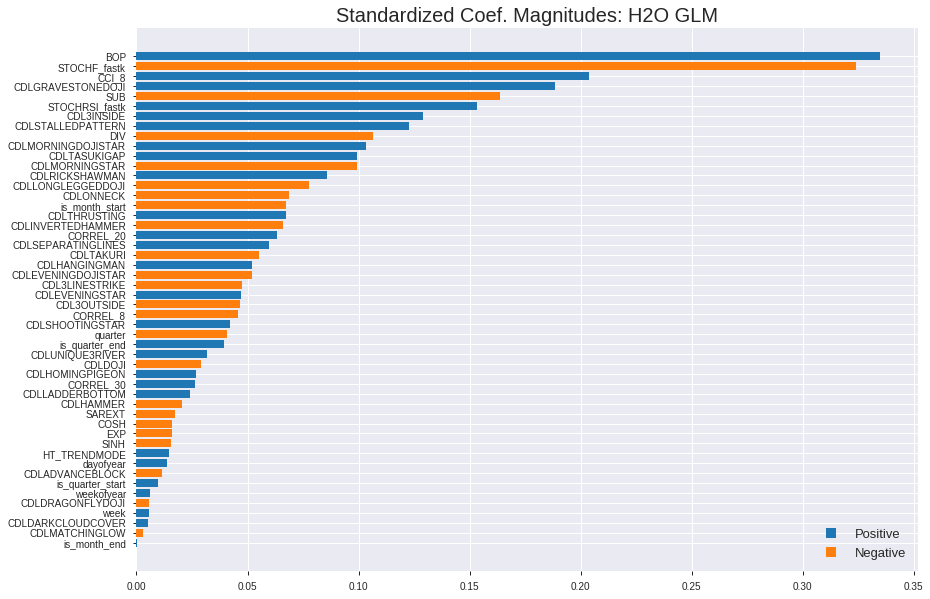

'log_likelihood'
--2019-08-22 16:04:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.137.68
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.137.68|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_160411_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_160411_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_a7f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'STOCHF_fastk',
 'CCI_8',
 'CDLGRAVESTONEDOJI',
 'SUB',
 'STOCHRSI_fastk',
 'CDL3INSIDE',
 'CDLSTALLEDPATTERN',
 'DIV',
 'CDLMORNINGDOJISTAR',
 'CDLTASUKIGAP',
 'CDLMORNINGSTAR',
 'CDLRICKSHAWMAN',
 'CDLLONGLEGGEDDOJI',
 'CDLONNECK',
 'is_month_start',
 'CDLTHRUSTING',
 'CDLINVERTEDHAMMER',
 'CORREL_20',
 'CDLSEPARATINGLINES',
 'CDLTAKURI',
 'CDLHANGINGMAN',
 'CDLEVENINGDOJISTAR',
 'CDL3LINESTRIKE',
 'CDLEVENINGSTAR',
 'CDL3OUTSIDE',
 'CORREL_8',
 'CDLSHOOTINGSTAR',
 'quarter',
 'is_quarter_end',
 'CDLUNIQUE3RIVER',
 'CDLDOJI',
 'CDLHOMINGPIGEON',
 'CORREL_30',
 'CDLLADDERBOTTOM',
 'CDLHAMMER',
 'SAREXT',
 'COSH',
 'EXP',
 'SINH',
 'HT_TRENDMODE',
 'dayofyear',
 'CDLADVANCEBLOCK',
 'is_quarter_start',
 'weekofyear',
 'CDLDRAGONFLYDOJI',
 'week',
 'CDLDARKCLOUDCOVER',
 'CDLMATCHINGLOW',
 'is_month_end']

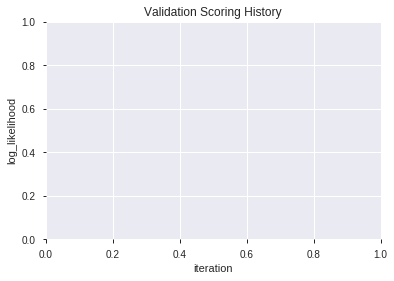

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190822_160427  0.705663  0.643579              0.340618  0.475337  0.225945
1               XGBoost_3_AutoML_20190822_160427  0.696602  0.647946              0.346740  0.477590  0.228093
2  XGBoost_grid_1_AutoML_20190822_160427_model_2  0.695439  0.649661              0.361126  0.478285  0.228757
3  XGBoost_grid_1_AutoML_20190822_160427_model_7  0.694949  0.647211              0.381359  0.477296  0.227812
4  XGBoost_grid_1_AutoML_20190822_160427_model_6  0.679400  0.654358              0.392317  0.480833  0.231200
5  XGBoost_grid_1_AutoML_20190822_160427_model_5  0.675421  0.663124              0.382492  0.484635  0.234871
6  XGBoost_grid_1_AutoML_20190822_160427_model_1  0.670830  0.655435              0.442455  0.481425  0.231770
7  XGBoost_grid_1_AutoML_20190822_160427_model_4  0.667585  0.657075              0.396021  0.482073  0.232394
8  XGBoost_grid_1_AutoML_20190822_160427_model_3  0.662381  0.660279              0.421518  0.483892  0.234151
9               XGBoost_2_AutoML_20190822_160427  0.646954  0.668206              0.377227  0.487474  0.237631

variable  relative_importance  scaled_importance  percentage
0                 BOP           673.511841           1.000000    0.103646
1                 SUB           638.894043           0.948601    0.098319
2        STOCHF_fastk           604.212158           0.897107    0.092982
3               CCI_8           598.643494           0.888839    0.092125
4           CORREL_30           529.530029           0.786222    0.081489
5            CORREL_8           488.789032           0.725732    0.075219
6                 DIV           453.092529           0.672731    0.069726
7           CORREL_20           428.238831           0.635830    0.065901
8           dayofyear           392.740936           0.583124    0.060439
9                COSH           387.154785           0.574830    0.059579
10     STOCHRSI_fastk           296.727692           0.440568    0.045663
11             SAREXT           291.114624           0.432234    0.044799
12                EXP           114.793243           0.170440    0.017665
13  CDLGRAVESTONEDOJI           103.357071           0.153460    0.015906
14               week            94.614334           0.140479    0.014560
15   CDLDRAGONFLYDOJI            78.830414           0.117044    0.012131
16         weekofyear            75.794632           0.112536    0.011664
17            CDLDOJI            50.854103           0.075506    0.007826
18     CDLRICKSHAWMAN            48.701824           0.072310    0.007495
19          CDLTAKURI            39.524189           0.058684    0.006082
20       HT_TRENDMODE            34.101120           0.050632    0.005248
21               SINH            30.602978           0.045438    0.004709
22            quarter            22.758089           0.033790    0.003502
23  CDLLONGLEGGEDDOJI            18.324564           0.027207    0.002820
24       is_month_end             3.269386           0.004854    0.000503

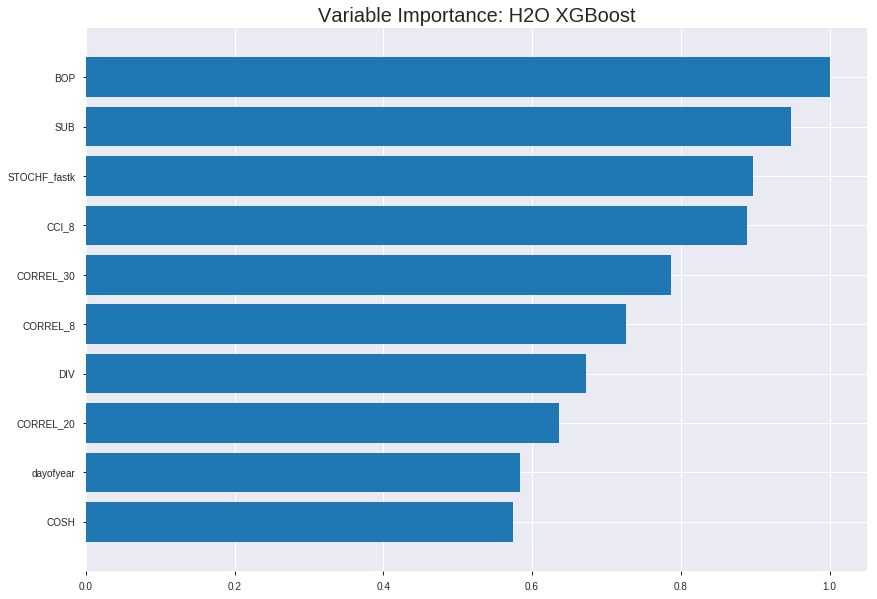

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190822_160427


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16309684393675303
RMSE: 0.40385250269962797
LogLoss: 0.5084688473642837
Mean Per-Class Error: 0.16577773267330453
AUC: 0.9126432850089018
pr_auc: 0.909163228918918
Gini: 0.8252865700178036
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.487662007411321: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      751  176  0.1899   (176.0/927.0)
1      122  739  0.1417   (122.0/861.0)
Total  873  915  0.1667   (298.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.487662     0.832207  196
max f2                       0.37743      0.886876  271
max f0point5                 0.555674     0.84501   148
max accuracy                 0.514152     0.833333  177
max precision                0.863999     1         0
max recall                   0.191639     1         373
max specificity              0.863999     1         0
max absolute_mcc             0.487662     0.668173  196
max min_per_class_accuracy   0.50323      0.829268  185
max mean_per_class_accuracy  0.487662     0.834222  196

Gains/Lift Table: Avg response rate: 48.15 %, avg score: 48.26 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.782169           2.07666    2.07666            1                0.801342  1                           0.801342            0.0209059       0.0209059                  107.666   107.666
    2        0.0201342                   0.756284           2.07666    2.07666            1                0.772241  1                           0.786792            0.0209059       0.0418118                  107.666   107.666
    3        0.0302013                   0.742188           2.07666    2.07666            1                0.750084  1                           0.774556            0.0209059       0.0627178                  107.666   107.666
    4        0.0402685                   0.734003           2.07666    2.07666            1                0.738303  1                           0.765493            0.0209059       0.0836237                  107.666   107.666
    5        0.0503356                   0.723055           2.07666    2.07666            1                0.726866  1                           0.757767            0.0209059       0.10453                    107.666   107.666
    6        0.100112                    0.685242           1.98332    2.03025            0.955056         0.703899  0.977654                    0.730984            0.0987224       0.203252                   98.3322   103.025
    7        0.150447                    0.658946           2.03051    2.03034            0.977778         0.671781  0.977695                    0.711176            0.102207        0.305459                   103.051   103.034
    8        0.200224                    0.637866           2.00666    2.02445            0.966292         0.64947   0.97486                     0.695836            0.0998839       0.405343                   100.666   102.445
    9        0.300336                    0.587498           1.71701    1.92197            0.826816         0.61127   0.925512                    0.667647            0.171893        0.577236                   71.7011   92.1969
    10       0.399888                    0.542367           1.50499    1.81816            0.724719         0.564612  0.875524                    0.641996            0.149826        0.727062                   50.4992   81.8162
    11       0.5                         0.49305            1.17174    1.68873            0.564246         0.51955   0.813199                    0.61748             0.117305        0.844367                   17.1744   68.8734
    12       0.600112                    0.445119           0.696085   1.52314            0.335196         0.469251  0.733458                    0.592752            0.0696864       0.914053                   -30.3915  52.3138
    13       0.699664                    0.392736           0.501664   1.3778             0.241573         0.420685  0.663469                    0.568269            0.0499419       0.963995                   -49.8336  37.7797
    14       0.799776                    0.326094           0.220427   1.23292            0.106145         0.362894  0.593706                    0.542561            0.0220674       0.986063                   -77.9573  23.2923
    15       0.899888                    0.251766           0.127616   1.10996            0.0614525        0.287927  0.534493                    0.514233            0.0127758       0.998839                   -87.2384  10.9959
    16       1                           0.107044           0.0116014  1                  0.00558659       0.197928  0.481544                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2405537741627747
RMSE: 0.4904628162896497
LogLoss: 0.6741876614786715
Mean Per-Class Error: 0.387036469506589
AUC: 0.6202344468280724
pr_auc: 0.5656166169740128
Gini: 0.24046889365614477
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40430161356925964: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      49   211  0.8115   (211.0/260.0)
1      13   238  0.0518   (13.0/251.0)
Total  62   449  0.4384   (224.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.404302     0.68      338
max f2                       0.27733      0.835561  380
max f0point5                 0.521966     0.607628  244
max accuracy                 0.523166     0.610568  242
max precision                0.823408     1         0
max recall                   0.219654     1         390
max specificity              0.823408     1         0
max absolute_mcc             0.521966     0.234476  244
max min_per_class_accuracy   0.556937     0.580769  199
max mean_per_class_accuracy  0.521966     0.612964  244

Gains/Lift Table: Avg response rate: 49.12 %, avg score: 54.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117417                   0.780669           1.01793   1.01793            0.5              0.797381  0.5                         0.797381            0.0119522       0.0119522                  1.79283    1.79283
    2        0.0215264                   0.768253           0.407171  0.740311           0.2              0.776576  0.363636                    0.787924            0.00398406      0.0159363                  -59.2829   -25.9689
    3        0.0313112                   0.755065           2.03586   1.14517            1                0.760207  0.5625                      0.779263            0.0199203       0.0358566                  103.586    14.5169
    4        0.0410959                   0.744273           2.03586   1.35724            1                0.748876  0.666667                    0.772028            0.0199203       0.0557769                  103.586    35.7238
    5        0.0508806                   0.739845           1.62869   1.40944            0.8              0.742522  0.692308                    0.766354            0.0159363       0.0717131                  62.8685    40.9439
    6        0.101761                    0.692441           0.861324  1.13538            0.423077         0.715908  0.557692                    0.741131            0.0438247       0.115538                   -13.8676   13.5382
    7        0.150685                    0.66882            1.05865   1.11047            0.52             0.678541  0.545455                    0.72081             0.0517928       0.167331                   5.86454    11.0467
    8        0.201566                    0.651438           1.17453   1.12664            0.576923         0.66003   0.553398                    0.705467            0.059761        0.227092                   17.4533    12.6639
    9        0.30137                     0.618858           1.2774    1.17657            0.627451         0.635755  0.577922                    0.682381            0.12749         0.354582                   27.74      17.6566
    10       0.401174                    0.587886           1.2774    1.20165            0.627451         0.604326  0.590244                    0.662962            0.12749         0.482072                   27.74      20.1652
    11       0.500978                    0.55656            1.03789   1.16903            0.509804         0.571301  0.574219                    0.644701            0.103586        0.585657                   3.78877    16.9027
    12       0.600783                    0.528809           1.11773   1.1605             0.54902          0.541913  0.570033                    0.627626            0.111554        0.697211                   11.7725    16.0505
    13       0.700587                    0.499724           0.997969  1.13735            0.490196         0.515726  0.558659                    0.611685            0.0996016       0.796813                   -0.203109  13.735
    14       0.800391                    0.458245           0.95805   1.11499            0.470588         0.477358  0.547677                    0.594935            0.0956175       0.89243                    -4.19498   11.4992
    15       0.900196                    0.387654           0.6387    1.06219            0.313725         0.422527  0.521739                    0.57582             0.063745        0.956175                   -36.13     6.2186
    16       1                           0.124641           0.439106  1                  0.215686         0.288368  0.491194                    0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:04:27  0.006 sec   0                  0.5              0.693147            0.5             0                  1                0.518456                         0.5                0.693147              0.5               0                    1                  0.508806
    2019-08-22 16:04:27  0.160 sec   5                  0.483877         0.661311            0.799521        0.766785           1.96129          0.299217                         0.49731            0.68777               0.571253          0.523775             0.678619           0.495108
    2019-08-22 16:04:27  0.262 sec   10                 0.470065         0.63449             0.832152        0.813201           2.07666          0.260067                         0.493943           0.680997              0.598261          0.555433             1.01793            0.412916
    2019-08-22 16:04:28  0.358 sec   15                 0.458439         0.612092            0.848135        0.833841           2.07666          0.23434                          0.491562           0.676111              0.600682          0.561326             1.01793            0.450098
    2019-08-22 16:04:28  0.464 sec   20                 0.447948         0.591997            0.863731        0.855138           2.07666          0.229866                         0.489151           0.671259              0.622885          0.567577             1.35724            0.405088
    2019-08-22 16:04:28  0.570 sec   25                 0.438702         0.574392            0.878687        0.871032           2.07666          0.208613                         0.48865            0.670141              0.619729          0.56332              1.01793            0.440313
    2019-08-22 16:04:28  0.676 sec   30                 0.43039          0.5586              0.886481        0.880648           2.07666          0.195749                         0.488935           0.670701              0.617913          0.558052             1.01793            0.440313
    2019-08-22 16:04:28  0.783 sec   35                 0.422028         0.542825            0.896257        0.891573           2.07666          0.191834                         0.487496           0.667643              0.627712          0.570529             1.01793            0.424658
    2019-08-22 16:04:28  0.889 sec   40                 0.415433         0.530259            0.900876        0.895723           2.07666          0.176734                         0.488739           0.67028               0.621782          0.56663              1.35724            0.412916
    2019-08-22 16:04:28  0.993 sec   45                 0.409419         0.518862            0.906376        0.901915           2.07666          0.176174                         0.488834           0.67058               0.625153          0.569258             1.35724            0.414873
    2019-08-22 16:04:28  1.097 sec   50                 0.403853         0.508469            0.912643        0.909163           2.07666          0.166667                         0.490463           0.674188              0.620234          0.565617             1.01793            0.438356

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
BOP                673.5118408203125      1.0                   0.10364629196507355
SUB                638.89404296875        0.9486010553141883    0.09831898193747124
STOCHF_fastk       604.212158203125       0.8971069572692545    0.0929818096170279
CCI_8              598.6434936523438      0.8888388553395262    0.09212485151042231
CORREL_30          529.530029296875       0.7862223010837152    0.08148902616757471
---                ---                    ---                   ---
HT_TRENDMODE       34.10111999511719      0.05063180471123312   0.0052477988138190535
SINH               30.602977752685547     0.045437920906352965  0.004709472016545779
quarter            22.758089065551758     0.03379018405650188   0.0035022272822737674
CDLLONGLEGGEDDOJI  18.32456398010254      0.027207486000222207  0.0028199550376146816
is_month_end       3.269385814666748      0.004854236579842096  0.000503123621821854


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.66015625)

('F1', 0.697986577181208)

('auc', 0.7056626874808694)

('logloss', 0.6435786326788436)

('mean_per_class_error', 0.33250688705234155)

('rmse', 0.47533661917584236)

('mse', 0.2259449015295198)

xgboost prediction progress: |████████████████████████████████████████████| 100%


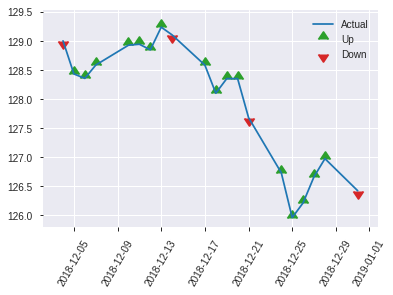


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2259449015295198
RMSE: 0.47533661917584236
LogLoss: 0.6435786326788436
Mean Per-Class Error: 0.33250688705234155
AUC: 0.7056626874808694
pr_auc: 0.6390845880386674
Gini: 0.4113253749617387
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48491814732551575: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   73   0.5407   (73.0/135.0)
1      17   104  0.1405   (17.0/121.0)
Total  79   177  0.3516   (90.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.484918     0.697987  176
max f2                       0.30614      0.820793  246
max f0point5                 0.621816     0.642674  66
max accuracy                 0.513513     0.660156  149
max precision                0.752973     1         0
max recall                   0.218247     1         253
max specificity              0.752973     1         0
max absolute_mcc             0.505613     0.345455  159
max min_per_class_accuracy   0.541487     0.644628  124
max mean_per_class_accuracy  0.505613     0.667493  159

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 53.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.731315           0.705234  0.705234           0.333333         0.741902  0.333333                    0.741902            0.00826446      0.00826446                 -29.4766  -29.4766
    2        0.0234375                   0.713604           2.1157    1.41047            1                0.72356   0.666667                    0.732731            0.0247934       0.0330579                  111.57    41.0468
    3        0.03125                     0.707788           2.1157    1.58678            1                0.709695  0.75                        0.726972            0.0165289       0.0495868                  111.57    58.6777
    4        0.0429688                   0.704855           1.41047   1.53869            0.666667         0.706943  0.727273                    0.721509            0.0165289       0.0661157                  41.0468   53.8693
    5        0.0507812                   0.698376           1.05785   1.46472            0.5              0.700559  0.692308                    0.718286            0.00826446      0.0743802                  5.78512   46.4717
    6        0.101562                    0.674401           1.46472   1.46472            0.692308         0.686999  0.692308                    0.702642            0.0743802       0.14876                    46.4717   46.4717
    7        0.152344                    0.65735            1.79021   1.57321            0.846154         0.666808  0.74359                     0.690698            0.0909091       0.239669                   79.021    57.3215
    8        0.203125                    0.639165           1.46472   1.54609            0.692308         0.645884  0.730769                    0.679494            0.0743802       0.31405                    46.4717   54.609
    9        0.300781                    0.606861           1.26942   1.45626            0.6              0.622576  0.688312                    0.661014            0.123967        0.438017                   26.9421   45.6263
    10       0.402344                    0.572269           1.13922   1.37623            0.538462         0.588191  0.650485                    0.642632            0.115702        0.553719                   13.9224   37.6234
    11       0.5                         0.535896           0.930909  1.28926            0.44             0.551645  0.609375                    0.624861            0.0909091       0.644628                   -6.90909  28.9256
    12       0.601562                    0.510503           1.13922   1.26393            0.538462         0.522391  0.597403                    0.607561            0.115702        0.760331                   13.9224   26.3926
    13       0.699219                    0.480836           1.01554   1.22923            0.48             0.497423  0.581006                    0.592178            0.0991736       0.859504                   1.55372   22.9235
    14       0.800781                    0.427642           0.488239  1.13525            0.230769         0.450582  0.536585                    0.57422             0.0495868       0.909091                   -51.1761  13.5255
    15       0.898438                    0.376639           0.507769  1.06705            0.24             0.403584  0.504348                    0.555672            0.0495868       0.958678                   -49.2231  6.70499
    16       1                           0.109064           0.406866  1                  0.192308         0.310899  0.472656                    0.530813         

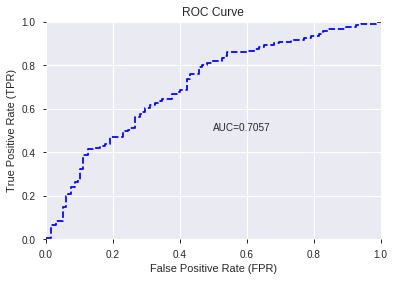

This function is available for GLM models only


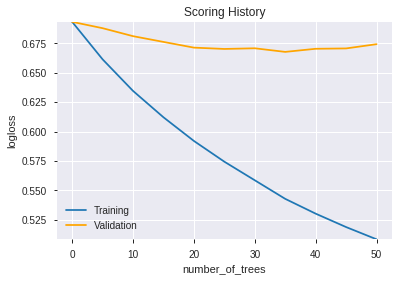

--2019-08-22 16:04:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.238.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.238.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190822_160427',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190822_160427',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_a7f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_66_sid_a7f4',
   'type

['BOP',
 'SUB',
 'STOCHF_fastk',
 'CCI_8',
 'CORREL_30',
 'CORREL_8',
 'DIV',
 'CORREL_20',
 'dayofyear',
 'COSH',
 'STOCHRSI_fastk',
 'SAREXT',
 'EXP',
 'CDLGRAVESTONEDOJI',
 'week',
 'CDLDRAGONFLYDOJI',
 'weekofyear',
 'CDLDOJI',
 'CDLRICKSHAWMAN',
 'CDLTAKURI',
 'HT_TRENDMODE',
 'SINH',
 'quarter',
 'CDLLONGLEGGEDDOJI',
 'is_month_end']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [916] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


9

['BOP',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'CDLGRAVESTONEDOJI',
 'CDLTAKURI',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_160457_model_3  0.689073  0.675235              0.390909  0.489730  0.239835
1  DeepLearning_grid_1_AutoML_20190822_160457_model_6  0.688889  0.676037              0.440465  0.490548  0.240638
2               DeepLearning_1_AutoML_20190822_160457  0.649832  0.690626              0.443740  0.498677  0.248678
3  DeepLearning_grid_1_AutoML_20190822_160457_model_1  0.648424  0.729939              0.435904  0.509288  0.259374
4  DeepLearning_grid_1_AutoML_20190822_160457_model_2  0.630976  0.681372              0.440894  0.493658  0.243698
5  DeepLearning_grid_1_AutoML_20190822_160457_model_4  0.627487  0.670184              0.443312  0.487506  0.237663
6  DeepLearning_grid_1_AutoML_20190822_160457_model_7  0.604224  0.689791              0.464249  0.496958  0.246967
7  DeepLearning_grid_1_AutoML_20190822_160457_model_5  0.595990  0.673790              0.475360  0.490025  0.240124

variable  relative_importance  scaled_importance  percentage
0       CDLENGULFING             1.000000           1.000000    0.127234
1             TRANGE             0.899660           0.899660    0.114467
2                BOP             0.882182           0.882182    0.112243
3          CDLTAKURI             0.876588           0.876588    0.111532
4                SUB             0.858306           0.858306    0.109206
5   CDLDRAGONFLYDOJI             0.852031           0.852031    0.108407
6        CDLBELTHOLD             0.842793           0.842793    0.107232
7                DIV             0.825610           0.825610    0.105045
8  CDLGRAVESTONEDOJI             0.822379           0.822379    0.104634

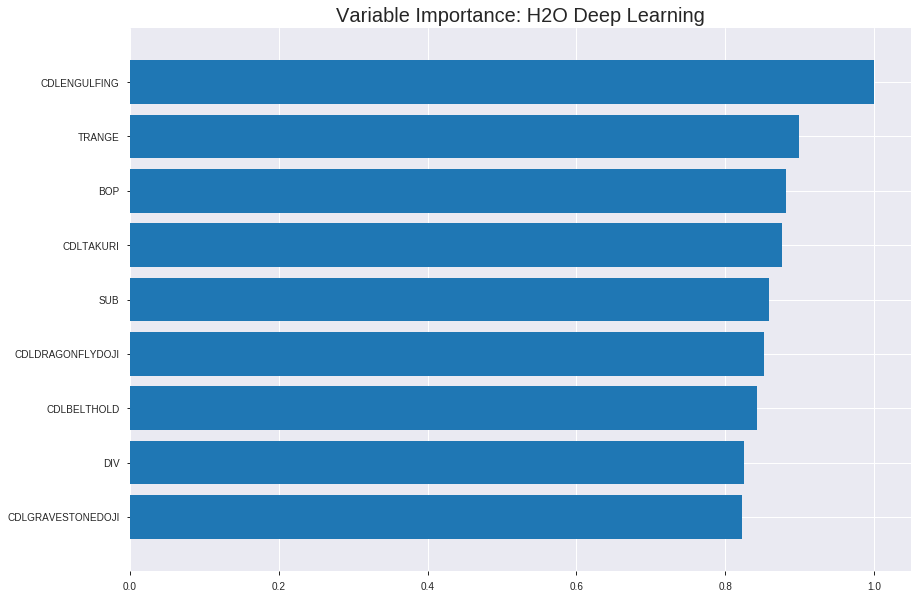

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_160457_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23293996446651766
RMSE: 0.4826385443233038
LogLoss: 0.6579766534080986
Mean Per-Class Error: 0.38467349999436196
AUC: 0.6461447577952433
pr_auc: 0.5991457372417641
Gini: 0.29228951559048655
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3146796771389058: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      132  795   0.8576   (795.0/927.0)
1      24   837   0.0279   (24.0/861.0)
Total  156  1632  0.4581   (819.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.31468      0.67148   324
max f2                       0.260045     0.828131  343
max f0point5                 0.465083     0.601327  227
max accuracy                 0.472742     0.60906   221
max precision                0.96257      1         0
max recall                   0.0182293    1         395
max specificity              0.96257      1         0
max absolute_mcc             0.465083     0.247194  227
max min_per_class_accuracy   0.525785     0.60511   176
max mean_per_class_accuracy  0.465083     0.615327  227

Gains/Lift Table: Avg response rate: 48.15 %, avg score: 51.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.776024           1.84592   1.84592            0.888889         0.93607   0.888889                    0.93607             0.018583        0.018583                   84.5916   84.5916
    2        0.0201342                   0.73787            1.61518   1.73055            0.777778         0.754136  0.833333                    0.845103            0.0162602       0.0348432                  61.5176   73.0546
    3        0.0302013                   0.727252           0.922958  1.46135            0.444444         0.731704  0.703704                    0.807303            0.00929152      0.0441347                  -7.70422  46.135
    4        0.0402685                   0.71949            1.03833   1.35559            0.5              0.722854  0.652778                    0.786191            0.010453        0.0545877                  3.83275   35.5594
    5        0.0503356                   0.711622           1.1537    1.31521            0.555556         0.716473  0.633333                    0.772247            0.0116144       0.0662021                  15.3697   31.5215
    6        0.100112                    0.675484           1.28333   1.29936            0.617978         0.693006  0.625698                    0.732848            0.0638792       0.130081                   28.3326   29.936
    7        0.150447                    0.648187           1.26907   1.28922            0.611111         0.661764  0.620818                    0.709065            0.0638792       0.193961                   26.9067   28.9225
    8        0.200224                    0.625806           1.37666   1.31096            0.662921         0.636823  0.631285                    0.691106            0.068525        0.262485                   37.6659   31.0961
    9        0.300336                    0.584796           1.20655   1.27616            0.581006         0.604056  0.614525                    0.662089            0.12079         0.383275                   20.6548   27.6157
    10       0.399888                    0.553601           1.20166   1.25761            0.578652         0.567677  0.605594                    0.638585            0.119628        0.502904                   20.166    25.7611
    11       0.5                         0.524666           1.07893   1.22184            0.519553         0.53823   0.588367                    0.618492            0.108014        0.610918                   7.89325   22.1835
    12       0.600112                    0.493595           1.00932   1.18638            0.486034         0.509955  0.571295                    0.600385            0.101045        0.711963                   0.932396  18.6384
    13       0.699664                    0.457238           1.01499   1.162              0.488764         0.475856  0.559552                    0.582667            0.101045        0.813008                   1.49943   16.1997
    14       0.799776                    0.405726           0.719288  1.10658            0.346369         0.43238   0.532867                    0.563855            0.0720093       0.885017                   -28.0712  10.6581
    15       0.899888                    0.33043            0.742491  1.06608            0.357542         0.372161  0.513362                    0.542529            0.0743322       0.95935                    -25.7509  6.60765
    16       1                           0.00610812         0.40605   1                  0.195531         0.219424  0.481544                    0.510182           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24329225658621523
RMSE: 0.49324664883424724
LogLoss: 0.6816637104016768
Mean Per-Class Error: 0.4120517928286853
AUC: 0.6143273061599754
pr_auc: 0.5743248282861405
Gini: 0.22865461231995088
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41439456331142255: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      32   228  0.8769   (228.0/260.0)
1      7    244  0.0279   (7.0/251.0)
Total  39   472  0.4599   (235.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.414395     0.674965  360
max f2                       0.245654     0.831126  394
max f0point5                 0.509327     0.587376  277
max accuracy                 0.57328      0.589041  167
max precision                0.721741     0.695652  20
max recall                   0.245654     1         394
max specificity              0.928437     0.996154  0
max absolute_mcc             0.509327     0.188157  277
max min_per_class_accuracy   0.561127     0.577689  193
max mean_per_class_accuracy  0.570101     0.587948  175

Gains/Lift Table: Avg response rate: 49.12 %, avg score: 55.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117417                   0.742338           0.678619  0.678619           0.333333         0.808179  0.333333                    0.808179            0.00796813      0.00796813                 -32.1381   -32.1381
    2        0.0215264                   0.733618           1.62869   1.11047            0.8              0.737533  0.545455                    0.776067            0.0159363       0.0239044                  62.8685    11.0467
    3        0.0313112                   0.726805           1.62869   1.27241            0.8              0.729707  0.625                       0.761579            0.0159363       0.0398406                  62.8685    27.241
    4        0.0410959                   0.723357           1.62869   1.35724            0.8              0.725419  0.666667                    0.75297             0.0159363       0.0557769                  62.8685    35.7238
    5        0.0508806                   0.717093           0.814343  1.25283            0.4              0.72066   0.615385                    0.746756            0.00796813      0.063745                   -18.5657   25.2835
    6        0.101761                    0.688317           1.33114   1.29199            0.653846         0.702193  0.634615                    0.724475            0.0677291       0.131474                   33.1137    29.1986
    7        0.150685                    0.652848           1.38438   1.32198            0.68             0.673295  0.649351                    0.707858            0.0677291       0.199203                   38.4382    32.1985
    8        0.201566                    0.624993           1.01793   1.24523            0.5              0.638397  0.61165                     0.690324            0.0517928       0.250996                   1.79283    24.5233
    9        0.30137                     0.5939             1.07781   1.18979            0.529412         0.608767  0.584416                    0.663315            0.10757         0.358566                   7.78064    18.9786
    10       0.401174                    0.574468           1.19756   1.19172            0.588235         0.583946  0.585366                    0.64357             0.119522        0.478088                   19.7563    19.1721
    11       0.500978                    0.559071           0.997969  1.15312            0.490196         0.567646  0.566406                    0.628444            0.0996016       0.577689                   -0.203109  15.3122
    12       0.600783                    0.53595            1.03789   1.13398            0.509804         0.547238  0.557003                    0.614954            0.103586        0.681275                   3.78877    13.3979
    13       0.700587                    0.511604           0.997969  1.1146             0.490196         0.522235  0.547486                    0.601745            0.0996016       0.780876                   -0.203109  11.4603
    14       0.800391                    0.485029           0.918131  1.0901             0.45098          0.499192  0.535452                    0.588957            0.0916335       0.87251                    -8.18686   9.01041
    15       0.900196                    0.429152           0.6387    1.04006            0.313725         0.457448  0.51087                     0.574377            0.063745        0.936255                   -36.13     4.00572
    16       1                           0.106786           0.6387    1                  0.313725         0.338343  0.491194                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:05:58  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 16:05:59  1 min  0.363 sec  14875 obs/sec     10        1             17880      0.482639         0.657977            0.0669688      0.646145        0.599146           1.84592          0.458054                         0.493247           0.681664              0.026529         0.614327          0.574325             0.678619           0.459883
    2019-08-22 16:06:04  1 min  5.607 sec  19550 obs/sec     70        7             125160     0.484255         0.659791            0.0607082      0.649019        0.612023           1.73055          0.446868                         0.499134           0.694202              0.00315312       0.608328          0.560063             0.678619           0.436399
    2019-08-22 16:06:10  1 min 11.038 sec  24260 obs/sec     160       16            286080     0.481372         0.654899            0.0718578      0.655662        0.615059           1.84592          0.447427                         0.499332           0.700996              0.00236133       0.601502          0.557136             0.678619           0.475538
    2019-08-22 16:06:15  1 min 16.305 sec  27313 obs/sec     260       26            464880     0.478268         0.647078            0.0837888      0.66321         0.627056           1.84592          0.436801                         0.495272           0.690143              0.0185174        0.616358          0.563547             0.678619           0.454012
    2019-08-22 16:06:20  1 min 21.790 sec  29453 obs/sec     370       37            661560     0.47832          0.647909            0.0835925      0.660392        0.625706           1.73055          0.454698                         0.497732           0.699967              0.00874249       0.602069          0.55764              0.678619           0.457926
    2019-08-22 16:06:26  1 min 27.192 sec  30854 obs/sec     480       48            858240     0.478047         0.646339            0.084637       0.657667        0.628527           1.84592          0.455817                         0.499012           0.701394              0.00364063       0.591618          0.553588             1.01793            0.479452
    2019-08-22 16:06:26  1 min 27.258 sec  30846 obs/sec     480       48            858240     0.482639         0.657977            0.0669688      0.646145        0.599146           1.84592          0.458054                         0.493247           0.681664              0.026529         0.614327          0.574325             0.678619           0.459883

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
CDLENGULFING       1                      1                    0.127234
TRANGE             0.89966                0.89966              0.114467
BOP                0.882182               0.882182             0.112243
CDLTAKURI          0.876588               0.876588             0.111532
SUB                0.858306               0.858306             0.109206
CDLDRAGONFLYDOJI   0.852031               0.852031             0.108407
CDLBELTHOLD        0.842793               0.842793             0.107232
DIV                0.82561                0.82561              0.105045
CDLGRAVESTONEDOJI  0.822379               0.822379             0.104634

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.68359375)

('F1', 0.6578073089700998)

('auc', 0.6890725436179982)

('logloss', 0.6752354305656585)

('mean_per_class_error', 0.3278543005815733)

('rmse', 0.4897296178656135)

('mse', 0.2398350986147998)

deeplearning prediction progress: |███████████████████████████████████████| 100%


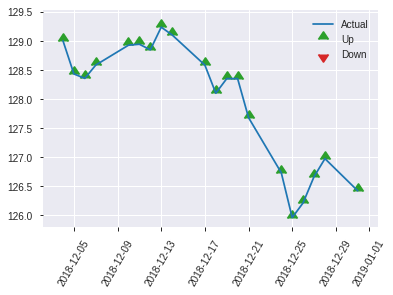


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2398350986147998
RMSE: 0.4897296178656135
LogLoss: 0.6752354305656585
Mean Per-Class Error: 0.3278543005815733
AUC: 0.6890725436179982
pr_auc: 0.6411714560557981
Gini: 0.3781450872359964
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5163701875702149: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      54   81   0.6      (81.0/135.0)
1      22   99   0.1818   (22.0/121.0)
Total  76   180  0.4023   (103.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.51637      0.657807  179
max f2                       0.377486     0.818554  248
max f0point5                 0.612958     0.684597  71
max accuracy                 0.612958     0.683594  71
max precision                0.614399     0.782609  68
max recall                   0.17696      1         255
max specificity              0.928787     0.992593  0
max absolute_mcc             0.612958     0.382306  71
max min_per_class_accuracy   0.564292     0.644628  124
max mean_per_class_accuracy  0.612958     0.672146  71

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 56.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.746819           1.41047   1.41047            0.666667         0.811666  0.666667                    0.811666            0.0165289       0.0165289                  41.0468   41.0468
    2        0.0234375                   0.736465           1.41047   1.41047            0.666667         0.739948  0.666667                    0.775807            0.0165289       0.0330579                  41.0468   41.0468
    3        0.03125                     0.733494           2.1157    1.58678            1                0.73449   0.75                        0.765478            0.0165289       0.0495868                  111.57    58.6777
    4        0.0429688                   0.726414           1.41047   1.53869            0.666667         0.731299  0.727273                    0.756156            0.0165289       0.0661157                  41.0468   53.8693
    5        0.0507812                   0.712693           0         1.30197            0                0.716824  0.615385                    0.750105            0               0.0661157                  -100      30.1971
    6        0.101562                    0.68508            1.46472   1.38334            0.692308         0.69848   0.653846                    0.724293            0.0743802       0.140496                   46.4717   38.3344
    7        0.152344                    0.659228           1.95296   1.57321            0.923077         0.67437   0.74359                     0.707652            0.0991736       0.239669                   95.2956   57.3215
    8        0.203125                    0.636919           1.46472   1.54609            0.692308         0.646471  0.730769                    0.692356            0.0743802       0.31405                    46.4717   54.609
    9        0.300781                    0.607474           1.69256   1.59365            0.8              0.618645  0.753247                    0.668424            0.165289        0.479339                   69.2562   59.3646
    10       0.402344                    0.586207           0.813732  1.39677            0.384615         0.596213  0.660194                    0.650196            0.0826446       0.561983                   -18.6268  39.6774
    11       0.5                         0.559333           0.930909  1.30579            0.44             0.573798  0.617188                    0.635275            0.0909091       0.652893                   -6.90909  30.5785
    12       0.601562                    0.540158           0.732359  1.20897            0.346154         0.548717  0.571429                    0.620661            0.0743802       0.727273                   -26.7641  20.8973
    13       0.699219                    0.516873           0.846281  1.15832            0.4              0.527411  0.547486                    0.607637            0.0826446       0.809917                   -15.3719  15.8318
    14       0.800781                    0.496029           0.650985  1.09397            0.307692         0.509644  0.517073                    0.595209            0.0661157       0.876033                   -34.9015  9.3973
    15       0.898438                    0.454684           0.677025  1.04865            0.32             0.474818  0.495652                    0.582123            0.0661157       0.942149                   -32.2975  4.86525
    16       1                           0.17696            0.569612  1                  0.269231         0.391863  0.472656                    0.5628             

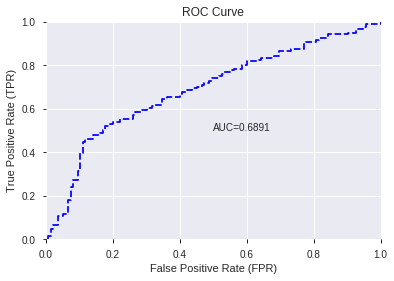

This function is available for GLM models only


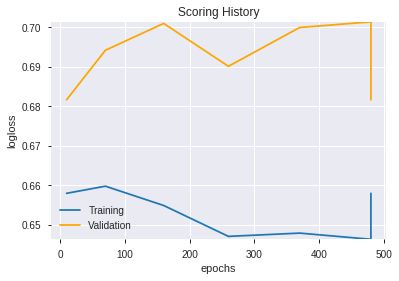

--2019-08-22 16:10:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_160457_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_160457_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_a7f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLENGULFING',
 'TRANGE',
 'BOP',
 'CDLTAKURI',
 'SUB',
 'CDLDRAGONFLYDOJI',
 'CDLBELTHOLD',
 'DIV',
 'CDLGRAVESTONEDOJI']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_161033_model_1  0.638567  0.66943              0.457698  0.488051  0.238194

variable  relative_importance  scaled_importance  percentage
0          CDLTAKURI             1.263407           1.000000    0.340159
1   CDLDRAGONFLYDOJI             1.077778           0.853073    0.290180
2                SUB             0.480662           0.380449    0.129413
3                BOP             0.345675           0.273605    0.093069
4  CDLGRAVESTONEDOJI             0.179554           0.142119    0.048343
5       CDLENGULFING             0.149330           0.118197    0.040206
6                DIV             0.101970           0.080711    0.027454
7             TRANGE             0.096537           0.076410    0.025992
8        CDLBELTHOLD             0.019255           0.015240    0.005184

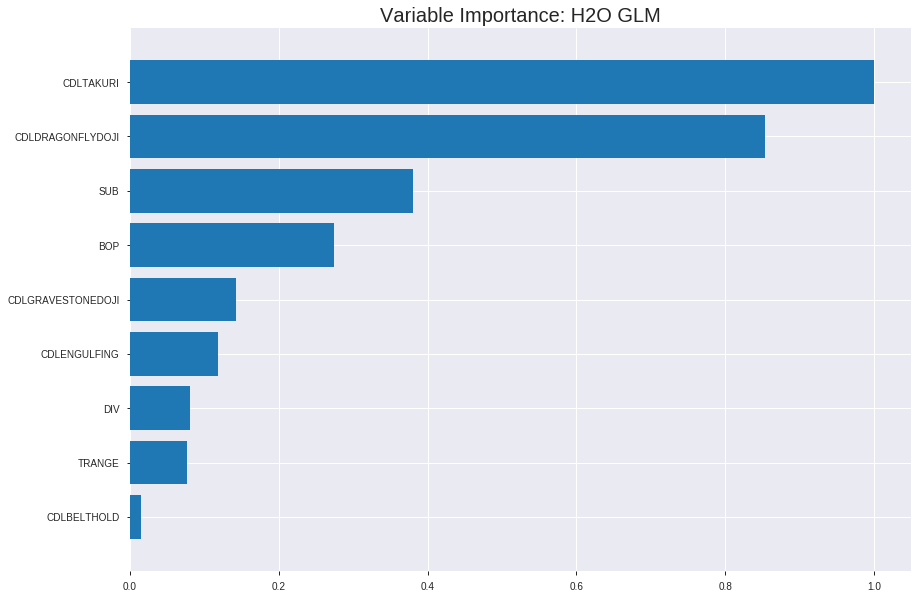

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_161033_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2334444714700279
RMSE: 0.4831609167451646
LogLoss: 0.6581452472565354
Null degrees of freedom: 1787
Residual degrees of freedom: 1778
Null deviance: 2476.257522519208
Residual deviance: 2353.527404189371
AIC: 2373.527404189371
AUC: 0.6435756821738351
pr_auc: 0.6026666999320409
Gini: 0.2871513643476702
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3862953387598989: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      255  672   0.7249   (672.0/927.0)
1      90   771   0.1045   (90.0/861.0)
Total  345  1443  0.4262   (762.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.386295     0.669271  277
max f2                       0.122242     0.826287  379
max f0point5                 0.510892     0.593821  170
max accuracy                 0.511486     0.611298  169
max precision                0.975588     1         0
max recall                   0.0586404    1         392
max specificity              0.975588     1         0
max absolute_mcc             0.417414     0.223801  253
max min_per_class_accuracy   0.497542     0.594657  182
max mean_per_class_accuracy  0.510892     0.608927  170

Gains/Lift Table: Avg response rate: 48.15 %, avg score: 48.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.790662           1.49981   1.49981            0.722222         0.836268  0.722222                    0.836268            0.0150987       0.0150987                  49.9806   49.9806
    2        0.0201342                   0.73849            1.49981   1.49981            0.722222         0.762568  0.722222                    0.799418            0.0150987       0.0301974                  49.9806   49.9806
    3        0.0302013                   0.699013           1.61518   1.53826            0.777778         0.720337  0.740741                    0.773058            0.0162602       0.0464576                  61.5176   53.8263
    4        0.0402685                   0.678395           1.38444   1.49981            0.666667         0.68554   0.722222                    0.751178            0.0139373       0.0603949                  38.4437   49.9806
    5        0.0503356                   0.662994           1.38444   1.47673            0.666667         0.669901  0.711111                    0.734923            0.0139373       0.0743322                  38.4437   47.6732
    6        0.100112                    0.635717           1.11999   1.29936            0.539326         0.649824  0.625698                    0.692611            0.0557491       0.130081                   11.9994   29.936
    7        0.150447                    0.607408           1.36136   1.3201             0.655556         0.621137  0.635688                    0.668698            0.068525        0.198606                   36.1363   32.0104
    8        0.200224                    0.565178           1.35333   1.32836            0.651685         0.583384  0.639665                    0.647488            0.0673635       0.26597                    35.3326   32.8363
    9        0.300336                    0.533362           1.20655   1.28776            0.581006         0.546813  0.620112                    0.61393             0.12079         0.38676                    20.6548   28.7758
    10       0.399888                    0.516365           1.23666   1.27504            0.595506         0.524808  0.613986                    0.591743            0.123113        0.509872                   23.666    27.5037
    11       0.5                         0.495124           0.89331   1.19861            0.430168         0.506351  0.577181                    0.574646            0.0894309       0.599303                   -10.669   19.8606
    12       0.600112                    0.468705           1.00932   1.16703            0.486034         0.483072  0.561976                    0.559369            0.101045        0.700348                   0.932396  16.703
    13       0.699664                    0.432564           0.968328  1.13876            0.466292         0.451469  0.548361                    0.544016            0.0963995       0.796748                   -3.16721  13.8757
    14       0.799776                    0.388528           0.928114  1.11239            0.446927         0.411354  0.535664                    0.52741             0.0929152       0.889663                   -7.1886   11.239
    15       0.899888                    0.331432           0.626477  1.05833            0.301676         0.363183  0.509633                    0.50914             0.0627178       0.952381                   -37.3523  5.83326
    16       1                           0.0132571          0.475658  1                  0.22905          0.233501  0.481544                    0.481545            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2404136695312023
RMSE: 0.4903199664822985
LogLoss: 0.6730863522801709
Null degrees of freedom: 510
Residual degrees of freedom: 501
Null deviance: 708.4284254426307
Residual deviance: 687.8942520303347
AIC: 707.8942520303347
AUC: 0.6049034630707938
pr_auc: 0.5717745026765927
Gini: 0.20980692614158758
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39381835126602466: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      41   219  0.8423   (219.0/260.0)
1      7    244  0.0279   (7.0/251.0)
Total  48   463  0.4423   (226.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.393818     0.683473  353
max f2                       0.376868     0.837838  365
max f0point5                 0.477398     0.586475  263
max accuracy                 0.495681     0.58317   231
max precision                0.689055     0.727273  10
max recall                   0.305496     1         392
max specificity              0.768863     0.996154  0
max absolute_mcc             0.393818     0.222433  353
max min_per_class_accuracy   0.512531     0.569231  189
max mean_per_class_accuracy  0.492767     0.585558  237

Gains/Lift Table: Avg response rate: 49.12 %, avg score: 50.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117417                   0.693319           1.01793   1.01793            0.5              0.711098  0.5                         0.711098            0.0119522       0.0119522                  1.79283    1.79283
    2        0.0215264                   0.68898            2.03586   1.48062            1                0.690458  0.727273                    0.701716            0.0199203       0.0318725                  103.586    48.0623
    3        0.0313112                   0.684406           1.22151   1.39965            0.6              0.686749  0.6875                      0.697039            0.0119522       0.0438247                  22.1514    39.9651
    4        0.0410959                   0.67668            1.62869   1.45418            0.8              0.680437  0.714286                    0.693086            0.0159363       0.059761                   62.8685    45.4183
    5        0.0508806                   0.669518           0.814343  1.33114            0.4              0.673579  0.653846                    0.689335            0.00796813      0.0677291                  -18.5657   33.1137
    6        0.101761                    0.640629           1.25283   1.29199            0.615385         0.651707  0.634615                    0.670521            0.063745        0.131474                   25.2835    29.1986
    7        0.150685                    0.605222           1.22151   1.26911            0.6              0.623263  0.623377                    0.655177            0.059761        0.191235                   22.1514    26.9105
    8        0.201566                    0.563815           1.09623   1.22547            0.538462         0.581771  0.601942                    0.636648            0.0557769       0.247012                   9.62305    22.5467
    9        0.30137                     0.539503           1.07781   1.17657            0.529412         0.550892  0.577922                    0.608248            0.10757         0.354582                   7.78064    17.6566
    10       0.401174                    0.524118           1.11773   1.16193            0.54902          0.532133  0.570732                    0.589312            0.111554        0.466135                   11.7725    16.1928
    11       0.500978                    0.512193           1.03789   1.13722            0.509804         0.518502  0.558594                    0.575206            0.103586        0.569721                   3.78877    13.7217
    12       0.600783                    0.497427           1.11773   1.13398            0.54902          0.503522  0.557003                    0.563297            0.111554        0.681275                   11.7725    13.3979
    13       0.700587                    0.475665           0.997969  1.1146             0.490196         0.48785   0.547486                    0.552549            0.0996016       0.780876                   -0.203109  11.4603
    14       0.800391                    0.440206           0.758456  1.07019            0.372549         0.459733  0.525672                    0.540975            0.0756972       0.856574                   -24.1544   7.01936
    15       0.900196                    0.395642           1.07781   1.07104            0.529412         0.414837  0.526087                    0.526991            0.10757         0.964143                   7.78064    7.10376
    16       1                           0.0304132          0.359269  1                  0.176471         0.341235  0.491194                    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 16:10:33  0.000 sec   2            .82E1     10            1.3782602183997634  1.381787080773374
     2019-08-22 16:10:33  0.004 sec   4            .51E1     10            1.3747792257379092  1.3794326156229413
     2019-08-22 16:10:33  0.009 sec   6            .32E1     10            1.3699254361443907  1.376189015104943
     2019-08-22 16:10:33  0.013 sec   8            .2E1      10            1.363598702360205   1.3720391855253273
     2019-08-22 16:10:33  0.017 sec   10           .12E1     10            1.356042737644186   1.3672159234410968
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 16:10:33  0.075 sec   37           .23E-3    10            1.3165042117947339  1.346227332492274
     2019-08-22 16:10:33  0.077 sec   38           .14E-3    10            1.3164231556127213  1.3462047707283635
     2019-08-22 16:10:33  0.082 sec   39           .89E-4    10            1.3163636674237433  1.346190215224024
     2019-08-22 16:10:33  0.085 sec   40           .55E-4    10            1.3163208343786774  1.346179331434399
     2019-08-22 16:10:33  0.088 sec   41           .34E-4    10            1.316290494513071   1.3461727045603418


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.640625)

('F1', 0.6535211267605635)

('auc', 0.6385674931129476)

('logloss', 0.6694297126150617)

('mean_per_class_error', 0.37086011631466176)

('rmse', 0.4880510987019998)

('mse', 0.23819387494422917)

glm prediction progress: |████████████████████████████████████████████████| 100%


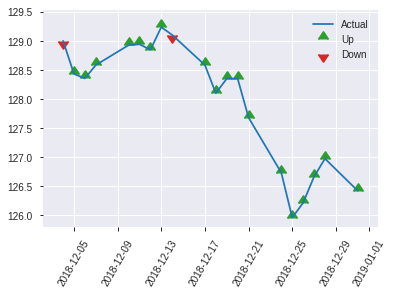


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.23819387494422917
RMSE: 0.4880510987019998
LogLoss: 0.6694297126150617
Null degrees of freedom: 255
Residual degrees of freedom: 246
Null deviance: 354.20638056124005
Residual deviance: 342.7480128589116
AIC: 362.7480128589116
AUC: 0.6385674931129476
pr_auc: 0.6020381517912252
Gini: 0.27713498622589516
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3970259379211893: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      17   118  0.8741   (118.0/135.0)
1      5    116  0.0413   (5.0/121.0)
Total  22   234  0.4805   (123.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.397026     0.653521  233
max f2                       0.358353     0.818554  248
max f0point5                 0.548409     0.616438  60
max accuracy                 0.557026     0.640625  54
max precision                0.596193     0.777778  44
max recall                   0.28644      1         255
max specificity              0.768252     0.992593  0
max absolute_mcc             0.557026     0.304879  54
max min_per_class_accuracy   0.516016     0.603306  124
max mean_per_class_accuracy  0.521188     0.62914   108

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 51.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.681581           0         0                  0                0.711943  0                           0.711943            0               0                          -100      -100
    2        0.0234375                   0.678466           2.1157    1.05785            1                0.679155  0.5                         0.695549            0.0247934       0.0247934                  111.57    5.78512
    3        0.03125                     0.671468           2.1157    1.32231            1                0.674978  0.625                       0.690406            0.0165289       0.0413223                  111.57    32.2314
    4        0.0429688                   0.664209           0.705234  1.15402            0.333333         0.668178  0.545455                    0.684344            0.00826446      0.0495868                  -29.4766  15.402
    5        0.0507812                   0.658204           2.1157    1.30197            1                0.660341  0.615385                    0.680651            0.0165289       0.0661157                  111.57    30.1971
    6        0.101562                    0.632608           1.79021   1.54609            0.846154         0.644505  0.730769                    0.662578            0.0909091       0.157025                   79.021    54.609
    7        0.152344                    0.604166           1.62746   1.57321            0.769231         0.617318  0.74359                     0.647491            0.0826446       0.239669                   62.7463   57.3215
    8        0.203125                    0.563122           1.62746   1.58678            0.769231         0.585593  0.75                        0.632017            0.0826446       0.322314                   62.7463   58.6777
    9        0.300781                    0.538172           0.930909  1.37383            0.44             0.546813  0.649351                    0.604353            0.0909091       0.413223                   -6.90909  37.3833
    10       0.402344                    0.524682           1.2206    1.33515            0.576923         0.530731  0.631068                    0.585769            0.123967        0.53719                    22.0598   33.5152
    11       0.5                         0.513495           0.677025  1.20661            0.32             0.518904  0.570312                    0.57271             0.0661157       0.603306                   -32.2975  20.6612
    12       0.601562                    0.497363           0.650985  1.1128             0.307692         0.504907  0.525974                    0.561262            0.0661157       0.669421                   -34.9015  11.2805
    13       0.699219                    0.476454           0.846281  1.07558            0.4              0.486758  0.50838                     0.550857            0.0826446       0.752066                   -15.3719  7.55806
    14       0.800781                    0.449502           0.895105  1.05269            0.423077         0.46318   0.497561                    0.539737            0.0909091       0.842975                   -10.4895  5.2691
    15       0.898438                    0.399992           0.846281  1.03026            0.4              0.427812  0.486957                    0.527571            0.0826446       0.92562                    -15.3719  3.02551
    16       1                           0.28644            0.732359  1                  0.346154         0.367584  0.472656                    0.511322            0.0

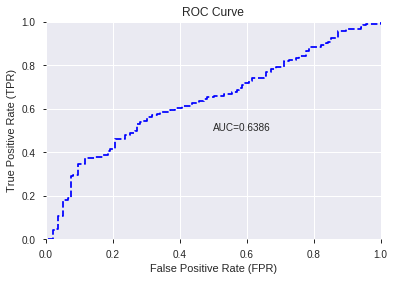

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


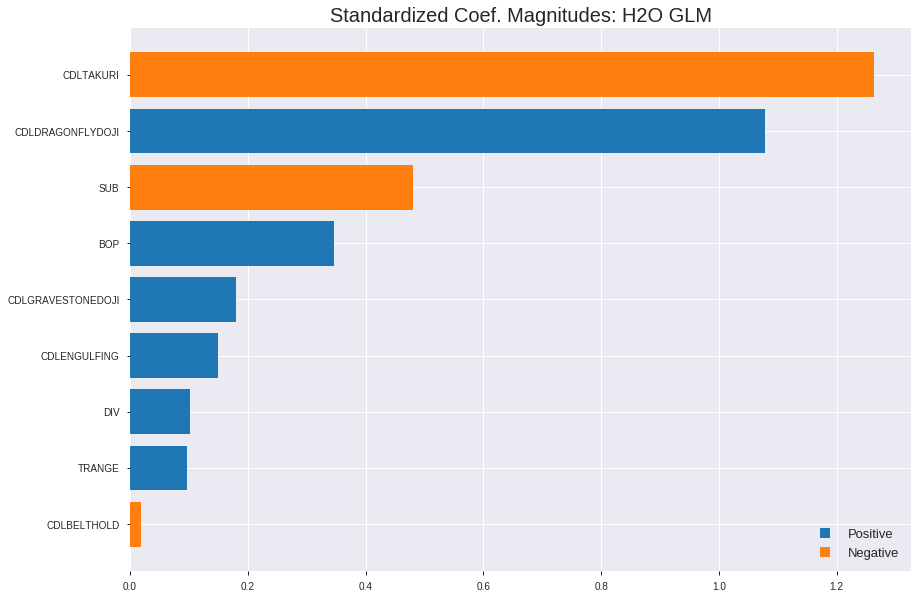

'log_likelihood'
--2019-08-22 16:10:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.100.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.100.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_161033_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_161033_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_a7f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'SUB',
 'BOP',
 'CDLGRAVESTONEDOJI',
 'CDLENGULFING',
 'DIV',
 'TRANGE',
 'CDLBELTHOLD']

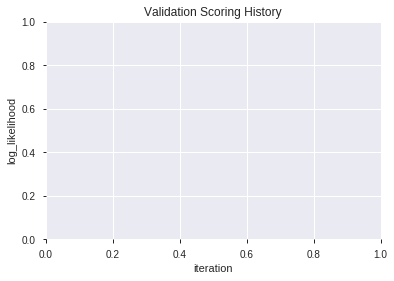

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_161050_model_4  0.664861  0.665236              0.368840  0.485924  0.236122
1  XGBoost_grid_1_AutoML_20190822_161050_model_2  0.634435  0.672654              0.481910  0.489672  0.239779
2               XGBoost_3_AutoML_20190822_161050  0.625681  0.675089              0.467952  0.490541  0.240630
3  XGBoost_grid_1_AutoML_20190822_161050_model_3  0.620753  0.678642              0.489317  0.492184  0.242245
4  XGBoost_grid_1_AutoML_20190822_161050_model_6  0.611019  0.680781              0.482339  0.493236  0.243282
5               XGBoost_2_AutoML_20190822_161050  0.604836  0.681084              0.489746  0.493656  0.243696
6               XGBoost_1_AutoML_20190822_161050  0.599939  0.684341              0.500000  0.494950  0.244976
7  XGBoost_grid_1_AutoML_20190822_161050_model_1  0.598929  0.682746              0.483196  0.494092  0.244127
8  XGBoost_grid_1_AutoML_20190822_161050_model_7  0.589654  0.688231              0.407009  0.496481  0.246494
9  XGBoost_grid_1_AutoML_20190822_161050_model_5  0.513560  0.749673              0.500000  0.523492  0.274044

variable  relative_importance  scaled_importance  percentage
0                BOP           577.996338           1.000000    0.274417
1                SUB           531.599304           0.919728    0.252389
2                DIV           372.045654           0.643682    0.176637
3             TRANGE           333.016083           0.576156    0.158107
4  CDLGRAVESTONEDOJI           138.066650           0.238871    0.065550
5          CDLTAKURI            85.408058           0.147766    0.040549
6   CDLDRAGONFLYDOJI            68.137741           0.117886    0.032350

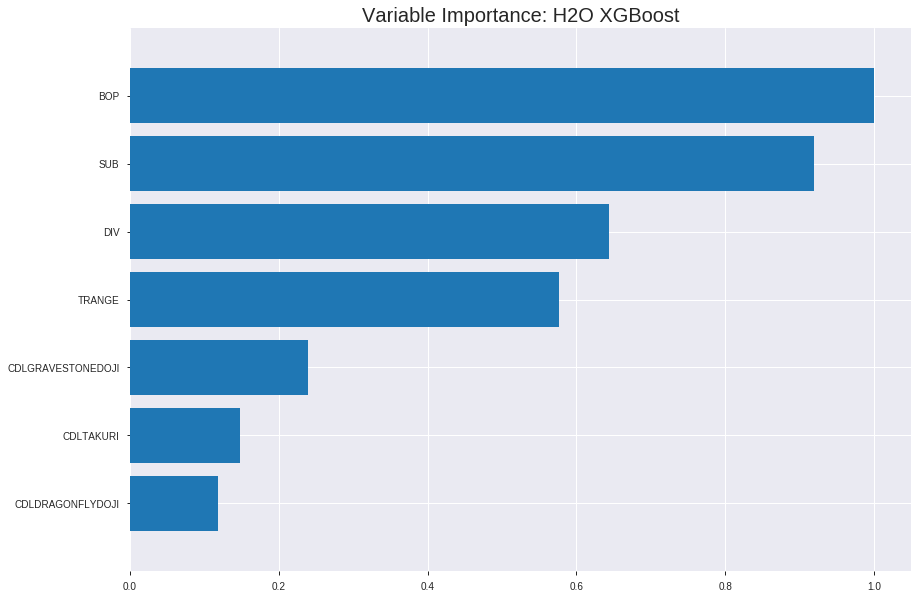

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_161050_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.22111512523957086
RMSE: 0.47022880094648695
LogLoss: 0.6331283350823624
Mean Per-Class Error: 0.3338783457182699
AUC: 0.7048382064957959
pr_auc: 0.6653611080513189
Gini: 0.40967641299159174
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40832616686820983: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      390  537   0.5793   (537.0/927.0)
1      118  743   0.137    (118.0/861.0)
Total  508  1280  0.3663   (655.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.408326     0.694068  264
max f2                       0.279133     0.83122   368
max f0point5                 0.490069     0.649602  189
max accuracy                 0.490069     0.66443   189
max precision                0.69056      1         0
max recall                   0.228826     1         394
max specificity              0.69056      1         0
max absolute_mcc             0.486662     0.333069  194
max min_per_class_accuracy   0.502232     0.650407  178
max mean_per_class_accuracy  0.486662     0.666122  194

Gains/Lift Table: Avg response rate: 48.15 %, avg score: 48.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0123043                   0.669244           1.98226   1.98226            0.954545         0.675129  0.954545                    0.675129            0.0243902       0.0243902                  98.2262   98.2262
    2        0.0206935                   0.663432           1.66132   1.85215            0.8              0.663999  0.891892                    0.670617            0.0139373       0.0383275                  66.1324   85.2152
    3        0.0302013                   0.65531            1.58803   1.769              0.764706         0.659284  0.851852                    0.667049            0.0150987       0.0534262                  58.803    76.9002
    4        0.0402685                   0.650423           1.26907   1.64402            0.611111         0.651966  0.791667                    0.663278            0.0127758       0.0662021                  26.9067   64.4019
    5        0.0503356                   0.646539           1.38444   1.5921             0.666667         0.648648  0.766667                    0.660352            0.0139373       0.0801394                  38.4437   59.2102
    6        0.100112                    0.625529           1.42333   1.50819            0.685393         0.635253  0.726257                    0.647873            0.0708479       0.150987                   42.3325   50.8185
    7        0.150447                    0.605989           1.49981   1.50538            0.722222         0.617134  0.724907                    0.637588            0.0754936       0.226481                   49.9806   50.5382
    8        0.200224                    0.592759           1.16666   1.42117            0.561798         0.59835   0.684358                    0.627834            0.058072        0.284553                   16.666    42.1175
    9        0.300336                    0.55839            1.28776   1.3767             0.620112         0.575841  0.662942                    0.610503            0.12892         0.413473                   28.7758   37.6702
    10       0.399888                    0.531838           1.22499   1.33893            0.589888         0.546387  0.644755                    0.594541            0.121951        0.535424                   22.4993   33.8934
    11       0.5                         0.500105           1.24135   1.3194             0.597765         0.515713  0.635347                    0.578758            0.124274        0.659698                   24.1352   31.9396
    12       0.600112                    0.457414           1.05573   1.27541            0.50838          0.481163  0.614166                    0.562477            0.105691        0.765389                   5.57297   27.5411
    13       0.699664                    0.419049           0.816662  1.21014            0.393258         0.43809   0.582734                    0.544778            0.0813008       0.84669                    -18.3338  21.0137
    14       0.799776                    0.365923           0.603274  1.13417            0.290503         0.390222  0.546154                    0.525432            0.0603949       0.907085                   -39.6726  13.4173
    15       0.899888                    0.317549           0.603274  1.07511            0.290503         0.342484  0.517713                    0.505079            0.0603949       0.96748                    -39.6726  7.5111
    16       1                           0.20719            0.32484   1                  0.156425         0.267028  0.481544                    0.481247          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.23664566181792743
RMSE: 0.48646239507070577
LogLoss: 0.6656146036486131
Mean Per-Class Error: 0.3965752375114925
AUC: 0.6230845847379711
pr_auc: 0.5847199194184892
Gini: 0.24616916947594225
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3777642846107483: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      56   204  0.7846   (204.0/260.0)
1      14   237  0.0558   (14.0/251.0)
Total  70   441  0.4266   (218.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.377764     0.684971  339
max f2                       0.281496     0.831126  394
max f0point5                 0.437372     0.601775  289
max accuracy                 0.499005     0.600783  224
max precision                0.672567     1         0
max recall                   0.281496     1         394
max specificity              0.672567     1         0
max absolute_mcc             0.437372     0.241885  289
max min_per_class_accuracy   0.523382     0.573705  185
max mean_per_class_accuracy  0.437372     0.603425  289

Gains/Lift Table: Avg response rate: 49.12 %, avg score: 50.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117417                   0.652992           1.35724   1.35724            0.666667         0.661017  0.666667                    0.661017            0.0159363       0.0159363                  35.7238    35.7238
    2        0.0215264                   0.645497           1.62869   1.48062            0.8              0.648557  0.727273                    0.655353            0.0159363       0.0318725                  62.8685    48.0623
    3        0.0313112                   0.64128            1.62869   1.52689            0.8              0.643569  0.75                        0.651671            0.0159363       0.0478088                  62.8685    52.6892
    4        0.0410959                   0.638075           1.22151   1.45418            0.6              0.639893  0.714286                    0.648866            0.0119522       0.059761                   22.1514    45.4183
    5        0.0508806                   0.631159           0.814343  1.33114            0.4              0.634259  0.653846                    0.646057            0.00796813      0.0677291                  -18.5657   33.1137
    6        0.101761                    0.617782           1.09623   1.21368            0.538462         0.623303  0.596154                    0.63468             0.0557769       0.123506                   9.62305    21.3684
    7        0.150685                    0.608515           1.22151   1.21623            0.6              0.612786  0.597403                    0.627572            0.059761        0.183267                   22.1514    21.6226
    8        0.201566                    0.594908           1.33114   1.24523            0.653846         0.601592  0.61165                     0.621014            0.0677291       0.250996                   33.1137    24.5233
    9        0.30137                     0.569547           1.11773   1.20301            0.54902          0.580337  0.590909                    0.607543            0.111554        0.36255                    11.7725    20.3006
    10       0.401174                    0.550151           1.11773   1.18179            0.54902          0.559957  0.580488                    0.595705            0.111554        0.474104                   11.7725    18.179
    11       0.500978                    0.522619           1.03789   1.15312            0.509804         0.536376  0.566406                    0.583885            0.103586        0.577689                   3.78877    15.3122
    12       0.600783                    0.500366           1.23748   1.16714            0.607843         0.509852  0.57329                     0.571587            0.123506        0.701195                   23.7481    16.7136
    13       0.700587                    0.462684           0.997969  1.14304            0.490196         0.483773  0.561453                    0.559077            0.0996016       0.800797                   -0.203109  14.3037
    14       0.800391                    0.411395           0.838294  1.10504            0.411765         0.438956  0.542787                    0.544098            0.0836653       0.884462                   -16.1706   10.5037
    15       0.900196                    0.362583           0.758456  1.06661            0.372549         0.385936  0.523913                    0.526563            0.0756972       0.960159                   -24.1544   6.66118
    16       1                           0.217325           0.399188  1                  0.196078         0.321339  0.491194                    0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:10:56  2.386 sec   0                  0.5              0.693147            0.5             0                  1                0.518456                         0.5                0.693147              0.5               0                    1                  0.508806
    2019-08-22 16:10:56  2.446 sec   5                  0.492843         0.678905            0.669311        0.594135           1.77381          0.381991                         0.496686           0.686535              0.608834          0.573458             1.58344            0.422701
    2019-08-22 16:10:57  2.604 sec   10                 0.48776          0.668811            0.675829        0.60373            1.77275          0.374161                         0.494224           0.681611              0.606934          0.568129             1.01793            0.41683
    2019-08-22 16:10:57  2.651 sec   15                 0.483587         0.660468            0.681319        0.610421           1.78823          0.375839                         0.49208            0.677294              0.614488          0.58619              2.03586            0.420744
    2019-08-22 16:10:57  2.701 sec   20                 0.480513         0.654283            0.686856        0.648695           1.84592          0.366331                         0.490767           0.674627              0.616273          0.590421             2.03586            0.420744
    2019-08-22 16:10:57  2.754 sec   25                 0.47796          0.649134            0.691499        0.651857           1.96129          0.376398                         0.489499           0.672027              0.619146          0.589657             1.69655            0.424658
    2019-08-22 16:10:57  2.810 sec   30                 0.475669         0.644438            0.693377        0.654362           1.84592          0.36689                          0.48837            0.669682              0.620686          0.592059             1.69655            0.418787
    2019-08-22 16:10:57  2.874 sec   35                 0.474272         0.641484            0.694614        0.655345           1.83704          0.361298                         0.487973           0.668809              0.62074           0.587106             1.69655            0.424658
    2019-08-22 16:10:57  2.929 sec   40                 0.472666         0.638196            0.69909         0.660873           2.07666          0.371365                         0.487748           0.668297              0.619101          0.586658             2.03586            0.418787
    2019-08-22 16:10:57  2.996 sec   45                 0.471193         0.635142            0.702046        0.664331           2.07666          0.364094                         0.486888           0.666526              0.622617          0.588383             2.03586            0.422701
    2019-08-22 16:10:57  3.060 sec   50                 0.470229         0.633128            0.704838        0.665361           1.98226          0.366331                         0.486462           0.665615              0.623085          0.58472              1.35724            0.426614

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
BOP                577.996                1                    0.274417
SUB                531.599                0.919728             0.252389
DIV                372.046                0.643682             0.176637
TRANGE             333.016                0.576156             0.158107
CDLGRAVESTONEDOJI  138.067                0.238871             0.0655503
CDLTAKURI          85.4081                0.147766             0.0405494
CDLDRAGONFLYDOJI   68.1377                0.117886             0.03235

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6484375)

('F1', 0.6521739130434783)

('auc', 0.6648607284970922)

('logloss', 0.6652356424465324)

('mean_per_class_error', 0.35647382920110193)

('rmse', 0.48592356913287765)

('mse', 0.2361217150388345)

xgboost prediction progress: |████████████████████████████████████████████| 100%


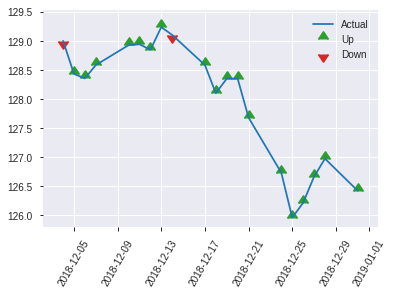


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2361217150388345
RMSE: 0.48592356913287765
LogLoss: 0.6652356424465324
Mean Per-Class Error: 0.35647382920110193
AUC: 0.6648607284970922
pr_auc: 0.6592708397593259
Gini: 0.3297214569941844
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5013806223869324: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      70   65   0.4815   (65.0/135.0)
1      31   90   0.2562   (31.0/121.0)
Total  101  155  0.375    (96.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.501381     0.652174  148
max f2                       0.216537     0.817568  248
max f0point5                 0.543824     0.628518  98
max accuracy                 0.543824     0.648438  98
max precision                0.670323     1         0
max recall                   0.216537     1         248
max specificity              0.670323     1         0
max absolute_mcc             0.602508     0.311863  29
max min_per_class_accuracy   0.520591     0.628099  121
max mean_per_class_accuracy  0.543824     0.643526  98

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 50.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.653285           2.1157    2.1157             1                0.667141  1                           0.667141            0.0247934       0.0247934                  111.57    111.57
    2        0.0234375                   0.637299           1.41047   1.76309            0.666667         0.641517  0.833333                    0.654329            0.0165289       0.0413223                  41.0468   76.3085
    3        0.03125                     0.624568           2.1157    1.85124            1                0.629714  0.875                       0.648175            0.0165289       0.0578512                  111.57    85.124
    4        0.0429688                   0.620753           2.1157    1.92337            1                0.621595  0.909091                    0.640926            0.0247934       0.0826446                  111.57    92.3366
    5        0.0507812                   0.618164           2.1157    1.95296            1                0.619162  0.923077                    0.637578            0.0165289       0.0991736                  111.57    95.2956
    6        0.101562                    0.607065           1.79021   1.87158            0.846154         0.611831  0.884615                    0.624704            0.0909091       0.190083                   79.021    87.1583
    7        0.152344                    0.593858           0.976478  1.57321            0.461538         0.599725  0.74359                     0.616378            0.0495868       0.239669                   -2.35219  57.3215
    8        0.203125                    0.585278           1.30197   1.5054             0.615385         0.589599  0.711538                    0.609683            0.0661157       0.305785                   30.1971   50.5404
    9        0.300781                    0.567245           1.10017   1.37383            0.52             0.575177  0.649351                    0.59848             0.107438        0.413223                   10.0165   37.3833
    10       0.402344                    0.543824           1.38334   1.37623            0.653846         0.554108  0.650485                    0.587279            0.140496        0.553719                   38.3344   37.6234
    11       0.5                         0.519768           0.846281  1.27273            0.4              0.532189  0.601562                    0.576519            0.0826446       0.636364                   -15.3719  27.2727
    12       0.601562                    0.504423           0.976478  1.22271            0.461538         0.511449  0.577922                    0.565533            0.0991736       0.735537                   -2.35219  22.2711
    13       0.699219                    0.471827           0.42314   1.11104            0.2              0.487306  0.52514                     0.554608            0.0413223       0.77686                    -57.686   11.1039
    14       0.800781                    0.418612           0.650985  1.05269            0.307692         0.440398  0.497561                    0.540123            0.0661157       0.842975                   -34.9015  5.2691
    15       0.898438                    0.367303           0.846281  1.03026            0.4              0.393811  0.486957                    0.524219            0.0826446       0.92562                    -15.3719  3.02551
    16       1                           0.216537           0.732359  1                  0.346154         0.332854  0.472656                    0.504784            

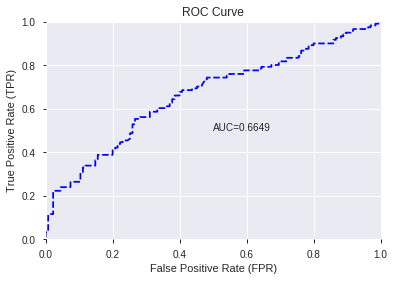

This function is available for GLM models only


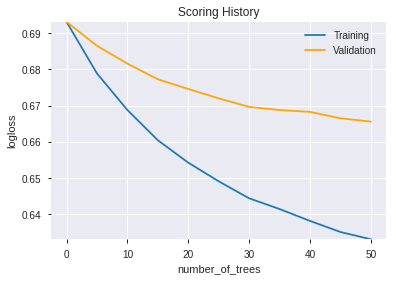

--2019-08-22 16:11:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.85.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.85.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_161050_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_161050_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_a7f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'SUB',
 'DIV',
 'TRANGE',
 'CDLGRAVESTONEDOJI',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

184

['BBANDS_lowerband_12_7_4',
 'BBANDS_upperband_12_7_5',
 'BBANDS_lowerband_12_7_5',
 'DEMA_14',
 'EMA_14',
 'KAMA_14',
 'SAR_0.14',
 'TRIMA_14',
 'BBANDS_upperband_14_0_2',
 'BBANDS_upperband_14_0_3',
 'BBANDS_upperband_14_0_4',
 'BBANDS_lowerband_14_0_5',
 'BBANDS_lowerband_14_1_2',
 'MA_14_2',
 'BBANDS_upperband_14_2_3',
 'BBANDS_middleband_14_2_4',
 'BBANDS_upperband_14_2_5',
 'BBANDS_middleband_14_2_5',
 'MA_14_3',
 'MAVP_14_3',
 'BBANDS_upperband_14_3_2',
 'BBANDS_upperband_14_3_4',
 'BBANDS_upperband_14_4_3',
 'BBANDS_upperband_14_4_4',
 'BBANDS_lowerband_14_4_5',
 'BBANDS_upperband_14_5_4',
 'BBANDS_upperband_14_5_5',
 'BBANDS_upperband_14_6_3',
 'BBANDS_upperband_14_6_4',
 'BBANDS_upperband_14_7_2',
 'BBANDS_middleband_14_7_4',
 'BBANDS_lowerband_14_7_4',
 'MA_20_0',
 'MAVP_20_0',
 'BBANDS_middleband_20_0_3',
 'BBANDS_upperband_20_0_4',
 'BBANDS_lowerband_20_1_2',
 'BBANDS_middleband_20_2_2',
 'BBANDS_upperband_20_2_3',
 'MAVP_20_3',
 'BBANDS_upperband_20_3_4',
 'BBANDS_lowerba

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_161238_model_6  0.719192  0.668126              0.338353  0.487527  0.237682
1               DeepLearning_1_AutoML_20190822_161238  0.701500  0.701480              0.415825  0.503899  0.253915
2  DeepLearning_grid_1_AutoML_20190822_161238_model_3  0.682583  0.641955              0.378359  0.475904  0.226485
3  DeepLearning_grid_1_AutoML_20190822_161238_model_9  0.682461  0.669372              0.457698  0.487860  0.238008
4  DeepLearning_grid_1_AutoML_20190822_161238_model_7  0.663606  0.839592              0.423661  0.550680  0.303248
5  DeepLearning_grid_1_AutoML_20190822_161238_model_5  0.639180  0.688018              0.399449  0.497513  0.247520
6  DeepLearning_grid_1_AutoML_20190822_161238_model_4  0.619467  1.040766              0.476217  0.574287  0.329806
7  DeepLearning_grid_1_AutoML_20190822_161238_model_8  0.583349  0.688921              0.418672  0.497915  0.247920
8  DeepLearning_grid_1_AutoML_20190822_161238_model_1  0.567616  1.121357              0.459412  0.586004  0.343401
9  DeepLearning_grid_1_AutoML_20190822_161238_model_2  0.560514  0.735569              0.455280  0.512040  0.262185

variable  relative_importance  scaled_importance  percentage
0                       BOP             1.000000           1.000000    0.007713
1                    TRANGE             0.899311           0.899311    0.006936
2              HT_TRENDMODE             0.837497           0.837497    0.006460
3         CDLGRAVESTONEDOJI             0.831178           0.831178    0.006411
4            CDLRICKSHAWMAN             0.818235           0.818235    0.006311
..                      ...                  ...                ...         ...
179              MACDFIX_20             0.653230           0.653230    0.005038
180  LINEARREG_INTERCEPT_20             0.645603           0.645603    0.004979
181              CDLHIKKAKE             0.645167           0.645167    0.004976
182      LINEARREG_ANGLE_14             0.635406           0.635406    0.004901
183      LINEARREG_SLOPE_12             0.627838           0.627838    0.004842

[184 rows x 4 columns]

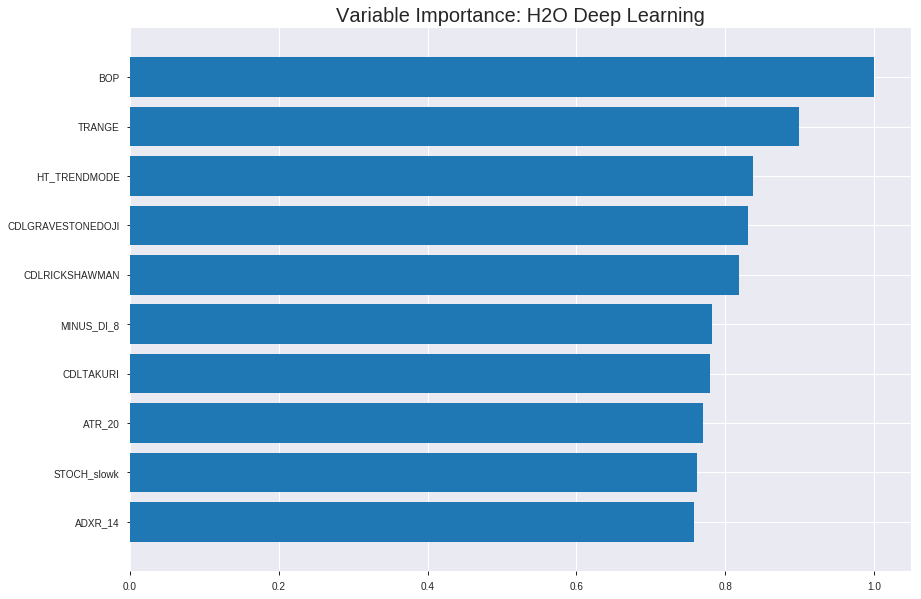

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_161238_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23859023059011314
RMSE: 0.48845698949867955
LogLoss: 0.6695948907174396
Mean Per-Class Error: 0.38394619036342936
AUC: 0.6580955638497671
pr_auc: 0.6271400550415053
Gini: 0.31619112769953417
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49511612278872225: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      277  650   0.7012   (650.0/927.0)
1      94   767   0.1092   (94.0/861.0)
Total  371  1417  0.4161   (744.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.495116     0.673398  261
max f2                       0.351273     0.825644  372
max f0point5                 0.533401     0.601883  185
max accuracy                 0.533401     0.615772  185
max precision                0.802884     1         0
max recall                   0.295641     1         384
max specificity              0.802884     1         0
max absolute_mcc             0.516505     0.242569  221
max min_per_class_accuracy   0.534088     0.61165   184
max mean_per_class_accuracy  0.533401     0.616054  185

Gains/Lift Table: Avg response rate: 48.15 %, avg score: 52.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100671                   0.673814           1.96129   1.96129            0.944444         0.712365  0.944444                    0.712365            0.0197445       0.0197445                  96.1285    96.1285
    2        0.0201342                   0.648135           1.49981   1.73055            0.722222         0.662022  0.833333                    0.687194            0.0150987       0.0348432                  49.9806    73.0546
    3        0.0302013                   0.63021            1.73055   1.73055            0.833333         0.638858  0.833333                    0.671082            0.0174216       0.0522648                  73.0546    73.0546
    4        0.0402685                   0.618836           1.49981   1.67286            0.722222         0.624293  0.805556                    0.659385            0.0150987       0.0673635                  49.9806    67.2861
    5        0.0503356                   0.610285           0.922958  1.52288            0.444444         0.614504  0.733333                    0.650409            0.00929152      0.0766551                  -7.70422   52.288
    6        0.100112                    0.58831            1.46999   1.49658            0.707865         0.596926  0.72067                     0.623817            0.0731707       0.149826                   46.9992    49.6584
    7        0.150447                    0.577886           1.1537    1.38186            0.555556         0.582359  0.665428                    0.609946            0.058072        0.207898                   15.3697    38.1863
    8        0.200224                    0.569469           1.18999   1.33416            0.573034         0.573959  0.642458                    0.600999            0.0592334       0.267131                   18.9993    33.4164
    9        0.300336                    0.555374           1.27616   1.31483            0.614525         0.561956  0.633147                    0.587985            0.127758        0.39489                    27.6157    31.4828
    10       0.399888                    0.5444             1.18999   1.28375            0.573034         0.549828  0.618182                    0.578486            0.118467        0.513357                   18.9993    28.375
    11       0.5                         0.533469           1.04413   1.23577            0.502793         0.538794  0.595078                    0.570539            0.10453         0.617886                   4.41282    23.5772
    12       0.600112                    0.522808           0.928114  1.18445            0.446927         0.527832  0.570363                    0.563414            0.0929152       0.710801                   -7.1886    18.4448
    13       0.699664                    0.511497           0.991661  1.15702            0.477528         0.517055  0.557154                    0.556818            0.0987224       0.809524                   -0.833888  15.7017
    14       0.799776                    0.492908           0.858505  1.11965            0.413408         0.503292  0.539161                    0.550118            0.0859466       0.89547                    -14.1495   11.9651
    15       0.899888                    0.465105           0.591673  1.06091            0.284916         0.481035  0.510876                    0.542432            0.0592334       0.954704                   -40.8327   6.09139
    16       1                           0.116801           0.452456  1                  0.217877         0.40116   0.481544                    0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24689173092994637
RMSE: 0.4968820090624598
LogLoss: 0.6865446468920964
Mean Per-Class Error: 0.434638369598529
AUC: 0.5751149249157217
pr_auc: 0.5459979335549493
Gini: 0.15022984983144338
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4353256082133568: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      14   246  0.9462   (246.0/260.0)
1      3    248  0.012    (3.0/251.0)
Total  17   494  0.4873   (249.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.435326     0.665772  382
max f2                       0.398047     0.831677  393
max f0point5                 0.526        0.566102  234
max accuracy                 0.557436     0.565558  122
max precision                0.657743     1         0
max recall                   0.398047     1         393
max specificity              0.657743     1         0
max absolute_mcc             0.557436     0.137418  122
max min_per_class_accuracy   0.533428     0.546154  202
max mean_per_class_accuracy  0.526        0.565362  234

Gains/Lift Table: Avg response rate: 49.12 %, avg score: 53.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.623828           1.01793   1.01793            0.5              0.641818  0.5                         0.641818            0.0119522       0.0119522                  1.79283   1.79283
    2        0.0215264                   0.611776           1.62869   1.29555            0.8              0.617046  0.636364                    0.630558            0.0159363       0.0278884                  62.8685   29.5545
    3        0.0313112                   0.608013           1.22151   1.27241            0.6              0.609382  0.625                       0.62394             0.0119522       0.0398406                  22.1514   27.241
    4        0.0410959                   0.603895           1.22151   1.26029            0.6              0.60557   0.619048                    0.619567            0.0119522       0.0517928                  22.1514   26.0292
    5        0.0508806                   0.597678           0.407171  1.09623            0.2              0.599593  0.538462                    0.615725            0.00398406      0.0557769                  -59.2829  9.62305
    6        0.101761                    0.584726           1.09623   1.09623            0.538462         0.590257  0.538462                    0.602991            0.0557769       0.111554                   9.62305   9.62305
    7        0.150685                    0.574886           1.22151   1.13691            0.6              0.578854  0.558442                    0.595154            0.059761        0.171315                   22.1514   13.6907
    8        0.201566                    0.567189           1.33114   1.18594            0.653846         0.572038  0.582524                    0.589319            0.0677291       0.239044                   33.1137   18.5936
    9        0.30137                     0.553631           1.15764   1.17657            0.568627         0.560438  0.577922                    0.579755            0.115538        0.354582                   15.7644   17.6566
    10       0.401174                    0.542402           1.07781   1.152              0.529412         0.547649  0.565854                    0.571767            0.10757         0.462151                   7.78064   15.1997
    11       0.500978                    0.53346            0.878213  1.09745            0.431373         0.537444  0.539062                    0.564929            0.0876494       0.549801                   -12.1787  9.74539
    12       0.600783                    0.525834           1.15764   1.10745            0.568627         0.529291  0.543974                    0.559009            0.115538        0.665339                   15.7644   10.7453
    13       0.700587                    0.516948           0.838294  1.06911            0.411765         0.52165   0.52514                     0.553687            0.0836653       0.749004                   -16.1706  6.9109
    14       0.800391                    0.505214           0.758456  1.03037            0.372549         0.511596  0.506112                    0.548438            0.0756972       0.824701                   -24.1544  3.03724
    15       0.900196                    0.483776           0.95805   1.02235            0.470588         0.494688  0.502174                    0.542479            0.0956175       0.920319                   -4.19498  2.23541
    16       1                           0.138481           0.798375  1                  0.392157         0.431649  0.491194                    0.531418           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:18:08  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 16:18:10  2 min 49.556 sec  773 obs/sec       0.902125  1             1613       0.536863         0.83035             -0.154461      0.587976        0.564069           1.49981          0.490492                         0.560459           0.908975              -0.256847        0.528838          0.492168             0.678619           0.495108
    2019-08-22 16:18:19  2 min 58.410 sec  1290 obs/sec      7.31879   8             13086      0.488457         0.669595            0.0443369      0.658096        0.62714            1.96129          0.416107                         0.496882           0.686545              0.0121266        0.575115          0.545998             1.01793            0.48728
    2019-08-22 16:18:27  3 min  6.930 sec  1558 obs/sec      15.571    17            27841      0.489829         0.670656            0.0389594      0.659221        0.63167            2.07666          0.439038                         0.50717            0.708236              -0.0292047       0.571966          0.526004             1.01793            0.483366
    2019-08-22 16:18:36  3 min 15.162 sec  1686 obs/sec      23.8484   26            42641      0.477575         0.644176            0.0864454      0.68442         0.650296           2.07666          0.427293                         0.498471           0.689672              0.00579656       0.584623          0.568489             1.35724            0.46184
    2019-08-22 16:18:44  3 min 24.005 sec  1771 obs/sec      33.0056   36            59014      0.474657         0.637875            0.0975729      0.70011         0.670441           2.07666          0.399888                         0.498208           0.690029              0.00684609       0.587082          0.556383             1.35724            0.430528
    2019-08-22 16:18:53  3 min 32.283 sec  1808 obs/sec      41.2757   45            73801      0.466873         0.621012            0.126928       0.731247        0.704956           2.07666          0.379754                         0.498585           0.695933              0.00534275       0.592063          0.55802              1.69655            0.479452
    2019-08-22 16:19:01  3 min 40.878 sec  1856 obs/sec      50.4547   55            90213      0.457943         0.602617            0.160008       0.744412        0.727803           2.07666          0.364094                         0.495546           0.687431              0.0174329        0.606742          0.562874             1.01793            0.395303
    2019-08-22 16:19:02  3 min 41.712 sec  1855 obs/sec      50.4547   55            90213      0.488457         0.669595            0.0443369      0.658096        0.62714            1.96129          0.416107                         0.496882           0.686545              0.0121266        0.575115          0.545998             1.01793            0.48728

Variable Importances: 


variable                relative_importance    scaled_importance    percentage
----------------------  ---------------------  -------------------  ---------------------
BOP                     1.0                    1.0                  0.007712901944403707
TRANGE                  0.899310827255249      0.899310827255249    0.006936296228160316
HT_TRENDMODE            0.8374968767166138     0.8374968767166138   0.006459531288859602
CDLGRAVESTONEDOJI       0.8311780691146851     0.8311780691146851   0.006410794945420373
CDLRICKSHAWMAN          0.8182348608970642     0.8182348608970642   0.006310965249591863
---                     ---                    ---                  ---
MACDFIX_20              0.6532297134399414     0.6532297134399414   0.0050382967269332005
LINEARREG_INTERCEPT_20  0.6456027626991272     0.6456027626991272   0.004979470803734503
CDLHIKKAKE              0.645167350769043      0.645167350769043    0.00497611251421234
LINEARREG_ANGLE_14      0.6354061961174011     0.6354061961174011   0.004900825685520066
LINEARREG_SLOPE_12      0.6278384923934937     0.6278384923934937   0.004842456728753269


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6953125)

('F1', 0.676470588235294)

('auc', 0.7191919191919192)

('logloss', 0.6681259511566687)

('mean_per_class_error', 0.3107438016528925)

('rmse', 0.48752672625051685)

('mse', 0.2376823088085464)

deeplearning prediction progress: |███████████████████████████████████████| 100%


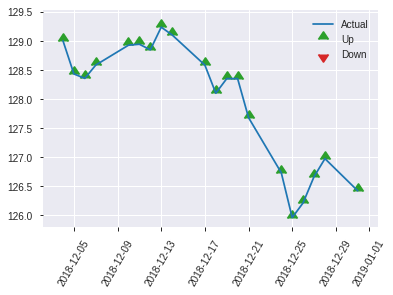


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2376823088085464
RMSE: 0.48752672625051685
LogLoss: 0.6681259511566687
Mean Per-Class Error: 0.3107438016528925
AUC: 0.7191919191919192
pr_auc: 0.7178292182337548
Gini: 0.4383838383838383
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5195023224853572: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      76   59   0.437    (59.0/135.0)
1      29   92   0.2397   (29.0/121.0)
Total  105  151  0.3438   (88.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.519502     0.676471  150
max f2                       0.43663      0.824251  249
max f0point5                 0.545528     0.694143  84
max accuracy                 0.545528     0.695312  84
max precision                0.672512     1         0
max recall                   0.43663      1         249
max specificity              0.672512     1         0
max absolute_mcc             0.545528     0.395814  84
max min_per_class_accuracy   0.528268     0.652893  124
max mean_per_class_accuracy  0.540412     0.689256  96

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 52.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.644117           2.1157    2.1157             1                0.664651  1                           0.664651            0.0247934       0.0247934                  111.57    111.57
    2        0.0234375                   0.629217           2.1157    2.1157             1                0.633922  1                           0.649287            0.0247934       0.0495868                  111.57    111.57
    3        0.03125                     0.623183           2.1157    2.1157             1                0.623599  1                           0.642865            0.0165289       0.0661157                  111.57    111.57
    4        0.0429688                   0.612575           1.41047   1.92337            0.666667         0.617752  0.909091                    0.636016            0.0165289       0.0826446                  41.0468   92.3366
    5        0.0507812                   0.606032           2.1157    1.95296            1                0.606644  0.923077                    0.631497            0.0165289       0.0991736                  111.57    95.2956
    6        0.101562                    0.582936           1.62746   1.79021            0.769231         0.591571  0.846154                    0.611534            0.0826446       0.181818                   62.7463   79.021
    7        0.152344                    0.573224           1.79021   1.79021            0.846154         0.578011  0.846154                    0.60036             0.0909091       0.272727                   79.021    79.021
    8        0.203125                    0.564761           1.30197   1.66815            0.615385         0.568763  0.788462                    0.59246             0.0661157       0.338843                   30.1971   66.815
    9        0.300781                    0.549121           1.43868   1.59365            0.68             0.556281  0.753247                    0.580714            0.140496        0.479339                   43.8678   59.3646
    10       0.402344                    0.537149           1.13922   1.47894            0.538462         0.543149  0.699029                    0.571232            0.115702        0.595041                   13.9224   47.8938
    11       0.5                         0.526803           0.677025  1.32231            0.32             0.531715  0.625                       0.563514            0.0661157       0.661157                   -32.2975  32.2314
    12       0.601562                    0.518838           0.976478  1.26393            0.461538         0.522575  0.597403                    0.556602            0.0991736       0.760331                   -2.35219  26.3926
    13       0.699219                    0.510355           0.507769  1.15832            0.24             0.515192  0.547486                    0.550818            0.0495868       0.809917                   -49.2231  15.8318
    14       0.800781                    0.49531            0.732359  1.10429            0.346154         0.505082  0.521951                    0.545018            0.0743802       0.884298                   -26.7641  10.4293
    15       0.898438                    0.473467           0.507769  1.03945            0.24             0.48658   0.491304                    0.538666            0.0495868       0.933884                   -49.2231  3.94538
    16       1                           0.380448           0.650985  1                  0.307692         0.448462  0.472656                    0.529504            0.0

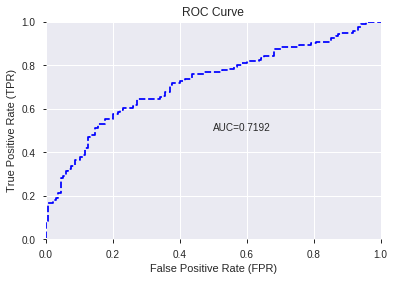

This function is available for GLM models only


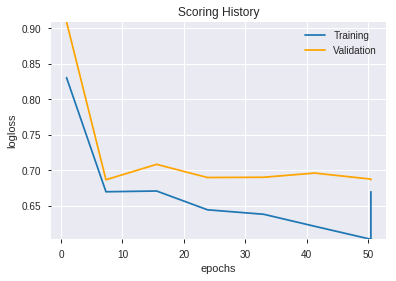

--2019-08-22 16:23:57--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.86.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.86.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_161238_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_161238_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_a7f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'TRANGE',
 'HT_TRENDMODE',
 'CDLGRAVESTONEDOJI',
 'CDLRICKSHAWMAN',
 'MINUS_DI_8',
 'CDLTAKURI',
 'ATR_20',
 'STOCH_slowk',
 'ADXR_14',
 'WILLR_8',
 'RSI_24',
 'MINUS_DM_24',
 'MINUS_DI_20',
 'MACDFIX_signal_12',
 'CMO_12',
 'ADX_8',
 'CDLLONGLEGGEDDOJI',
 'PLUS_DI_14',
 'ULTOSC',
 'MINUS_DI_30',
 'aroondown_12',
 'BETA_20',
 'BBANDS_upperband_20_2_3',
 'ROCP_12',
 'BBANDS_upperband_30_2_5',
 'STOCHRSI_fastd',
 'CCI_30',
 'aroonup_12',
 'BBANDS_middleband_20_2_2',
 'CORREL_8',
 'BBANDS_lowerband_14_4_5',
 'BBANDS_upperband_14_4_4',
 'NATR_8',
 'CDLLONGLINE',
 'WILLR_20',
 'BBANDS_upperband_30_0_4',
 'STDDEV_14',
 'CCI_14',
 'SAR_0.14',
 'MA_14_3',
 'LINEARREG_INTERCEPT_8',
 'ROCR_24',
 'BBANDS_upperband_14_6_4',
 'BBANDS_upperband_14_5_5',
 'ATR_12',
 'BETA_8',
 'MACDFIX_hist_24',
 'CORREL_12',
 'LINEARREG_ANGLE_8',
 'WILLR_14',
 'VAR_14',
 'EMA_14',
 'STDDEV_20',
 'PLUS_DM_30',
 'DX_20',
 'VAR_12',
 'ROCR_14',
 'PLUS_DM_12',
 'CMO_24',
 'HT_PHASOR_inphase',
 'LINEARREG_SLOPE_

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_162406_model_1  0.680196  0.654657              0.450291  0.480695  0.231068

variable  relative_importance  scaled_importance    percentage
0                        BOP             0.174457           1.000000  7.210567e-02
1                     TRANGE             0.118371           0.678509  4.892434e-02
2          CDLGRAVESTONEDOJI             0.100639           0.576869  4.159554e-02
3                 MINUS_DI_8             0.075831           0.434668  3.134202e-02
4             CDLRICKSHAWMAN             0.068712           0.393860  2.839951e-02
..                       ...                  ...                ...           ...
179                 AVGPRICE             0.000207           0.001189  8.575024e-05
180  BBANDS_upperband_14_3_2             0.000205           0.001174  8.464059e-05
181                   ROCR_8             0.000187           0.001071  7.721170e-05
182  BBANDS_upperband_20_3_4             0.000066           0.000377  2.719398e-05
183                    ROC_8             0.000002           0.000014  9.962158e-07

[184 rows x 4 columns]

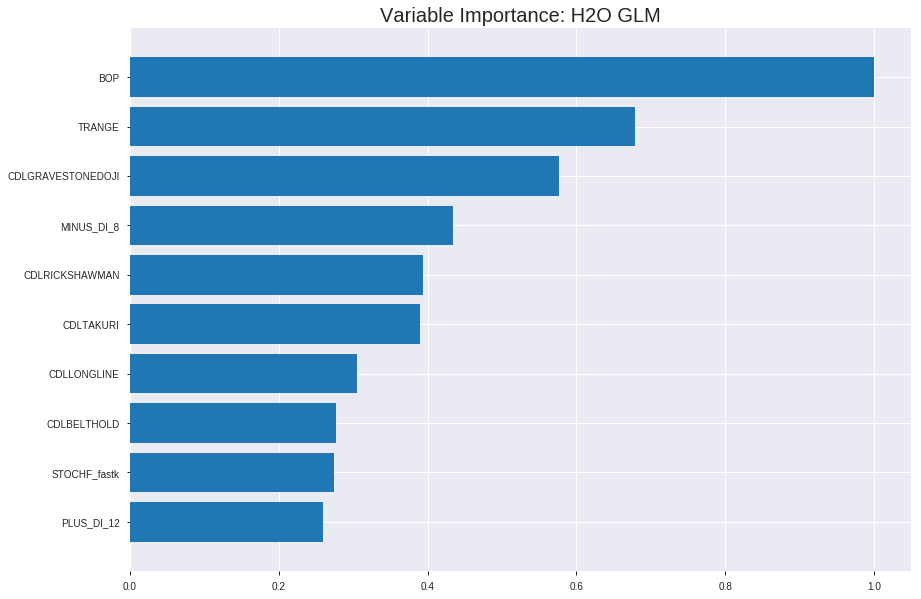

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_162406_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.232907962229063
RMSE: 0.48260538976379347
LogLoss: 0.6579277140158736
Null degrees of freedom: 1787
Residual degrees of freedom: 1603
Null deviance: 2476.257522519208
Residual deviance: 2352.749505320764
AIC: 2722.749505320764
AUC: 0.6605493724840161
pr_auc: 0.6062039400316795
Gini: 0.32109874496803226
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3981716204923906: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      226  701   0.7562   (701.0/927.0)
1      60   801   0.0697   (60.0/861.0)
Total  286  1502  0.4256   (761.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.398172     0.677952  295
max f2                       0.356473     0.827444  333
max f0point5                 0.460892     0.610329  221
max accuracy                 0.476242     0.622483  200
max precision                0.862923     1         0
max recall                   0.254939     1         387
max specificity              0.862923     1         0
max absolute_mcc             0.460892     0.260218  221
max min_per_class_accuracy   0.487423     0.618123  185
max mean_per_class_accuracy  0.460892     0.62612   221

Gains/Lift Table: Avg response rate: 48.15 %, avg score: 48.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.67665            1.49981   1.49981            0.722222         0.708524  0.722222                    0.708524            0.0150987       0.0150987                  49.9806   49.9806
    2        0.0201342                   0.638182           1.26907   1.38444            0.611111         0.65335   0.666667                    0.680937            0.0127758       0.0278746                  26.9067   38.4437
    3        0.0302013                   0.627455           1.49981   1.42289            0.722222         0.632114  0.685185                    0.664663            0.0150987       0.0429733                  49.9806   42.2893
    4        0.0402685                   0.620644           1.38444   1.41328            0.666667         0.624453  0.680556                    0.65461             0.0139373       0.0569106                  38.4437   41.3279
    5        0.0503356                   0.610912           1.1537    1.36136            0.555556         0.615941  0.655556                    0.646877            0.0116144       0.068525                   15.3697   36.1363
    6        0.100112                    0.584981           1.39999   1.38057            0.674157         0.596241  0.664804                    0.6217              0.0696864       0.138211                   39.9992   38.057
    7        0.150447                    0.566819           1.33829   1.36642            0.644444         0.576163  0.657993                    0.606465            0.0673635       0.205575                   33.8289   36.6424
    8        0.200224                    0.553371           1.14333   1.31096            0.550562         0.560019  0.631285                    0.594918            0.0569106       0.262485                   14.3327   31.0961
    9        0.300336                    0.52627            1.25295   1.29163            0.603352         0.539698  0.621974                    0.576512            0.125436        0.387921                   25.2954   29.1625
    10       0.399888                    0.505507           1.18999   1.26632            0.573034         0.515231  0.60979                     0.561256            0.118467        0.506388                   18.9993   26.6324
    11       0.5                         0.486342           1.17174   1.24739            0.564246         0.496297  0.600671                    0.548249            0.117305        0.623693                   17.1744   24.7387
    12       0.600112                    0.465623           1.06733   1.21735            0.513966         0.475213  0.586207                    0.536065            0.106852        0.730546                   6.73311   21.735
    13       0.699664                    0.442767           0.863329  1.16698            0.41573          0.45524   0.56195                     0.524565            0.0859466       0.816492                   -13.6671  16.6977
    14       0.799776                    0.412874           0.777295  1.1182             0.374302         0.429943  0.538462                    0.512721            0.0778165       0.894309                   -22.2705  11.8199
    15       0.899888                    0.369296           0.719288  1.07382            0.346369         0.393279  0.517091                    0.499433            0.0720093       0.966318                   -28.0712  7.38204
    16       1                           0.114912           0.336441  1                  0.162011         0.32074   0.481544                    0.481544           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24418749474152054
RMSE: 0.4941533109688941
LogLoss: 0.681346531456696
Null degrees of freedom: 510
Residual degrees of freedom: 326
Null deviance: 708.4284254426307
Residual deviance: 696.3361551487433
AIC: 1066.3361551487433
AUC: 0.5929512718357339
pr_auc: 0.5540219255287736
Gini: 0.18590254367146786
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25725044095944605: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    257  0.9885   (257.0/260.0)
1      0    251  0        (0.0/251.0)
Total  3    508  0.5029   (257.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.25725      0.661397  396
max f2                       0.25725      0.830026  396
max f0point5                 0.455983     0.578778  247
max accuracy                 0.503911     0.589041  147
max precision                0.624932     0.727273  8
max recall                   0.25725      1         396
max specificity              0.702993     0.996154  0
max absolute_mcc             0.503911     0.179476  147
max min_per_class_accuracy   0.481652     0.576923  195
max mean_per_class_accuracy  0.503911     0.586845  147

Gains/Lift Table: Avg response rate: 49.12 %, avg score: 47.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.649885           1.35724   1.35724            0.666667         0.672578  0.666667                    0.672578            0.0159363       0.0159363                  35.7238   35.7238
    2        0.0215264                   0.624735           1.62869   1.48062            0.8              0.634346  0.727273                    0.6552              0.0159363       0.0318725                  62.8685   48.0623
    3        0.0313112                   0.616825           1.22151   1.39965            0.6              0.619213  0.6875                      0.643954            0.0119522       0.0438247                  22.1514   39.9651
    4        0.0410959                   0.605786           0.814343  1.26029            0.4              0.610094  0.619048                    0.635892            0.00796813      0.0517928                  -18.5657  26.0292
    5        0.0508806                   0.595823           0.814343  1.17453            0.4              0.600207  0.576923                    0.62903             0.00796813      0.059761                   -18.5657  17.4533
    6        0.101761                    0.570054           1.09623   1.13538            0.538462         0.581274  0.557692                    0.605152            0.0557769       0.115538                   9.62305   13.5382
    7        0.150685                    0.551473           1.05865   1.11047            0.52             0.559844  0.545455                    0.590441            0.0517928       0.167331                   5.86454   11.0467
    8        0.201566                    0.53472            1.09623   1.10687            0.538462         0.541003  0.543689                    0.577962            0.0557769       0.223108                   9.62305   10.6873
    9        0.30137                     0.517254           1.2774    1.16335            0.627451         0.525414  0.571429                    0.56056             0.12749         0.350598                   27.74     16.3347
    10       0.401174                    0.499648           1.31732   1.20165            0.647059         0.508201  0.590244                    0.547534            0.131474        0.482072                   31.7319   20.1652
    11       0.500978                    0.481535           0.95805   1.15312            0.470588         0.489071  0.566406                    0.535887            0.0956175       0.577689                   -4.19498  15.3122
    12       0.600783                    0.463423           0.95805   1.12072            0.470588         0.473021  0.550489                    0.525443            0.0956175       0.673307                   -4.19498  12.0716
    13       0.700587                    0.44567            0.878213  1.08617            0.431373         0.454461  0.53352                     0.515331            0.0876494       0.760956                   -12.1787  8.61693
    14       0.800391                    0.421838           0.95805   1.07019            0.470588         0.432272  0.525672                    0.504974            0.0956175       0.856574                   -4.19498  7.01936
    15       0.900196                    0.38003            0.678619  1.02678            0.333333         0.402217  0.504348                    0.493582            0.0677291       0.924303                   -32.1381  2.67798
    16       1                           0.147436           0.758456  1                  0.372549         0.340256  0.491194                    0.478279         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-22 16:24:07  0.000 sec   2            8.2       185           1.37849           1.38271
    2019-08-22 16:24:07  0.099 sec   4            6         185           1.37643           1.38165
    2019-08-22 16:24:07  0.199 sec   6            4.3       185           1.3738            1.38034
    2019-08-22 16:24:07  0.298 sec   8            3.2       185           1.37048           1.37873
    2019-08-22 16:24:07  0.397 sec   10           2.3       185           1.36641           1.37683
    2019-08-22 16:24:07  0.497 sec   12           1.7       185           1.36154           1.37466
    2019-08-22 16:24:07  0.594 sec   14           1.2       185           1.35592           1.37231
    2019-08-22 16:24:07  0.755 sec   16           0.89      185           1.34964           1.36989
    2019-08-22 16:24:07  0.853 sec   18           0.65      185           1.34291           1.36758
    2019-08-22 16:24:08  0.955 sec   20           0.47      185           1.33594           1.36558
    2019-08-22 16:24:08  1.061 sec   22           0.34      185           1.32899           1.36403
    2019-08-22 16:24:08  1.166 sec   24           0.25      185           1.32224           1.36306
    2019-08-22 16:24:08  1.267 sec   26           0.18      185           1.31586           1.36269
    2019-08-22 16:24:08  1.378 sec   28           0.13      185           1.30991           1.36293
    2019-08-22 16:24:08  1.479 sec   30           0.096     185           1.30447           1.36371
    2019-08-22 16:24:08  1.590 sec   32           0.07      185           1.29954           1.36496
    2019-08-22 16:24:08  1.705 sec   34           0.051     185           1.29511           1.36657
    2019-08-22 16:24:08  1.811 sec   36           0.037     185           1.29113           1.36844

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6640625)

('F1', 0.6572237960339944)

('auc', 0.6801958983777165)

('logloss', 0.6546569636281815)

('mean_per_class_error', 0.35007652280379553)

('rmse', 0.4806954871398493)

('mse', 0.231068151356617)

glm prediction progress: |████████████████████████████████████████████████| 100%


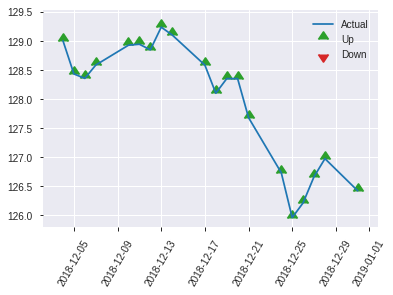


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.231068151356617
RMSE: 0.4806954871398493
LogLoss: 0.6546569636281815
Null degrees of freedom: 255
Residual degrees of freedom: 71
Null deviance: 354.20638056124005
Residual deviance: 335.1843653776289
AIC: 705.1843653776289
AUC: 0.6801958983777165
pr_auc: 0.6830716583766647
Gini: 0.3603917967554331
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3788440201029876: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      19   116  0.8593   (116.0/135.0)
1      5    116  0.0413   (5.0/121.0)
Total  24   232  0.4727   (121.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.378844     0.657224  231
max f2                       0.308852     0.823129  250
max f0point5                 0.527554     0.659824  54
max accuracy                 0.527554     0.664062  54
max precision                0.644478     1         0
max recall                   0.308852     1         250
max specificity              0.644478     1         0
max absolute_mcc             0.527554     0.362029  54
max min_per_class_accuracy   0.466939     0.622222  126
max mean_per_class_accuracy  0.502205     0.649923  77

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 46.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.637192           2.1157    2.1157             1                0.64127   1                           0.64127             0.0247934       0.0247934                  111.57    111.57
    2        0.0234375                   0.620955           2.1157    2.1157             1                0.628541  1                           0.634906            0.0247934       0.0495868                  111.57    111.57
    3        0.03125                     0.613843           2.1157    2.1157             1                0.616524  1                           0.63031             0.0165289       0.0661157                  111.57    111.57
    4        0.0429688                   0.607286           2.1157    2.1157             1                0.609588  1                           0.624659            0.0247934       0.0909091                  111.57    111.57
    5        0.0507812                   0.58958            1.05785   1.95296            0.5              0.599834  0.923077                    0.620839            0.00826446      0.0991736                  5.78512   95.2956
    6        0.101562                    0.563604           1.30197   1.62746            0.615385         0.576887  0.769231                    0.598863            0.0661157       0.165289                   30.1971   62.7463
    7        0.152344                    0.545899           1.95296   1.73596            0.923077         0.553689  0.820513                    0.583805            0.0991736       0.264463                   95.2956   73.5961
    8        0.203125                    0.528357           1.62746   1.70884            0.769231         0.535025  0.807692                    0.57161             0.0826446       0.347107                   62.7463   70.8837
    9        0.300781                    0.502423           1.10017   1.51122            0.52             0.518908  0.714286                    0.554499            0.107438        0.454545                   10.0165   51.1216
    10       0.402344                    0.482647           0.895105  1.35569            0.423077         0.492388  0.640777                    0.538821            0.0909091       0.545455                   -10.4895  35.5693
    11       0.5                         0.465945           0.846281  1.2562             0.4              0.473887  0.59375                     0.526138            0.0826446       0.628099                   -15.3719  25.6198
    12       0.601562                    0.448804           0.732359  1.16776            0.346154         0.457308  0.551948                    0.514517            0.0743802       0.702479                   -26.7641  16.7758
    13       0.699219                    0.434565           0.846281  1.12286            0.4              0.441384  0.530726                    0.504303            0.0826446       0.785124                   -15.3719  12.2859
    14       0.800781                    0.408033           0.813732  1.08365            0.384615         0.4223    0.512195                    0.493903            0.0826446       0.867769                   -18.6268  8.36525
    15       0.898438                    0.379284           0.846281  1.05785            0.4              0.397137  0.5                         0.483385            0.0826446       0.950413                   -15.3719  5.78512
    16       1                           0.290876           0.488239  1                  0.230769         0.346841  0.472656                    0.469517            0

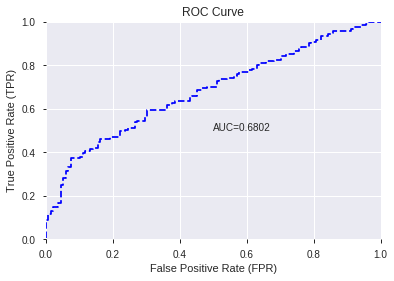

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


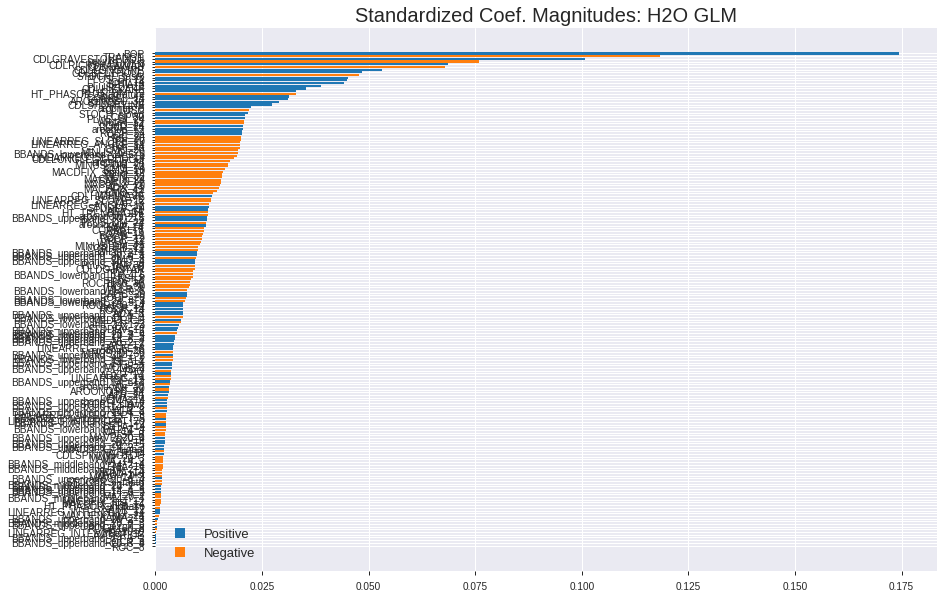

'log_likelihood'
--2019-08-22 16:24:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.187.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.187.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_162406_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_162406_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_a7f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'CDLGRAVESTONEDOJI',
 'MINUS_DI_8',
 'CDLRICKSHAWMAN',
 'CDLTAKURI',
 'CDLLONGLINE',
 'CDLBELTHOLD',
 'STOCHF_fastk',
 'PLUS_DI_12',
 'CCI_14',
 'BETA_8',
 'PLUS_DI_14',
 'CDLHIKKAKE',
 'PLUS_DM_12',
 'HT_PHASOR_quadrature',
 'CORREL_14',
 'AROONOSC_30',
 'STDDEV_14',
 'CDLSHORTLINE',
 'aroonup_8',
 'ULTOSC',
 'STOCH_slowd',
 'CCI_30',
 'PLUS_DI_24',
 'WILLR_12',
 'CMO_24',
 'ROCR_24',
 'aroonup_12',
 'ROCP_24',
 'ROC_24',
 'RSI_20',
 'LINEARREG_SLOPE_20',
 'LINEARREG_ANGLE_14',
 'RSI_24',
 'CMO_20',
 'MINUS_DI_20',
 'BBANDS_lowerband_30_6_5',
 'LINEARREG_SLOPE_14',
 'CDLLONGLEGGEDDOJI',
 'aroonup_24',
 'MINUS_DM_20',
 'CMO_14',
 'BETA_20',
 'MACDFIX_signal_12',
 'MOM_30',
 'MACDFIX_24',
 'SAR_0.14',
 'MACDFIX_20',
 'ADX_24',
 'MACDFIX_12',
 'CMO_12',
 'WILLR_20',
 'CDLHIGHWAVE',
 'LINEARREG_SLOPE_12',
 'VAR_8',
 'LINEARREG_ANGLE_12',
 'STDDEV_20',
 'ADX_14',
 'HT_TRENDMODE',
 'aroondown_12',
 'BBANDS_upperband_30_2_5',
 'PLUS_DM_24',
 'aroondown_24',
 'VAR_14',
 'C

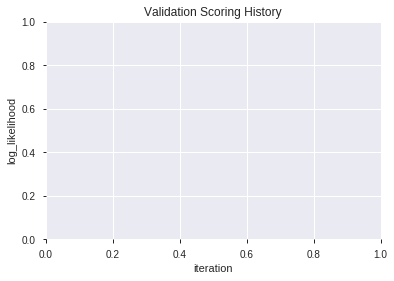

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_162428_model_3  0.705724  0.642132              0.382063  0.474583  0.225229
1  XGBoost_grid_1_AutoML_20190822_162428_model_2  0.704928  0.639277              0.433762  0.473236  0.223952
2               XGBoost_1_AutoML_20190822_162428  0.701622  0.631773              0.403000  0.470086  0.220981
3               XGBoost_3_AutoML_20190822_162428  0.695194  0.648124              0.346893  0.477527  0.228032
4  XGBoost_grid_1_AutoML_20190822_162428_model_7  0.693541  0.636738              0.350872  0.472306  0.223073
5  XGBoost_grid_1_AutoML_20190822_162428_model_6  0.687052  0.647451              0.405846  0.477323  0.227837
6  XGBoost_grid_1_AutoML_20190822_162428_model_4  0.673401  0.654287              0.442026  0.480763  0.231133
7  XGBoost_grid_1_AutoML_20190822_162428_model_5  0.670768  0.646973              0.419957  0.477070  0.227596
8               XGBoost_2_AutoML_20190822_162428  0.635996  0.661830              0.428069  0.484764  0.234996
9  XGBoost_grid_1_AutoML_20190822_162428_model_1  0.633731  0.660750              0.416100  0.484038  0.234292

variable  relative_importance  scaled_importance  percentage
0                        BOP           422.941284           1.000000    0.073371
1                     TRANGE           297.057800           0.702362    0.051533
2                   CORREL_8           130.544662           0.308659    0.022647
3                 MINUS_DI_8           125.127251           0.295850    0.021707
4                    BETA_20           113.545128           0.268465    0.019698
..                       ...                  ...                ...         ...
154               MACDFIX_24             2.029158           0.004798    0.000352
155                   MOM_20             1.930345           0.004564    0.000335
156        MACDFIX_signal_12             1.383608           0.003271    0.000240
157                   EMA_14             1.075860           0.002544    0.000187
158  BBANDS_upperband_14_2_3             0.431530           0.001020    0.000075

[159 rows x 4 columns]

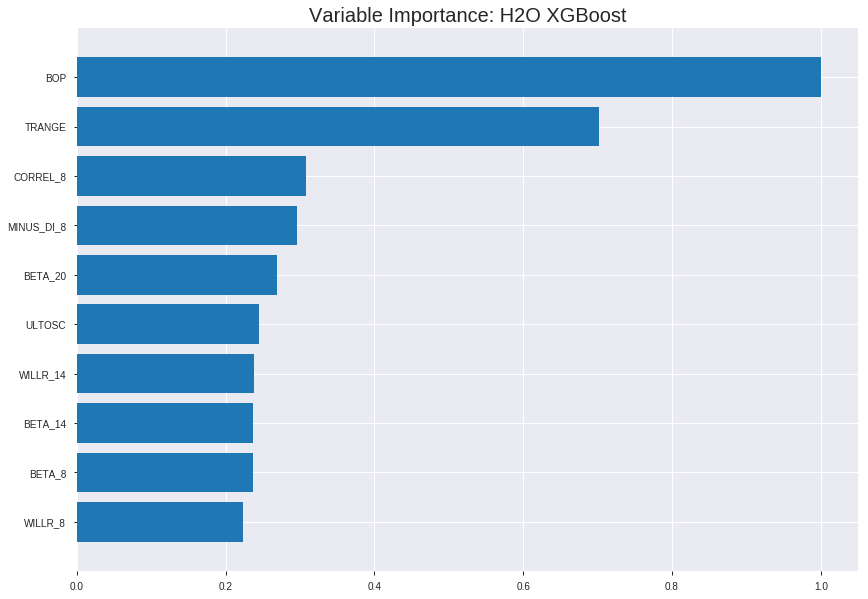

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_162428_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17311378988109205
RMSE: 0.41606945319392535
LogLoss: 0.5324543120645578
Mean Per-Class Error: 0.15553149983649628
AUC: 0.9223632989912885
pr_auc: 0.9201755082227632
Gini: 0.8447265979825771
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4738744596640269: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      756  171  0.1845   (171.0/927.0)
1      109  752  0.1266   (109.0/861.0)
Total  865  923  0.1566   (280.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.473874     0.843049  211
max f2                       0.419683     0.892934  252
max f0point5                 0.527629     0.865143  166
max accuracy                 0.473874     0.8434    211
max precision                0.834026     1         0
max recall                   0.283696     1         352
max specificity              0.834026     1         0
max absolute_mcc             0.473874     0.68883   211
max min_per_class_accuracy   0.484975     0.839266  202
max mean_per_class_accuracy  0.473874     0.844469  211

Gains/Lift Table: Avg response rate: 48.15 %, avg score: 48.33 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.772074           2.07666    2.07666            1                0.793381  1                           0.793381            0.0209059       0.0209059                  107.666   107.666
    2        0.0201342                   0.741211           2.07666    2.07666            1                0.756671  1                           0.775026            0.0209059       0.0418118                  107.666   107.666
    3        0.0302013                   0.722986           2.07666    2.07666            1                0.731418  1                           0.76049             0.0209059       0.0627178                  107.666   107.666
    4        0.0402685                   0.711168           2.07666    2.07666            1                0.716585  1                           0.749513            0.0209059       0.0836237                  107.666   107.666
    5        0.0503356                   0.705229           2.07666    2.07666            1                0.707698  1                           0.74115             0.0209059       0.10453                    107.666   107.666
    6        0.100112                    0.661809           2.07666    2.07666            1                0.681673  1                           0.711578            0.103368        0.207898                   107.666   107.666
    7        0.150447                    0.629748           1.96129    2.03806            0.944444         0.645144  0.981413                    0.689351            0.0987224       0.30662                    96.1285   103.806
    8        0.200224                    0.604331           1.95999    2.01865            0.94382          0.615843  0.972067                    0.671077            0.097561        0.404181                   95.9989   101.865
    9        0.300336                    0.561565           1.83303    1.95677            0.882682         0.582225  0.942272                    0.641459            0.183508        0.587689                   83.3025   95.6774
    10       0.399888                    0.519804           1.57499    1.86173            0.758427         0.540525  0.896503                    0.616332            0.156794        0.744483                   57.4991   86.1729
    11       0.5                         0.479087           1.10214    1.70964            0.530726         0.499197  0.823266                    0.592879            0.110337        0.85482                    10.2135   70.964
    12       0.600112                    0.443863           0.696085   1.54056            0.335196         0.461219  0.741845                    0.570915            0.0696864       0.924506                   -30.3915  54.0557
    13       0.699664                    0.40859            0.454997   1.3861             0.219101         0.426259  0.667466                    0.550332            0.0452962       0.969803                   -54.5003  38.6097
    14       0.799776                    0.368469           0.185623   1.23583            0.0893855        0.388829  0.595105                    0.530116            0.018583        0.988386                   -81.4377  23.5828
    15       0.899888                    0.306047           0.104413   1.10996            0.0502793        0.341818  0.534493                    0.509168            0.010453        0.998839                   -89.5587  10.9959
    16       1                           0.136384           0.0116014  1                  0.00558659       0.251014  0.481544                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24567555102248081
RMSE: 0.49565668665163876
LogLoss: 0.6840429013772984
Mean Per-Class Error: 0.43154305853509034
AUC: 0.5717821023597917
pr_auc: 0.5344583575663079
Gini: 0.1435642047195833
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3813364803791046: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      38   222  0.8538   (222.0/260.0)
1      10   241  0.0398   (10.0/251.0)
Total  48   463  0.454    (232.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.381336     0.67507   353
max f2                       0.278414     0.831677  393
max f0point5                 0.417384     0.578426  313
max accuracy                 0.473136     0.565558  236
max precision                0.803234     1         0
max recall                   0.278414     1         393
max specificity              0.803234     1         0
max absolute_mcc             0.381336     0.18218   353
max min_per_class_accuracy   0.489618     0.534615  200
max mean_per_class_accuracy  0.457545     0.568457  258

Gains/Lift Table: Avg response rate: 49.12 %, avg score: 49.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117417                   0.717258           1.01793   1.01793            0.5              0.746891  0.5                         0.746891            0.0119522       0.0119522                  1.79283    1.79283
    2        0.0215264                   0.691224           1.22151   1.11047            0.6              0.703879  0.545455                    0.72734             0.0119522       0.0239044                  22.1514    11.0467
    3        0.0313112                   0.666432           1.62869   1.27241            0.8              0.674235  0.625                       0.710745            0.0159363       0.0398406                  62.8685    27.241
    4        0.0410959                   0.653492           1.62869   1.35724            0.8              0.658606  0.666667                    0.698331            0.0159363       0.0557769                  62.8685    35.7238
    5        0.0508806                   0.642889           0.814343  1.25283            0.4              0.648031  0.615385                    0.688658            0.00796813      0.063745                   -18.5657   25.2835
    6        0.101761                    0.611717           0.939626  1.09623            0.461538         0.625612  0.538462                    0.657135            0.0478088       0.111554                   -6.03739   9.62305
    7        0.150685                    0.590548           0.977211  1.05759            0.48             0.60093   0.519481                    0.638887            0.0478088       0.159363                   -2.27888   5.75878
    8        0.201566                    0.573397           0.783022  0.98828            0.384615         0.582652  0.485437                    0.624691            0.0398406       0.199203                   -21.6978   -1.17201
    9        0.30137                     0.535939           1.39716   1.12369            0.686275         0.552354  0.551948                    0.600736            0.139442        0.338645                   39.7156    12.3687
    10       0.401174                    0.512281           1.11773   1.1222             0.54902          0.524105  0.55122                     0.581671            0.111554        0.450199                   11.7725    12.2204
    11       0.500978                    0.489618           0.878213  1.0736             0.431373         0.500376  0.527344                    0.565476            0.0876494       0.537849                   -12.1787   7.35962
    12       0.600783                    0.473127           1.31732   1.11408            0.647059         0.481495  0.547231                    0.551525            0.131474        0.669323                   31.7319    11.4084
    13       0.700587                    0.449115           0.918131  1.08617            0.45098          0.460337  0.53352                     0.538534            0.0916335       0.760956                   -8.18686   8.61693
    14       0.800391                    0.425625           0.918131  1.06522            0.45098          0.438117  0.523227                    0.526013            0.0916335       0.85259                    -8.18686   6.52159
    15       0.900196                    0.383149           0.997969  1.05776            0.490196         0.404499  0.519565                    0.512541            0.0996016       0.952191                   -0.203109  5.77603
    16       1                           0.16124            0.479025  1                  0.235294         0.331527  0.491194                    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:24:37  2.556 sec   0                  0.5              0.693147            0.5             0                  1                0.518456                         0.5                0.693147              0.5               0                    1                  0.508806
    2019-08-22 16:24:38  2.840 sec   5                  0.485786         0.665034            0.787344        0.766579           1.96129          0.288031                         0.500506           0.694165              0.505739          0.482784             0.339309           0.493151
    2019-08-22 16:24:38  2.947 sec   10                 0.475444         0.644878            0.833596        0.812342           1.96129          0.262864                         0.498778           0.690689              0.538002          0.505096             1.01793            0.499022
    2019-08-22 16:24:38  3.061 sec   15                 0.465106         0.624856            0.847814        0.836202           2.07666          0.245526                         0.498221           0.689539              0.548629          0.507245             0.678619           0.452055
    2019-08-22 16:24:38  3.173 sec   20                 0.457142         0.60945             0.862002        0.853426           2.07666          0.230984                         0.498067           0.689203              0.54846           0.513561             1.01793            0.446184
    2019-08-22 16:24:38  3.296 sec   25                 0.449959         0.595629            0.872215        0.864681           2.07666          0.205257                         0.497311           0.68762               0.553632          0.517313             1.01793            0.454012
    2019-08-22 16:24:38  3.412 sec   30                 0.442787         0.582001            0.884391        0.875945           2.07666          0.211969                         0.497691           0.688394              0.550038          0.509486             0.678619           0.444227
    2019-08-22 16:24:38  3.535 sec   35                 0.436071         0.569501            0.897186        0.890324           2.07666          0.186801                         0.497082           0.68706               0.55367           0.519881             1.35724            0.436399
    2019-08-22 16:24:38  3.658 sec   40                 0.430038         0.558197            0.903373        0.89891            2.07666          0.168345                         0.497909           0.688684              0.547763          0.514661             1.01793            0.465753
    2019-08-22 16:24:38  3.786 sec   45                 0.422631         0.544449            0.91405         0.910944           2.07666          0.161074                         0.495751           0.684218              0.569307          0.531914             1.35724            0.446184
    2019-08-22 16:24:39  3.917 sec   50                 0.416069         0.532454            0.922363        0.920176           2.07666          0.1566                           0.495657           0.684043              0.571782          0.534458             1.01793            0.454012

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      422.9412841796875      1.0                    0.07337119049233135
TRANGE                   297.05780029296875     0.7023617967896535     0.05153312118678978
CORREL_8                 130.54466247558594     0.30865906772090795    0.02264668325493614
MINUS_DI_8               125.12725067138672     0.29585016963779337    0.02170687915368308
BETA_20                  113.54512786865234     0.2684654634481425     0.01969763065926568
---                      ---                    ---                    ---
MACDFIX_24               2.0291576385498047     0.004797728938865454   0.000352015083904068
MOM_20                   1.930344581604004      0.004564095901273835   0.00033487314979763124
MACDFIX_signal_12        1.3836078643798828     0.0032713946737629286  0.00024002612178425798
EMA_14                   1.0758600234985352     0.0025437574049674795  0.0001866385091261474
BBANDS_upperband_14_2_3  0.4315299987792969     0.001020307108624469   7.486114722756574e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.671875)

('F1', 0.6851851851851853)

('auc', 0.7057239057239056)

('logloss', 0.6421318219349327)

('mean_per_class_error', 0.3302418120599939)

('rmse', 0.47458339775473096)

('mse', 0.22522940142442516)

xgboost prediction progress: |████████████████████████████████████████████| 100%


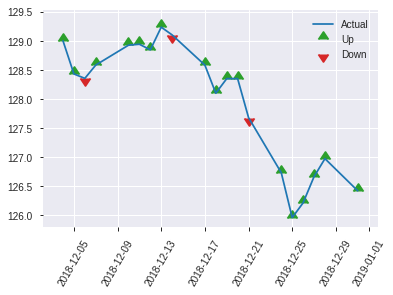


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.22522940142442516
RMSE: 0.47458339775473096
LogLoss: 0.6421318219349327
Mean Per-Class Error: 0.3302418120599939
AUC: 0.7057239057239056
pr_auc: 0.6512147370300024
Gini: 0.4114478114478113
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4053952097892761: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      43   92   0.6815   (92.0/135.0)
1      10   111  0.0826   (10.0/121.0)
Total  53   203  0.3984   (102.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.405395     0.685185  202
max f2                       0.319223     0.826446  241
max f0point5                 0.519859     0.661605  84
max accuracy                 0.519859     0.671875  84
max precision                0.708505     1         0
max recall                   0.206251     1         255
max specificity              0.708505     1         0
max absolute_mcc             0.519859     0.345973  84
max min_per_class_accuracy   0.473482     0.651852  125
max mean_per_class_accuracy  0.469733     0.669758  133

Gains/Lift Table: Avg response rate: 47.27 %, avg score: 47.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.686911           2.1157    2.1157             1                0.706119  1                           0.706119            0.0247934       0.0247934                  111.57    111.57
    2        0.0234375                   0.657755           1.41047   1.76309            0.666667         0.663925  0.833333                    0.685022            0.0165289       0.0413223                  41.0468   76.3085
    3        0.03125                     0.639333           2.1157    1.85124            1                0.643218  0.875                       0.674571            0.0165289       0.0578512                  111.57    85.124
    4        0.0429688                   0.635922           1.41047   1.73103            0.666667         0.63704   0.818182                    0.664335            0.0165289       0.0743802                  41.0468   73.1029
    5        0.0507812                   0.634191           2.1157    1.79021            1                0.634695  0.846154                    0.659775            0.0165289       0.0909091                  111.57    79.021
    6        0.101562                    0.591342           0.976478  1.38334            0.461538         0.6087    0.653846                    0.634238            0.0495868       0.140496                   -2.35219  38.3344
    7        0.152344                    0.571942           1.62746   1.46472            0.769231         0.581826  0.692308                    0.616767            0.0826446       0.22314                    62.7463   46.4717
    8        0.203125                    0.556428           1.46472   1.46472            0.692308         0.56395   0.692308                    0.603563            0.0743802       0.297521                   46.4717   46.4717
    9        0.300781                    0.526399           1.43868   1.45626            0.68             0.541054  0.688312                    0.583268            0.140496        0.438017                   43.8678   45.6263
    10       0.402344                    0.491506           1.05785   1.35569            0.5              0.510271  0.640777                    0.564842            0.107438        0.545455                   5.78512   35.5693
    11       0.5                         0.472529           1.26942   1.33884            0.6              0.481136  0.632812                    0.548493            0.123967        0.669421                   26.9421   33.8843
    12       0.601562                    0.450405           0.895105  1.26393            0.423077         0.461124  0.597403                    0.533742            0.0909091       0.760331                   -10.4895  26.3926
    13       0.699219                    0.424372           0.761653  1.19378            0.36             0.437721  0.564246                    0.520331            0.0743802       0.834711                   -23.8347  19.3776
    14       0.800781                    0.403096           0.813732  1.14558            0.384615         0.412821  0.541463                    0.506696            0.0826446       0.917355                   -18.6268  14.5575
    15       0.898438                    0.364299           0.338512  1.05785            0.16             0.385736  0.5                         0.493548            0.0330579       0.950413                   -66.1488  5.78512
    16       1                           0.206251           0.488239  1                  0.230769         0.294955  0.472656                    0.473379            

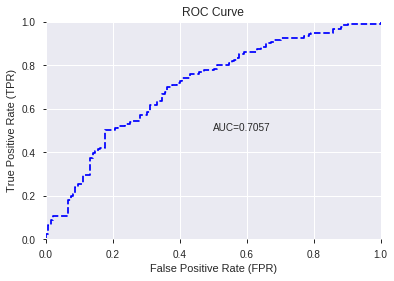

This function is available for GLM models only


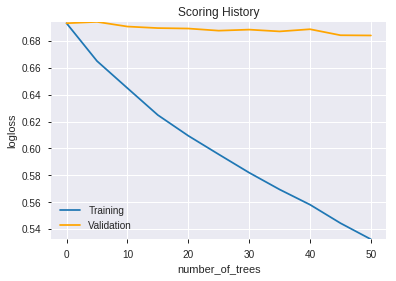

--2019-08-22 16:24:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_162428_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_162428_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_a7f4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'CORREL_8',
 'MINUS_DI_8',
 'BETA_20',
 'ULTOSC',
 'WILLR_14',
 'BETA_14',
 'BETA_8',
 'WILLR_8',
 'NATR_12',
 'PLUS_DI_24',
 'STOCHF_fastk',
 'ADXR_14',
 'DX_24',
 'CORREL_12',
 'HT_PHASOR_quadrature',
 'WILLR_20',
 'STOCH_slowk',
 'WILLR_12',
 'BBANDS_lowerband_20_3_4',
 'DX_14',
 'MACDEXT_signal',
 'CDLGRAVESTONEDOJI',
 'aroondown_12',
 'MINUS_DM_20',
 'HT_PHASOR_inphase',
 'PPO',
 'ROC_12',
 'PLUS_DI_12',
 'CORREL_14',
 'MACDFIX_hist_12',
 'LINEARREG_SLOPE_20',
 'CDLTAKURI',
 'NATR_8',
 'MINUS_DM_24',
 'AROONOSC_24',
 'aroondown_30',
 'ROC_8',
 'STOCH_slowd',
 'MINUS_DI_30',
 'aroonup_12',
 'STDDEV_14',
 'PLUS_DI_14',
 'CDLLONGLINE',
 'ATR_20',
 'CCI_30',
 'AROONOSC_30',
 'BBANDS_lowerband_12_7_5',
 'ADX_14',
 'PLUS_DM_24',
 'CDLSHORTLINE',
 'TRIX_8',
 'BBANDS_upperband_30_2_5',
 'CCI_14',
 'STDDEV_20',
 'ATR_12',
 'LINEARREG_ANGLE_14',
 'BBANDS_lowerband_30_6_5',
 'PLUS_DM_12',
 'ROCR_12',
 'BBANDS_lowerband_14_1_2',
 'ROCP_24',
 'BBANDS_upperband_30_0_4',
 'BB

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.695
GLM             0.664
XGBoost         0.684
dtype: float64

DeepLearning    GLM  XGBoost
All          0.664  0.652    0.684
DLF          0.656  0.625    0.660
Fwe          0.684  0.641    0.648
RFE          0.695  0.664    0.672
XGBF         0.641  0.625    0.660





F1


DeepLearning    0.676
GLM             0.663
XGBoost         0.698
dtype: float64

DeepLearning    GLM  XGBoost
All          0.659  0.661    0.677
DLF          0.658  0.663    0.698
Fwe          0.658  0.654    0.652
RFE          0.676  0.657    0.685
XGBF         0.655  0.663    0.698





auc


DeepLearning    0.719
GLM             0.680
XGBoost         0.714
dtype: float64

DeepLearning    GLM  XGBoost
All          0.663  0.673    0.714
DLF          0.672  0.651    0.706
Fwe          0.689  0.639    0.665
RFE          0.719  0.680    0.706
XGBF         0.651  0.651    0.706





logloss


DeepLearning    0.676
GLM             0.669
XGBoost         0.665
dtype: float64

DeepLearning    GLM  XGBoost
All          0.657  0.655    0.639
DLF          0.669  0.664    0.644
Fwe          0.675  0.669    0.665
RFE          0.668  0.655    0.642
XGBF         0.676  0.664    0.644





mean_per_class_error


DeepLearning    0.362
GLM             0.375
XGBoost         0.356
dtype: float64

DeepLearning    GLM  XGBoost
All          0.347  0.352    0.326
DLF          0.346  0.375    0.333
Fwe          0.328  0.371    0.356
RFE          0.311  0.350    0.330
XGBF         0.362  0.375    0.333





rmse


DeepLearning    0.491
GLM             0.488
XGBoost         0.486
dtype: float64

DeepLearning    GLM  XGBoost
All          0.483  0.481    0.473
DLF          0.488  0.485    0.475
Fwe          0.490  0.488    0.486
RFE          0.488  0.481    0.475
XGBF         0.491  0.485    0.475





mse


DeepLearning    0.241
GLM             0.238
XGBoost         0.236
dtype: float64

DeepLearning    GLM  XGBoost
All          0.233  0.231    0.224
DLF          0.238  0.235    0.226
Fwe          0.240  0.238    0.236
RFE          0.238  0.231    0.225
XGBF         0.241  0.235    0.226

{'F1':       DeepLearning    GLM  XGBoost
 All          0.659    NaN      NaN
 DLF          0.658    NaN      NaN
 DLF            NaN  0.663      NaN
 DLF            NaN    NaN    0.698
 All            NaN  0.661      NaN
 All            NaN    NaN    0.677
 XGBF         0.655    NaN      NaN
 XGBF           NaN  0.663      NaN
 XGBF           NaN    NaN    0.698
 Fwe          0.658    NaN      NaN
 Fwe            NaN  0.654      NaN
 Fwe            NaN    NaN    0.652
 RFE          0.676    NaN      NaN
 RFE            NaN  0.657      NaN
 RFE            NaN    NaN    0.685,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.664    NaN      NaN
 DLF          0.656    NaN      NaN
 DLF            NaN  0.625      NaN
 DLF            NaN    NaN    0.660
 All            NaN  0.652      NaN
 All            NaN    NaN    0.684
 XGBF         0.641    NaN      NaN
 XGBF           NaN  0.625      NaN
 XGBF           NaN    NaN    0.660
 Fwe          0.684    NaN      NaN
 Fwe     